In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
import glob
import re
import gzip
from collections import defaultdict
from Bio import SeqIO
from Bio.Data.IUPACData import ambiguous_dna_values
ambiguous_dna_values['U'] = 'T' # some sequences are given as RNA
%matplotlib inline

sns.set_style('whitegrid')
rev_re = re.compile(r'R\d?$')

In [2]:
assert pd.__version__ >= '1.1.3'

# Before you begin

This assumes you have followed the instructions as per the README. If not, before you begin please download the hCov-19 nextfasta file (sequences_2020-10-12_07-17.fasta.gz) and msa_1021 file (msa_1012.tar.xz) to the same directory as this notebook. Then run the following commands in your shell:

~~~
tar xvf msa_1012.tar.xz
python3 reheader_msa.py  msa_1012.fasta

~~~

If on Windows, 7-Zip can help you extract the files from msa_1012.tar.xz instead (you will need to do this in two steps in order to get the required msa_1012.fasta file)

In [3]:
# If GISAID filenames change this is where you need to edit them
hcov_seq_fasta = "sequences_2020-10-12_07-17.fasta.gz"
msa_fasta = "msa_1012.reheadered.fasta"

In [4]:
from Bio import pairwise2


def ambiguous_match(nt1, nt2):
    return set(ambiguous_dna_values[nt1]).intersection(set(ambiguous_dna_values[nt2]))


def get_align_positions(seq):
    ''' Return the position of all aligned letters'''
    align_pos = []
    for i in range(len(seq)):
        if seq[i] == '-':
            continue
        align_pos.append(i)
    return align_pos


def seq_pos_to_align_pos(seq, positions):
    ''' Return the positions within alignment of given sequence positions'''
    x = 0
    aligned = []
    stop_at = max(positions)
    for i in range(len(seq)):
        if seq[i] == '-':
            continue
        if x in positions:
            aligned.append(i)
        x += 1
        if x > stop_at:
            break
    return aligned


def align_pos_to_seq_pos(seq, positions):
    ''' Return the positions within sequence of given alignment positions'''
    x = 0
    aligned = []
    stop_at = max(positions)
    for i in range(len(seq)):
        if seq[i] == '-':
            continue
        if i in positions:
            aligned.append(x)
        x += 1
        if i > stop_at:
            break
    return aligned


def pairwise_matches(query, ref, align_indices, check_flanks=20, query_start=0, query_end=-1):
    comps = dict(match=0,
                 mismatch=0,
                 deletion=0,
                 insertion=0)
    # go through each alignment index from min to max to allow for gaps
    q = query_start
    for i in range(align_indices[query_start], align_indices[query_end] + 1):
        if i in align_indices:
            if query[q] == ref[i]:
                comps['match'] += 1
#             elif ref[i] in ambiguous_dna_values[query[q]]:
#                 comps['match'] += 1
            elif ref[i] == '-':
                comps['deletion'] += 1
            elif ambiguous_match(ref[i], query[q]):
                comps['match'] += 1
            else:
                comps['mismatch'] += 1
            q += 1
        else:
            if ref[i] != '-':
                comps['insertion'] += 1
            # otherwise is gap in both sequences
    if comps['deletion'] or comps['insertion']:
        # attempt pairwise alignment of flanking sequences to see
        # if there really is an exact match to primer - e.g.
        # primer: ACGTACG-T
        # ref:    ACGTACGTT
        # msa:    ACGTACG-T
        start = max((align_indices[0] - check_flanks, 0))
        end = align_indices[-1] + check_flanks
        for a in pairwise2.align.localms(query, ref[start:end], 2, -1, -5, -1):
            if a[0][a.start:a.end] == a[1][a.start:a.end]: # exact match
                comps = dict(match=len(align_indices[query_start:query_end]) + 1,
                             mismatch=0,
                             deletion=0,
                             insertion=0)
                return comps
            # otherwise just accept multi-alignment based matches
    return comps

def primer_to_assay(primer):
    if re.match(r'M-\d+-[FPR]', primer):
        return 'M-XXX'
    return primer.rstrip(re.split(r'[-_]', primer)[-1]).rstrip('_-')


def primer_to_probe_type(primer):
    return re.split(r'[-_]', primer)[-1].rstrip('12')

## Find primer positions relative to Wuhan reference sequence 'Wuhan/WIV04/2019' from probe/ref mafft alignment

In [5]:
ref = 'Wuhan/WIV04/2019'
probes = dict()
primer_pos = defaultdict(list)
found = False
with gzip.open(hcov_seq_fasta, 'rt') as fh:
    for ref_record in SeqIO.parse(fh, 'fasta'):
        if ref_record.id == ref:
            found = True
            sys.stderr.write("Found {} sequence".format(ref))
            break
if not found:
    raise ValueError("Could not find {} reference in alignment {}".format(ref, fasta))
    
with gzip.open("all_primers_probes.fasta.gz", 'rt') as fh:
    for record in SeqIO.parse(fh, "fasta"):
        if rev_re.search(record.id) or record.id == 'S-Gene-P':
            sys.stderr.write("Reverse complementing {}\n".format(record.id))
            record.seq = record.seq.reverse_complement()
        probes[record.id] = record
        pw_scores = defaultdict(list)
        for alignment in pairwise2.align.localms(record.seq,
                                                 ref_record.seq,
                                                 2,
                                                 -1,
                                                 -10,
                                                 -1):
            pw_scores[alignment.score].append(alignment)
        if not pw_scores:
            raise ValueError("No alignments found for {}".format(record.id))
        max_score = max(pw_scores.keys())
        if len(pw_scores[max_score]) > 1:
            raise ValueError("Multiple ({}) ".format(len(pw_scores[max])) +
                             "sequences with best alignment score")
        alignment = pw_scores[max_score][0]
        print(record.id)
        print(pairwise2.format_alignment(*alignment))
        for i in range(alignment.start, alignment.end):
            if alignment[0][i] == '-':
                raise ValueError("Gap in primer sequence {} at alignment position {}".format(record.id, i))
            elif alignment[1][i] == '-':
                raise ValueError("Insertion in primer sequence {} at alignment position {}".format(record.id, i))
            elif alignment[0][i] != alignment[1][i]:
                if not ambiguous_match(alignment[0][i], alignment[1][i]):
                    sys.stderr.write("Warning: mismatch in primer {} at reference position {}".format(record.id, i))
            primer_pos[record.id].append(i)
primer_pos

Found Wuhan/WIV04/2019 sequence

E_Sarbeco-F1
    1 ACAGGTACGTTAATAGTTAATAGCGT
      ||||||||||||||||||||||||||
26269 ACAGGTACGTTAATAGTTAATAGCGT
  Score=52



Reverse complementing E_Sarbeco-R2


E_Sarbeco-R2
    1 TGTGTGCGTACTGCTGCAATAT
      ||||||||||||||||||||||
26360 TGTGTGCGTACTGCTGCAATAT
  Score=44

E_Sarbeco-P1
    1 ACACTAGCCATCCTTACTGCGCTTCG
      ||||||||||||||||||||||||||
26332 ACACTAGCCATCCTTACTGCGCTTCG
  Score=52

RdRp_SARSr-F2
    1 GTGARATGGTCATGTGTGGCGG
      ||||.|||||||||||||||||
15431 GTGAAATGGTCATGTGTGGCGG
  Score=41



Reverse complementing RdRp_SARSr-R1


RdRp_SARSr-R1
    1 TATGCTAATAGTGTSTTTAACATYTG
      ||||||||||||||.||||||||.||
15505 TATGCTAATAGTGTTTTTAACATTTG
  Score=46



RdRp_SARSr-P2
    1 CAGGTGGAACCTCATCAGGAGATGC
      |||||||||||||||||||||||||
15470 CAGGTGGAACCTCATCAGGAGATGC
  Score=50

2019-nCoV_N1-F
    1 GACCCCAAAATCAGCGAAAT
      ||||||||||||||||||||
28287 GACCCCAAAATCAGCGAAAT
  Score=40



Reverse complementing 2019-nCoV_N1-R


2019-nCoV_N1-R
    1 CAGATTCAACTGGCAGTAACCAGA
      ||||||||||||||||||||||||
28335 CAGATTCAACTGGCAGTAACCAGA
  Score=48

2019-nCoV_N1-P
    1 ACCCCGCATTACGTTTGGTGGACC
      ||||||||||||||||||||||||
28309 ACCCCGCATTACGTTTGGTGGACC
  Score=48

2019-nCoV_N2-F
    1 TTACAAACATTGGCCGCAAA
      ||||||||||||||||||||
29164 TTACAAACATTGGCCGCAAA
  Score=40



Reverse complementing 2019-nCoV_N2-R


2019-nCoV_N2-R
    1 TTCTTCGGAATGTCGCGC
      ||||||||||||||||||
29213 TTCTTCGGAATGTCGCGC
  Score=36

2019-nCoV_N2-P
    1 ACAATTTGCCCCCAGCGCTTCAG
      |||||||||||||||||||||||
29188 ACAATTTGCCCCCAGCGCTTCAG
  Score=46

M-475-F
    1 TGTGACATCAAGGACCTGCC
      ||||||||||||||||||||
26997 TGTGACATCAAGGACCTGCC
  Score=40



Reverse complementing M-574-R


M-574-R
    1 GCGTGTAGCAGGTGACTCAG
      ||||||||||||||||||||
27077 GCGTGTAGCAGGTGACTCAG
  Score=40

M-507-P
    1 TGTTGCTACATCACGAACGC
      ||||||||||||||||||||
27029 TGTTGCTACATCACGAACGC
  Score=40

S-Gene-F
    1 TCAACTCAGGACTTGTTCTTAC
      ||||||||||||||||||||||
21710 TCAACTCAGGACTTGTTCTTAC
  Score=44



Reverse complementing S-Gene-R


S-Gene-R
    1 GTTTGATAACCCTGTCCTACCA
      ||||||||||||||||||||||
21796 GTTTGATAACCCTGTCCTACCA
  Score=44



Reverse complementing S-Gene-P


S-Gene-P
    1 ATGCTATACATGTCTCTGGGACCA
      ||||||||||||||||||||||||
21759 ATGCTATACATGTCTCTGGGACCA
  Score=48



defaultdict(list,
            {'E_Sarbeco-F1': [26268,
              26269,
              26270,
              26271,
              26272,
              26273,
              26274,
              26275,
              26276,
              26277,
              26278,
              26279,
              26280,
              26281,
              26282,
              26283,
              26284,
              26285,
              26286,
              26287,
              26288,
              26289,
              26290,
              26291,
              26292,
              26293],
             'E_Sarbeco-R2': [26359,
              26360,
              26361,
              26362,
              26363,
              26364,
              26365,
              26366,
              26367,
              26368,
              26369,
              26370,
              26371,
              26372,
              26373,
              26374,
              26375,
              26376,
              26377,
    

## Convert primer positions relative to multiple sequence alignment of all strains

In [6]:
primer_msa_pos = dict()
found = False
with open(msa_fasta, 'rt') as fh:
    for ref_record in SeqIO.parse(fh, 'fasta'):
        if ref_record.id == ref:
            found = True
            break
if not found:
    raise ValueError("Could not find ref sequence {}".format(ref))
for k, v in primer_pos.items():
    primer_msa_pos[k] = seq_pos_to_align_pos(ref_record.seq, v)
primer_msa_pos

{'E_Sarbeco-F1': [26988,
  26989,
  26990,
  26991,
  26992,
  26993,
  26994,
  26995,
  26996,
  26997,
  26998,
  26999,
  27000,
  27001,
  27002,
  27003,
  27004,
  27005,
  27006,
  27007,
  27008,
  27009,
  27010,
  27011,
  27012,
  27013],
 'E_Sarbeco-R2': [27079,
  27080,
  27081,
  27082,
  27083,
  27084,
  27085,
  27086,
  27087,
  27088,
  27089,
  27090,
  27091,
  27092,
  27093,
  27094,
  27095,
  27096,
  27097,
  27098,
  27099,
  27100],
 'E_Sarbeco-P1': [27051,
  27052,
  27053,
  27054,
  27055,
  27056,
  27057,
  27058,
  27059,
  27060,
  27061,
  27062,
  27063,
  27064,
  27065,
  27066,
  27067,
  27068,
  27069,
  27070,
  27071,
  27072,
  27073,
  27074,
  27075,
  27076],
 'RdRp_SARSr-F2': [15848,
  15849,
  15850,
  15851,
  15852,
  15853,
  15854,
  15855,
  15856,
  15857,
  15858,
  15859,
  15860,
  15861,
  15862,
  15863,
  15864,
  15865,
  15866,
  15867,
  15868,
  15869],
 'RdRp_SARSr-R1': [15922,
  15923,
  15924,
  15925,
  15926,
  159

## Get matching sequences and match stats from all sequences in multi-alignment

In [7]:
strain2probe_seq = defaultdict(dict)
strain2probe_match = defaultdict(dict)
strain2probe_n = defaultdict(list) # record primer/probe combinations with 'N' in seq
strain2probe_del = defaultdict(list) # record primer/probe combinations with large (>15nt gaps) surrounding primer
strain2probe_ins = defaultdict(list) # record primer/probe combinations with insertions
strain_quals = defaultdict(dict)
n = 0
gap_window = 15
max_surround_gap = 15
with open(msa_fasta, 'rt') as fh:
    for ref_record in SeqIO.parse(fh, 'fasta'):
        for k, v in primer_msa_pos.items():
            s = ref_record.seq[v[0]:v[-1]+1]
            strain2probe_seq[ref_record.id][k] = s
            if 'N' in s:
                strain2probe_n[ref_record.id].append(k)
            if '-' in s:
                start = max(0, v[0] - gap_window)
                if ref_record.seq[start:v[-1] + gap_window].count('-') > max_surround_gap: 
                    strain2probe_del[ref_record.id].append(k)
            if len(s) > len(probes[k].seq):
                strain2probe_ins[ref_record.id].append(k)
            strain2probe_match[ref_record.id][k] = pairwise_matches(probes[k].seq,
                                                                    ref_record.seq,
                                                                    v)
        n += 1
        if n % 10000 == 0:
            print("Processed {:,} sequences".format(n))
print("Finished processing {:,}".format(n))

Processed 10,000 sequences
Processed 20,000 sequences
Processed 30,000 sequences
Processed 40,000 sequences
Processed 50,000 sequences
Processed 60,000 sequences
Processed 70,000 sequences
Processed 80,000 sequences
Processed 90,000 sequences
Processed 100,000 sequences
Processed 110,000 sequences
Processed 120,000 sequences
Processed 130,000 sequences
Finished processing 131,750


## Perform QC on sequences 

### Get the % Ns in each sequence

In [8]:
strain_quals = defaultdict(list)
with gzip.open(hcov_seq_fasta, 'rt') as fh:
    for seq_record in SeqIO.parse(fh, 'fasta'):
        l = len(seq_record.seq)
        n = seq_record.seq.count('N')
        gaps = seq_record.seq.count('-')
        strain_quals['strain'].append(seq_record.id)
        strain_quals['length'].append(l)
        strain_quals['N'].append(n)
        strain_quals['frac_N'].append(n/l)
strain_quals = pd.DataFrame.from_dict(strain_quals)
strain_quals.to_csv("strain_Ns.csv", index=False, sep='\t')
strain_quals.head()

,strain,length,N,frac_N
0,Wuhan/IVDC-HB-01/2019,29891,0,0.0
1,Wuhan/IVDC-HB-04/2020,29896,0,0.0
2,Wuhan/IVDC-HB-05/2019,29891,0,0.0
3,Wuhan/IPBCAMS-WH-01/2019,29899,0,0.0
4,Wuhan/WIV04/2019,29891,0,0.0


### Get the number of gaps in the MSA for each sequence
First determine the starting point of the reference strain sequence in the MSA and the endpoint after removing the poly-A tail

In [9]:
found = False
with open(msa_fasta, 'rt') as fh:
    for ref_record in SeqIO.parse(fh, 'fasta'):
        if ref_record.id == ref:
            found = True
            break
if not found:
    raise ValueError("Could not find ref sequence {}".format(ref))
ref_msa_start = seq_pos_to_align_pos(ref_record.seq, range(0, 29892))[0]
ref_msa_end = seq_pos_to_align_pos(ref_record.seq, range(0, 29892))[-1]
trim = 0
for nt in ref_record.seq[ref_msa_end:ref_msa_start:-1]:
    if nt == 'A' or nt == '-':
        trim += 1
    else:
        break
ref_msa_end = ref_msa_end - trim + 1
str(ref_record.seq[ref_msa_start:ref_msa_end])

'ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATC--TGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTA-TAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTT-CGTCCGTGTTGCAGCC---GATCATCAGCACATCTAGGTTTCGTCCGGGTGTGACCGAAAGGTAAG--ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATAC-TGCTGCC-GTGAACATGAGCATGAAATTGCTTGGTAC

Count Ns and gaps within reference sequence region of the MSA

In [10]:
strain_gaps = defaultdict(list)
with open(msa_fasta, 'rt') as fh:
    for ref_record in SeqIO.parse(fh, 'fasta'):
        l = ref_msa_end - ref_msa_start
        seq = ref_record.seq[ref_msa_start:ref_msa_end]
        gaps = seq.count('-')
        ns = seq.count('N')
        seq_length = l - gaps - ns
        strain_gaps['strain'].append(ref_record.id)
        strain_gaps['length'].append(seq_length)
        strain_gaps['gaps'].append(gaps)
        strain_gaps['frac_gaps'].append(gaps/seq_length)
strain_gaps = pd.DataFrame.from_dict(strain_gaps)
strain_gaps.to_csv("strain_gaps.csv", index=False, sep='\t')
strain_gaps.head()

,strain,length,gaps,frac_gaps
0,Wuhan/WIV04/2019,29870,739,0.024741
1,Germany/NW-HHU-42-2/2020,29758,827,0.027791
2,England/ALDP-6D6489/2020,29782,827,0.027768
3,USA/MI-UM-2006S000856/2020,29782,827,0.027768
4,England/BRIS-12705D/2020,29782,827,0.027768


In [11]:
strain_gaps.describe()

,length,gaps,frac_gaps
count,131750.000000,131750.000000,131750.000000
mean,29612.864372,816.546019,0.027589
std,333.757736,74.173992,0.002683
min,27635.000000,669.000000,0.022848
25%,29515.000000,777.000000,0.026178
50%,29781.000000,827.000000,0.027768
75%,29813.000000,827.000000,0.027997
max,29877.000000,1608.000000,0.057831


Use 95th percentile cutoff to remove gappy sequences

Using 95% cutoff at 0.030502


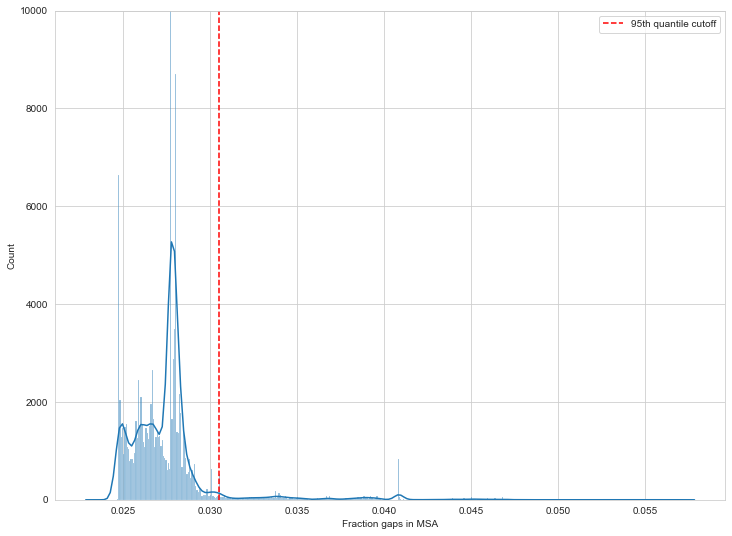

In [12]:
quant_cutoff = strain_gaps.frac_gaps.quantile(0.95)
print("Using 95% cutoff at {:g}".format(quant_cutoff))
plt.figure(figsize=(12,9))
sns.histplot(strain_gaps.frac_gaps, kde=True)
#plt.yscale('log')
plt.ylim(0, 10000)
# ref_gaps = strain_gaps[strain_gaps.strain == ref].frac_gaps.values[0]
# plt.plot([ref_gaps, ref_gaps], [0, 10000], '--', c='k')
plt.plot([quant_cutoff, quant_cutoff], [0, 10000],
         '--',
         c='r',
         label='95th quantile cutoff')
plt.xlabel('Fraction gaps in MSA')
plt.legend()

In [13]:
strain_gaps[strain_gaps.strain == ref]

,strain,length,gaps,frac_gaps
0,Wuhan/WIV04/2019,29870,739,0.024741


In [14]:
strain_quals['N_filter'] = strain_quals['frac_N'] >= 0.01

No handles with labels found to put in legend.


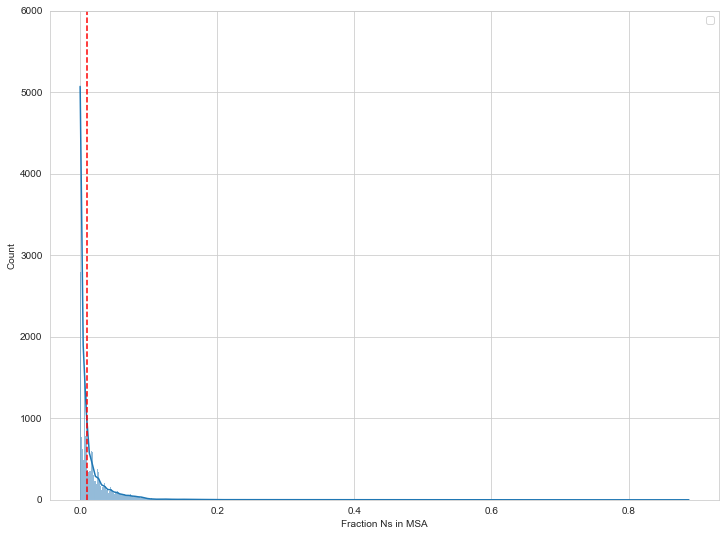

In [15]:
plt.figure(figsize=(12,9))
sns.histplot(strain_quals.frac_N, kde=True)
plt.ylim(0, 6000)
# ref_gaps = strain_gaps[strain_gaps.strain == ref].frac_gaps.values[0]
# plt.plot([ref_gaps, ref_gaps], [0, 10000], '--', c='k')
plt.plot([0.01, 0.01], [0, 6000],
         '--',
         c='r',)
plt.xlabel('Fraction Ns in MSA')
plt.legend()

## Set whitelist of strains with high sequence quality

Strains with < 1% Ns

Strains in the 95th percentile for gaps

Strains with Ns overlapping primer (consider Ns uninterpretible)

In [16]:
# # alternatively we could blacklist on deletions overlapping probes
# # fraction N
# whitelisted_strains = set(
#     strain_quals[strain_quals['frac_N'] < 0.01].strain)
# # >15nt deletions overlapping probes
# whitelisted_strains = whitelisted_strains.difference(
#     set(strain2probe_del.keys()))
# len(whitelisted_strains)
# # any Ns in oligo region
# whitelisted_strains = whitelisted_strains.difference(
#     set(strain2probe_n.keys()))
# len(whitelisted_strains)

In [17]:
# fraction N
whitelisted_strains = set(
    strain_quals[strain_quals['frac_N'] < 0.01].strain)
len(whitelisted_strains)
# fraction gaps
whitelisted_strains = whitelisted_strains.difference(
    set(strain_gaps[strain_gaps.frac_gaps >= quant_cutoff].strain))
# any Ns in oligo region
whitelisted_strains = whitelisted_strains.difference(
    set(strain2probe_n.keys()))
len(whitelisted_strains)

102202

In [18]:
# metadata = pd.read_csv("metadata_2020-10-12_07-15.tsv.gz", sep='\t')
# keep_cols = ['strain', 'region', 'country', 'length', 'date_submitted']
# # 'region_exposure', 'country_exposure', 'division_exposure', 
# metadata['in_msa'] = metadata.strain.apply(lambda x: bool(strain2probe_match[x]))
# metadata.drop(metadata[~metadata.in_msa].index, inplace=True)
# # metadata.drop(metadata[(metadata.length < (29791 - 125)) | 
# #                        (metadata.length > (29791 + 125))].index, inplace=True)
# metadata.drop([x for x in metadata.columns if x not in keep_cols], axis=1, inplace=True)
# metadata

## Count oligo mismatches for each whitelisted strain and put into a dataframe

Need to know probe lengths (and summed lengths per assay) to quickly calculate total number of mismatches + gaps

In [19]:
probe_lengths = dict((k, len(v.seq)) for k, v in probes.items())
probe_lengths

{'E_Sarbeco-F1': 26,
 'E_Sarbeco-R2': 22,
 'E_Sarbeco-P1': 26,
 'RdRp_SARSr-F2': 22,
 'RdRp_SARSr-R1': 26,
 'RdRp_SARSr-P2': 25,
 '2019-nCoV_N1-F': 20,
 '2019-nCoV_N1-R': 24,
 '2019-nCoV_N1-P': 24,
 '2019-nCoV_N2-F': 20,
 '2019-nCoV_N2-R': 18,
 '2019-nCoV_N2-P': 23,
 'M-475-F': 20,
 'M-574-R': 20,
 'M-507-P': 20,
 'S-Gene-F': 22,
 'S-Gene-R': 22,
 'S-Gene-P': 24}

In [20]:
assay_lengths = defaultdict(int)
for k, v in probe_lengths.items():
    assay = primer_to_assay(k)
    assay_lengths[assay] += v
assay_lengths

defaultdict(int,
            {'E_Sarbeco': 74,
             'RdRp_SARSr': 73,
             '2019-nCoV_N1': 68,
             '2019-nCoV_N2': 61,
             'M-XXX': 60,
             'S-Gene': 68})

## Create dataframe recording mismatch types for each strain

In [21]:
probe_diffs = defaultdict(list)
for strain, probe_dict in strain2probe_match.items():
    for probe, match_dict in probe_dict.items():
        probe_diffs['strain'].append(strain)
        probe_diffs['oligo'].append(probe)
        probe_diffs['assay'].append(primer_to_assay(probe))
        probe_diffs['primer'].append(primer_to_probe_type(probe))
        probe_diffs['length'].append(probe_lengths[probe])
        for k, v in match_dict.items():
            probe_diffs[k].append(v)
probe_diffs = pd.DataFrame.from_dict(probe_diffs)
probe_diffs.head()

,strain,oligo,assay,primer,length,match,mismatch,deletion,insertion
0,Wuhan/WIV04/2019,E_Sarbeco-F1,E_Sarbeco,F,26,26,0,0,0
1,Wuhan/WIV04/2019,E_Sarbeco-R2,E_Sarbeco,R,22,22,0,0,0
2,Wuhan/WIV04/2019,E_Sarbeco-P1,E_Sarbeco,P,26,26,0,0,0
3,Wuhan/WIV04/2019,RdRp_SARSr-F2,RdRp_SARSr,F,22,22,0,0,0
4,Wuhan/WIV04/2019,RdRp_SARSr-R1,RdRp_SARSr,R,26,25,1,0,0


Quickly summarize total differences as length oligo - matches

In [22]:
probe_diffs['differences'] = probe_diffs.apply(lambda x: x.length - x.match, axis=1)
probe_diffs.head()

,strain,oligo,assay,primer,length,match,mismatch,deletion,insertion,differences
0,Wuhan/WIV04/2019,E_Sarbeco-F1,E_Sarbeco,F,26,26,0,0,0,0
1,Wuhan/WIV04/2019,E_Sarbeco-R2,E_Sarbeco,R,22,22,0,0,0,0
2,Wuhan/WIV04/2019,E_Sarbeco-P1,E_Sarbeco,P,26,26,0,0,0,0
3,Wuhan/WIV04/2019,RdRp_SARSr-F2,RdRp_SARSr,F,22,22,0,0,0,0
4,Wuhan/WIV04/2019,RdRp_SARSr-R1,RdRp_SARSr,R,26,25,1,0,0,1


aggregate differences by assay

In [23]:
assay_diffs = probe_diffs.groupby(['strain', 'assay']).agg(
    {'match': np.sum,
     'mismatch': np.sum,
     'deletion': np.sum,
     'insertion': np.sum,
     'length': np.sum,
     'differences': np.sum}).reset_index()
assay_diffs.head()

,strain,assay,match,mismatch,deletion,insertion,length,differences
0,Algeria/G0638_2264/2020,2019-nCoV_N1,68,0,0,0,68,0
1,Algeria/G0638_2264/2020,2019-nCoV_N2,61,0,0,0,61,0
2,Algeria/G0638_2264/2020,E_Sarbeco,74,0,0,0,74,0
3,Algeria/G0638_2264/2020,M-XXX,60,0,0,0,60,0
4,Algeria/G0638_2264/2020,RdRp_SARSr,72,1,0,0,73,1


In [24]:
assay_diffs.deletion.sum()

3519

In [25]:
assay_diffs.insertion.sum()

0

### Write summary CSVs for each category of mismatch

In [26]:
import pathlib

for csvdir in ['per_oligo', 'per_assay']:
    for csvdir2 in ['binned', 'binary']:
        for csvdir3 in ['all_strains', 'high_qual']:
            path = pathlib.Path("output/{}/{}/{}/plots".format(csvdir, csvdir2, csvdir3))
            path.mkdir(parents=True, exist_ok=True)

In [27]:
def probe_diffs_to_binned_csv(df, category, csv=None, level='oligo', bin_col_name=None):
    if bin_col_name is None:
        bin_col_name = 'binned_{}'.format(category)
    df[bin_col_name] = df[category].apply(lambda x: str(x) if x < 3 else '>2' )
    tmp_df = pd.DataFrame.from_dict(df.value_counts(subset=[level, bin_col_name]).sort_index())
    tmp_df.columns = ['Count']
    freqs = []
    for idx in tmp_df.index:
        freqs.append(tmp_df.loc[idx][0]/tmp_df.loc[idx[0]].sum()[0])
    tmp_df['Frequency'] = freqs
    if csv:
        tmp_df.to_csv(csv)
    df.drop(bin_col_name, axis=1)
    return tmp_df

In [28]:
def probe_diffs_to_binary_diff_csv(df, category, csv=None, level='oligo', bin_col_name=None):
    if bin_col_name is None:
        bin_col_name = 'any_{}'.format(category)
    df.loc[:, bin_col_name] = df[category] > 0 
    tmp_df = pd.DataFrame.from_dict(df.value_counts(subset=[level, bin_col_name]).sort_index())
    tmp_df.columns = ['Count']
    freqs = []
    for idx in tmp_df.index:
        freqs.append(tmp_df.loc[idx][0]/tmp_df.loc[idx[0]].sum()[0])
    tmp_df['Frequency'] = freqs
    if csv:
        tmp_df.to_csv(csv)
    df.drop(bin_col_name, axis=1)
    return tmp_df

Write binned summaries of oligo mismatches for all strains and whitelisted strains and create plots

We create plots with and without 'RdRp_SARSr-R1' as this oligo has a mismatch in ~all strains and skews the Y-axis

<ipython-input-27-84d83201c2d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[bin_col_name] = df[category].apply(lambda x: str(x) if x < 3 else '>2' )
<ipython-input-27-84d83201c2d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[bin_col_name] = df[category].apply(lambda x: str(x) if x < 3 else '>2' )
<ipython-input-27-84d83201c2d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

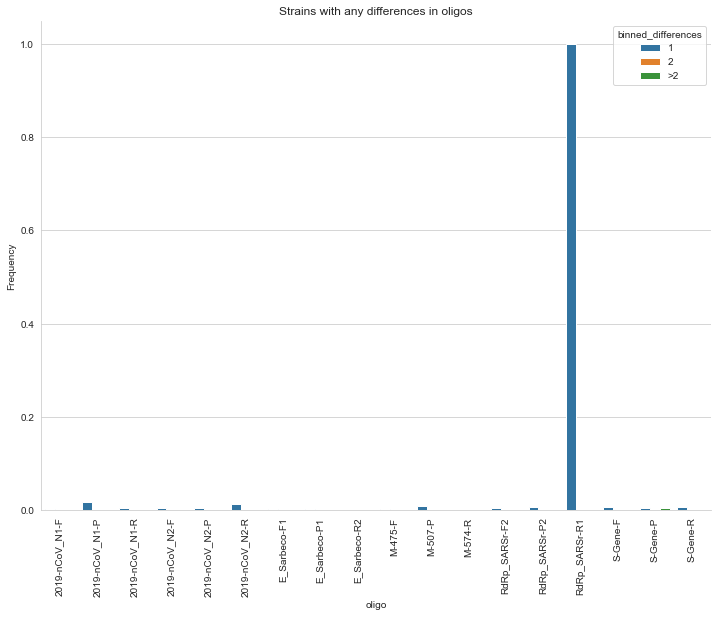

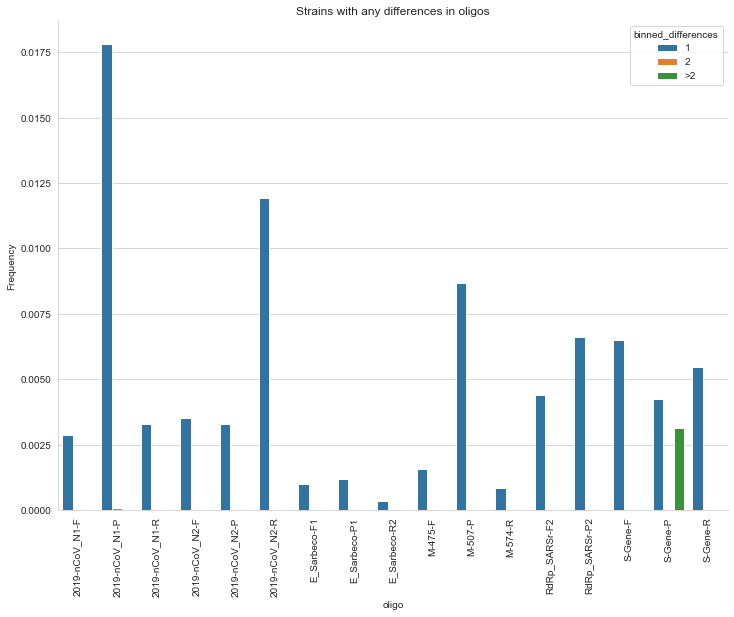

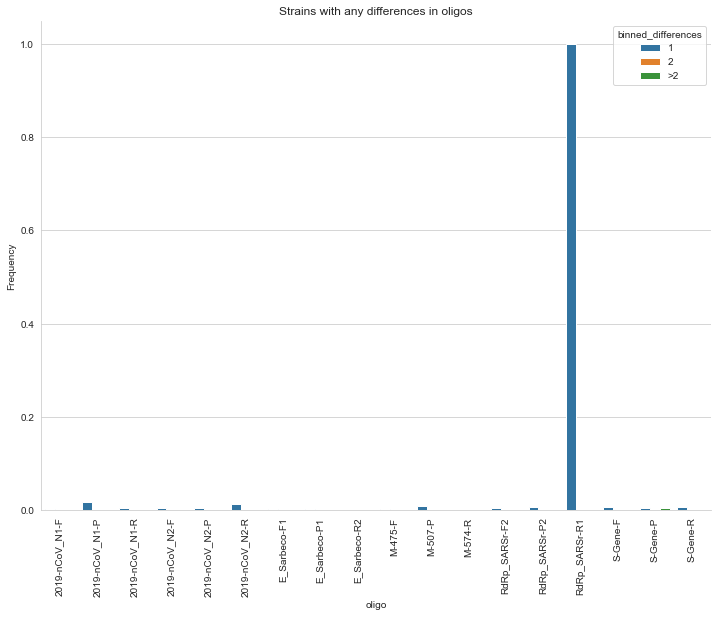

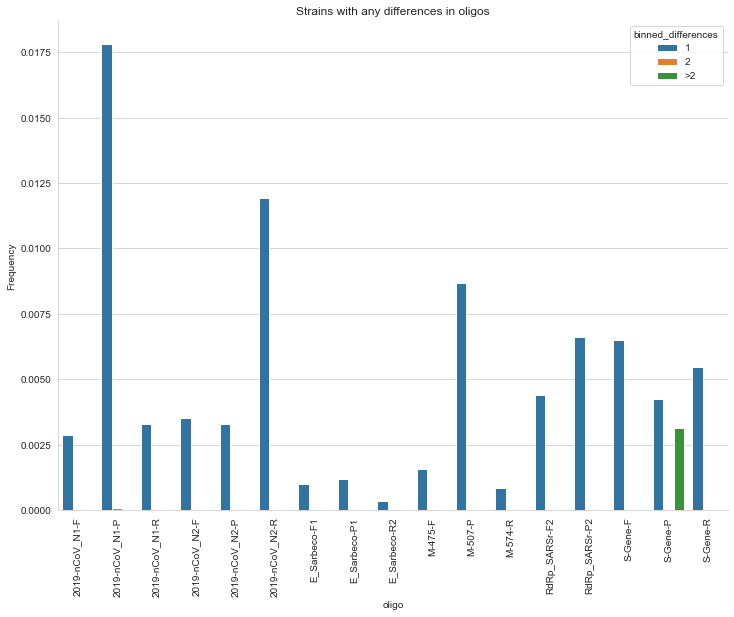

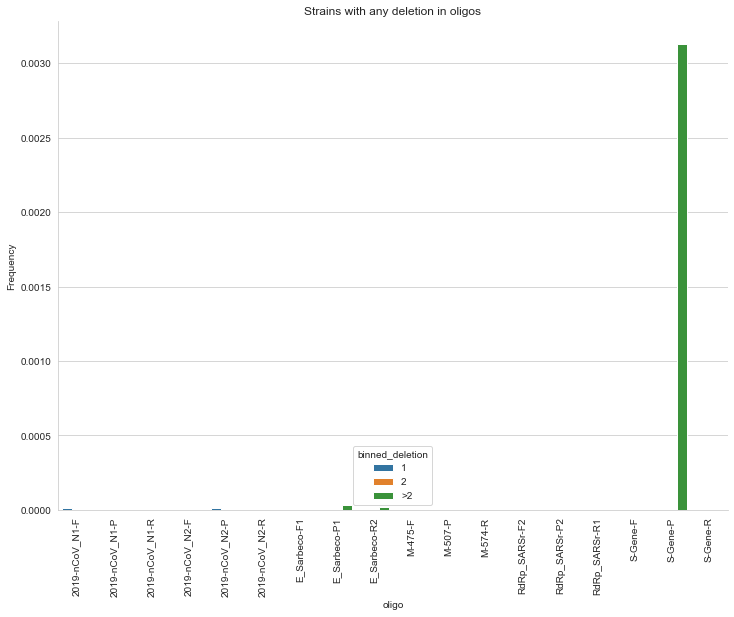

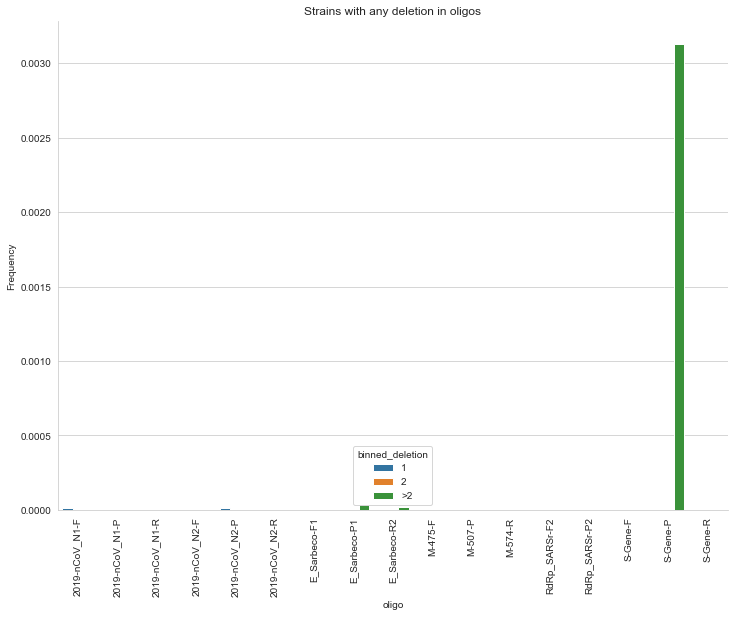

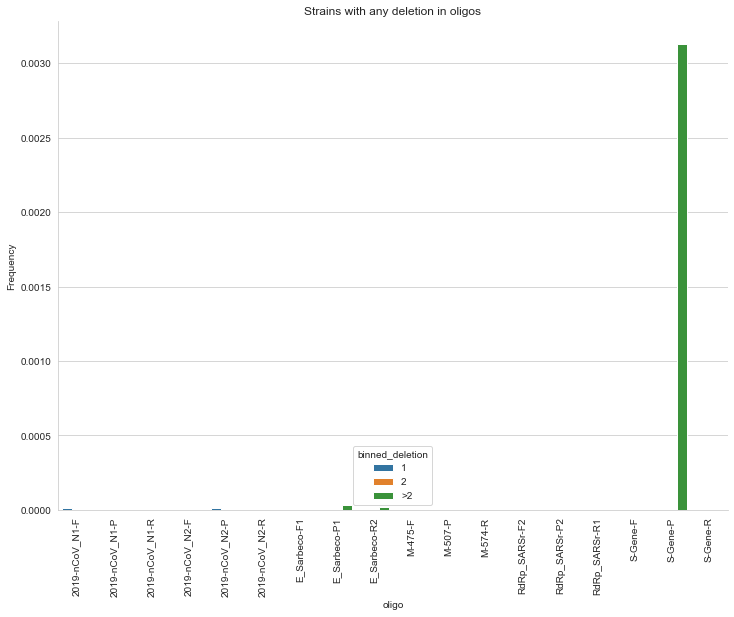

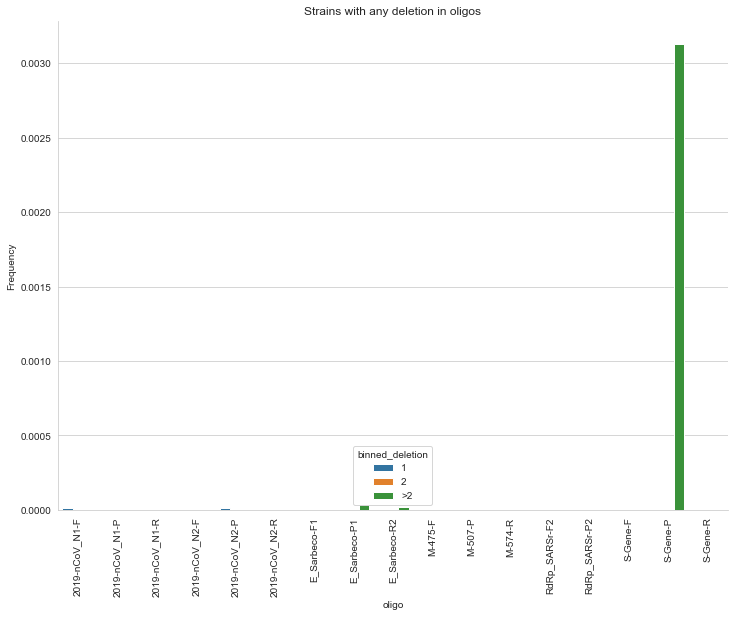

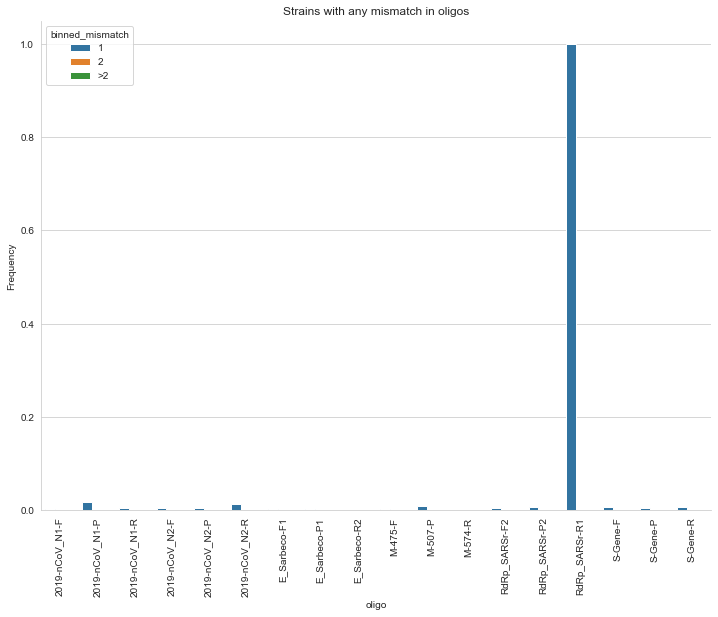

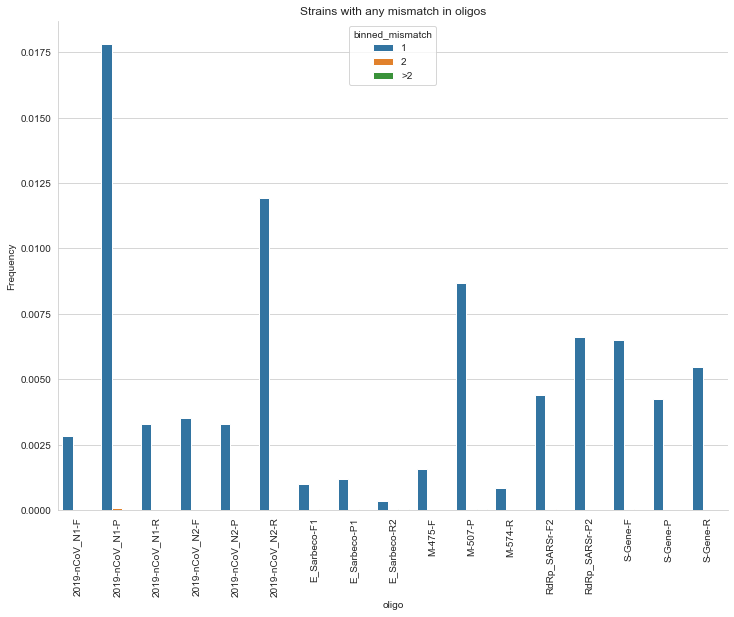

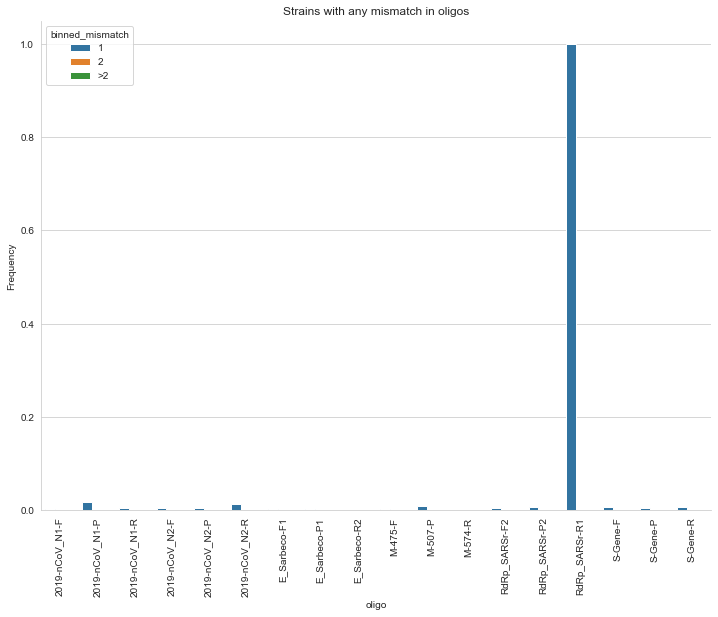

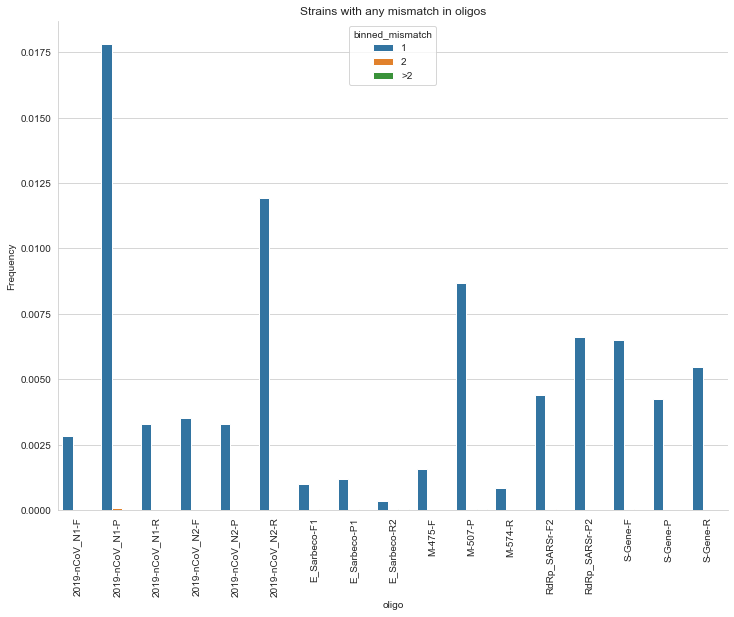

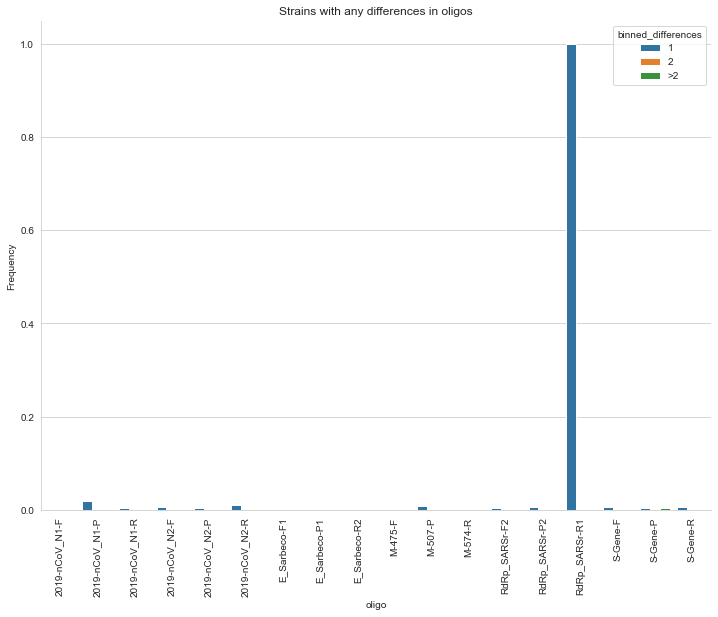

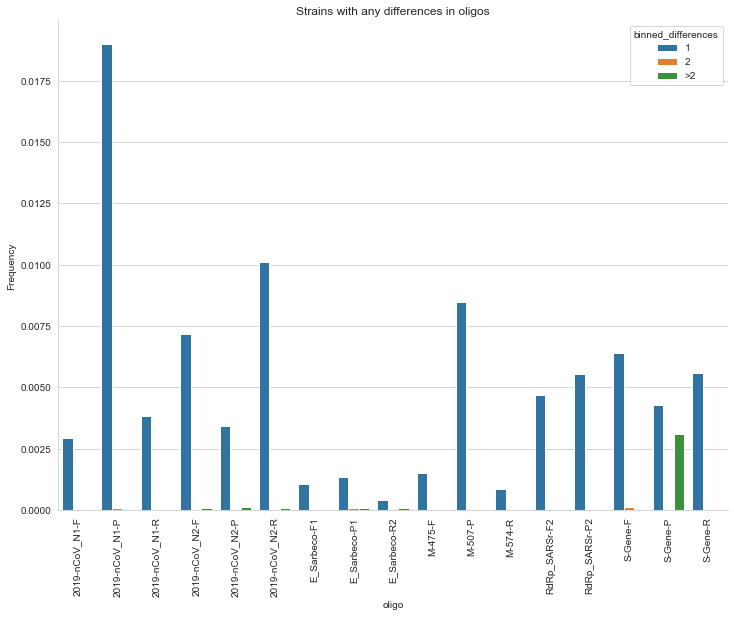

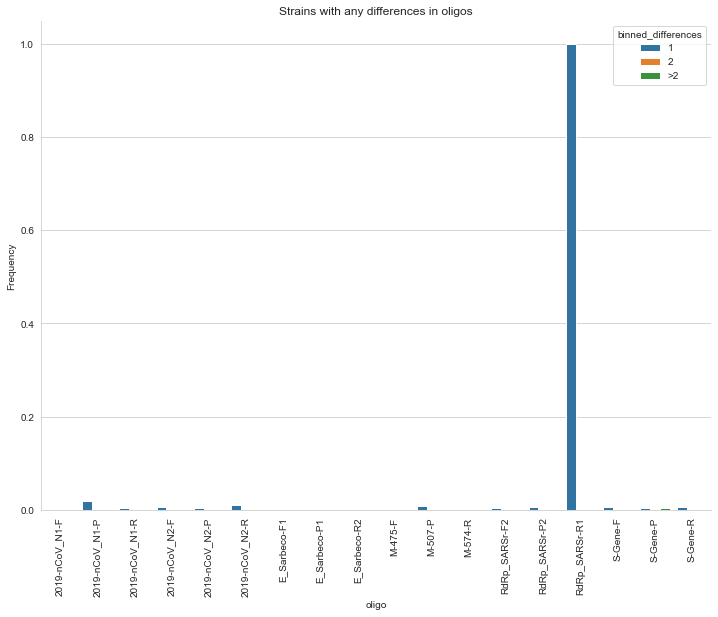

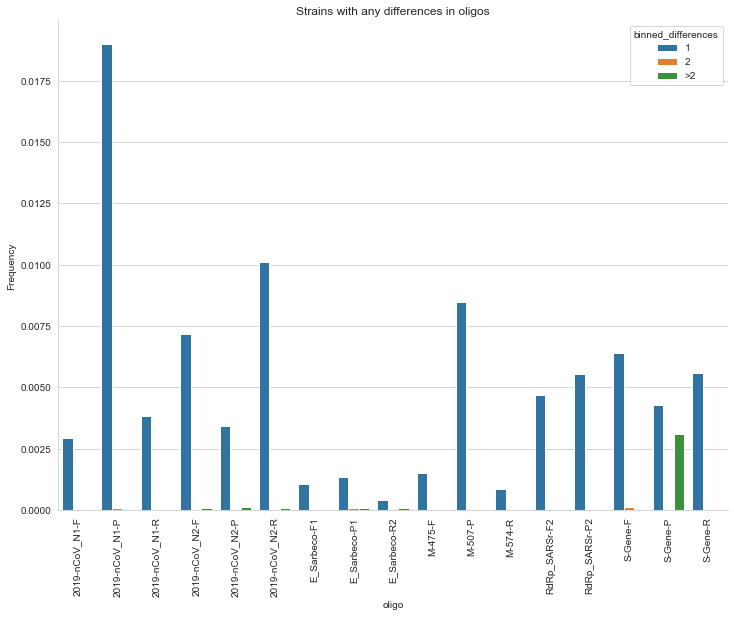

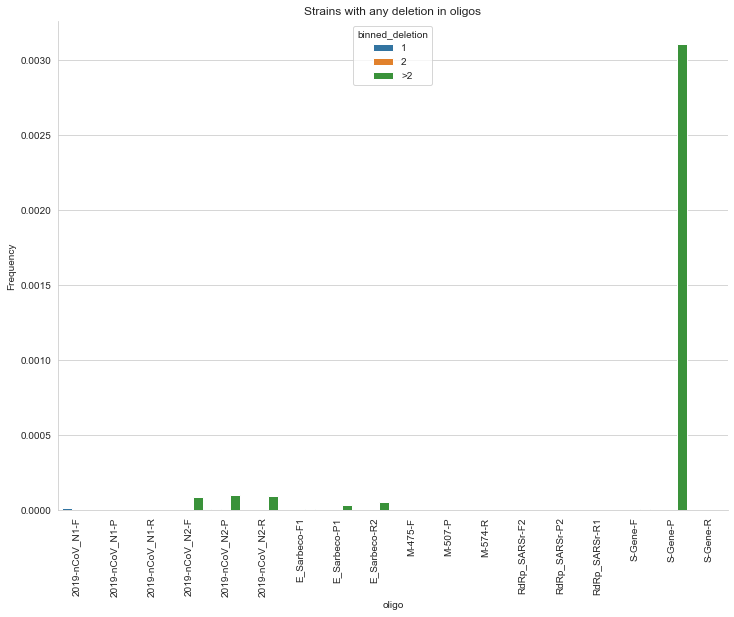

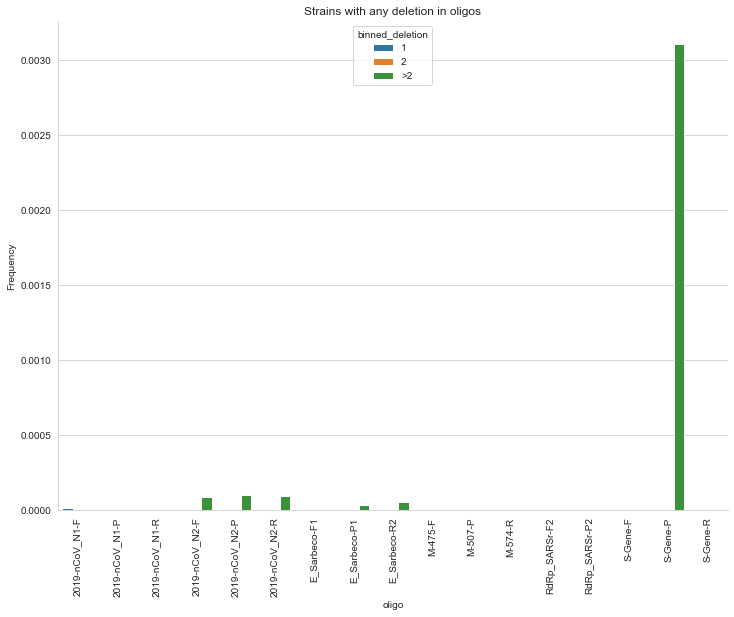

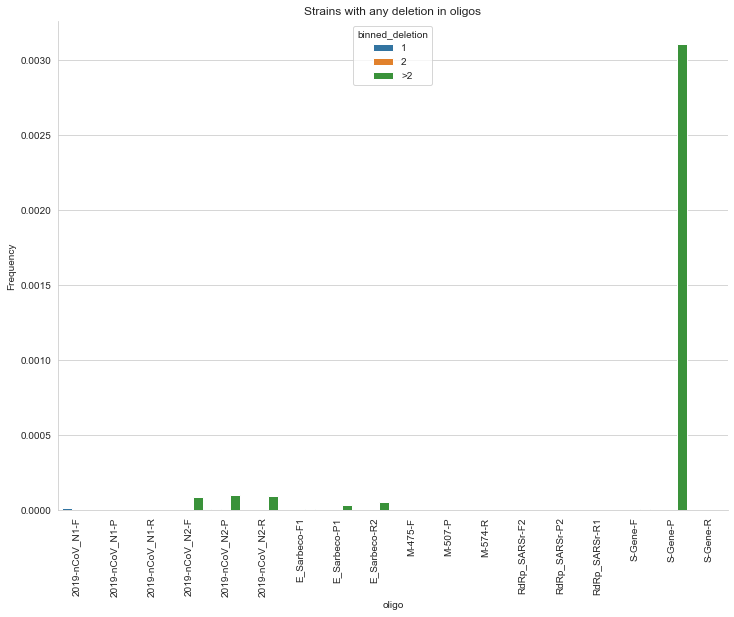

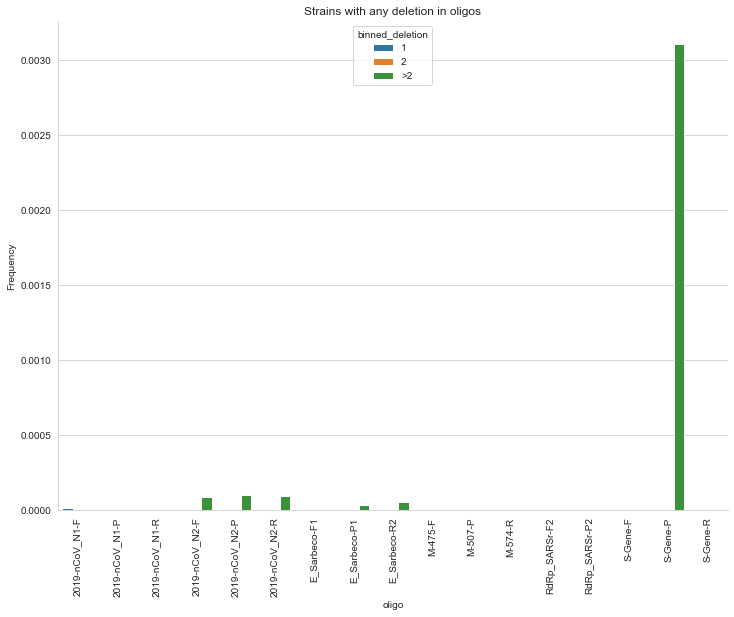

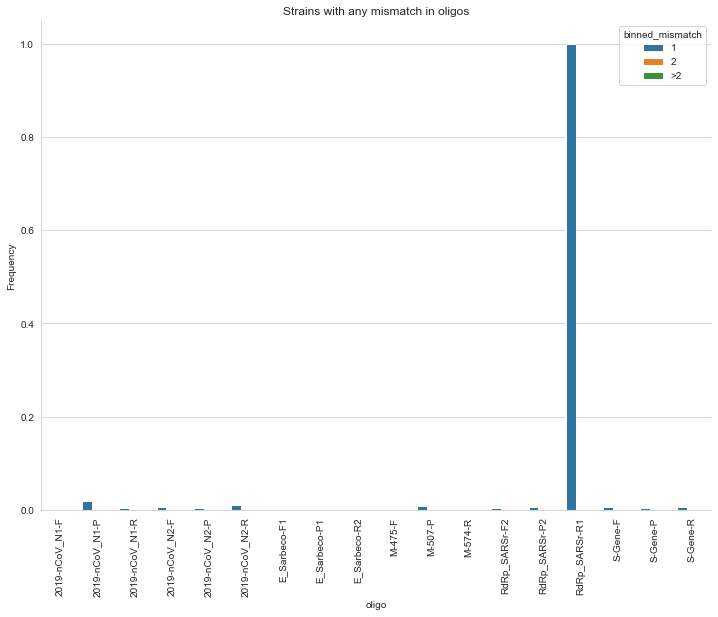

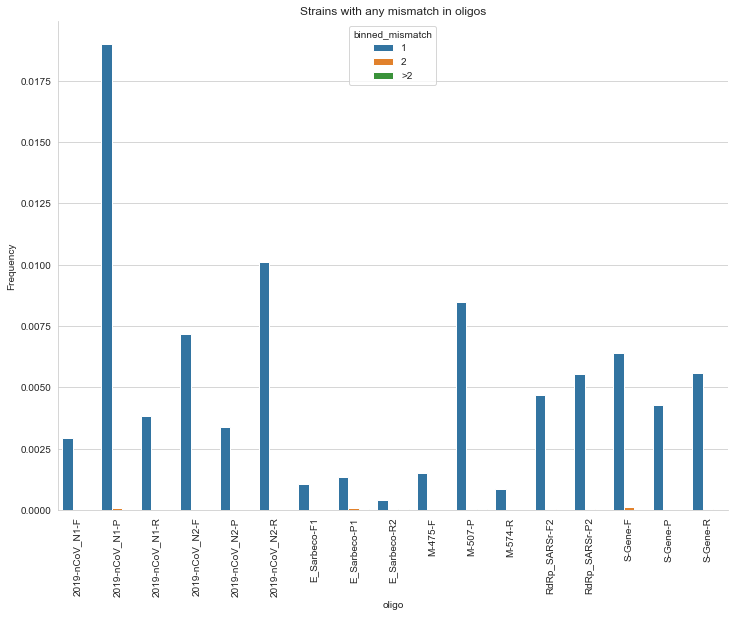

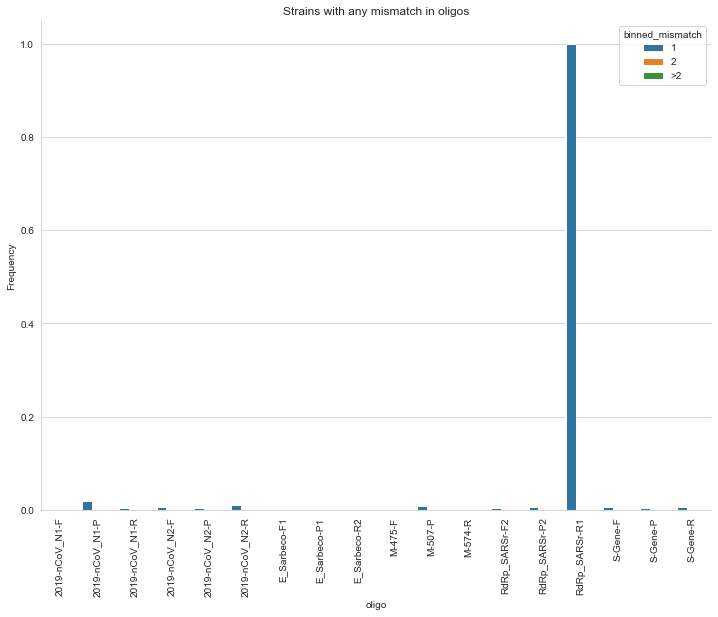

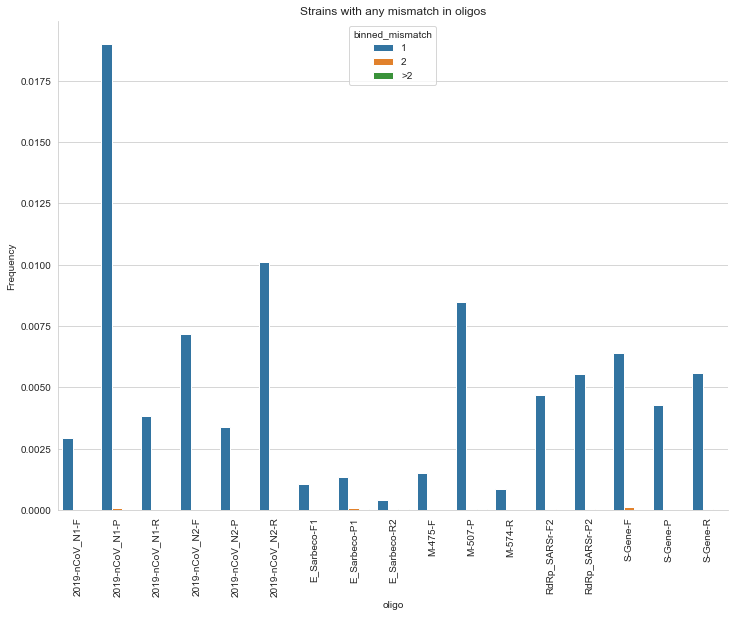

In [29]:
hq_probe_diffs = probe_diffs[probe_diffs.strain.isin(whitelisted_strains)]
oligo_order = sorted(list(hq_probe_diffs.oligo.unique()))
for df, pdir in zip([hq_probe_diffs, probe_diffs], ['high_qual', 'all_strains']):
    for category in ['differences', 'deletion', 'mismatch']:
        csvdir = "output/per_oligo/binned/{}".format(pdir)
        prefix = '{}_binned'.format(category)
        tmp_df = probe_diffs_to_binned_csv(df,
                                           category=category,
                                           csv="{}/{}_summary.csv".format(csvdir, prefix))
        tmp_df.reset_index(inplace=True)
        for col in ['Count', 'Frequency']:
            plt.figure(figsize=(12,9))
            sns.barplot(data=tmp_df[(tmp_df["binned_{}".format(category)] != '0')],
                        y='Frequency',
                        hue='binned_{}'.format(category),
                        order=oligo_order,
                        hue_order=['1', '2', '>2'],
                        x='oligo')
            plt.title("Strains with any {} in oligos".format(category))
            plt.xticks(rotation=90)
            sns.despine()
            plt.savefig(csvdir + '/plots/{}_{}.pdf'.format(prefix, col))
            plt.figure(figsize=(12,9))
            sns.barplot(data=tmp_df[(tmp_df["binned_{}".format(category)] != '0') & 
                                    (tmp_df.oligo != 'RdRp_SARSr-R1')],
                        y='Frequency',
                        hue='binned_{}'.format(category),
                        order=[x for x in oligo_order if x != 'RdRp_SARSr-R1'],
                        hue_order=['1', '2', '>2'],
                        x='oligo')
            plt.title("Strains with any {} in oligos".format(category))
            plt.xticks(rotation=90)
            sns.despine()
            plt.savefig(csvdir + '/plots/{}_{}_no_RdRp_SARSr-R1.pdf'.format(prefix, col))

As above but per-assay rather than per oligo

<ipython-input-27-84d83201c2d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[bin_col_name] = df[category].apply(lambda x: str(x) if x < 3 else '>2' )
<ipython-input-27-84d83201c2d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[bin_col_name] = df[category].apply(lambda x: str(x) if x < 3 else '>2' )
<ipython-input-27-84d83201c2d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

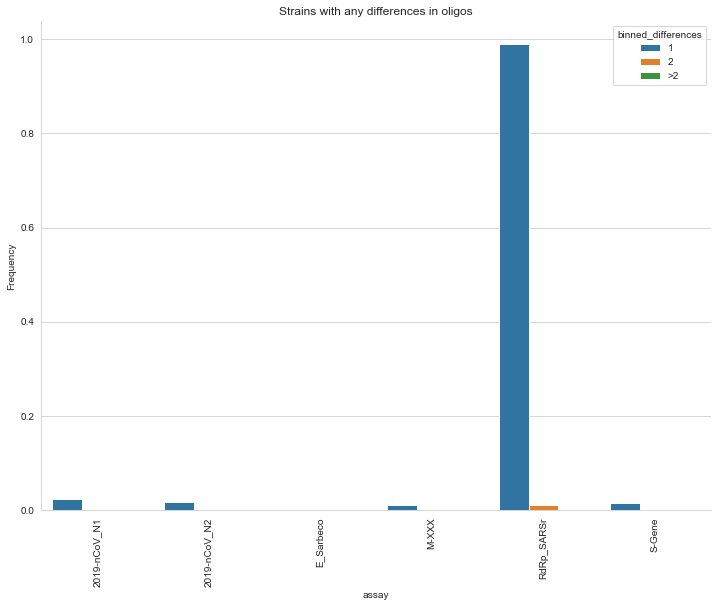

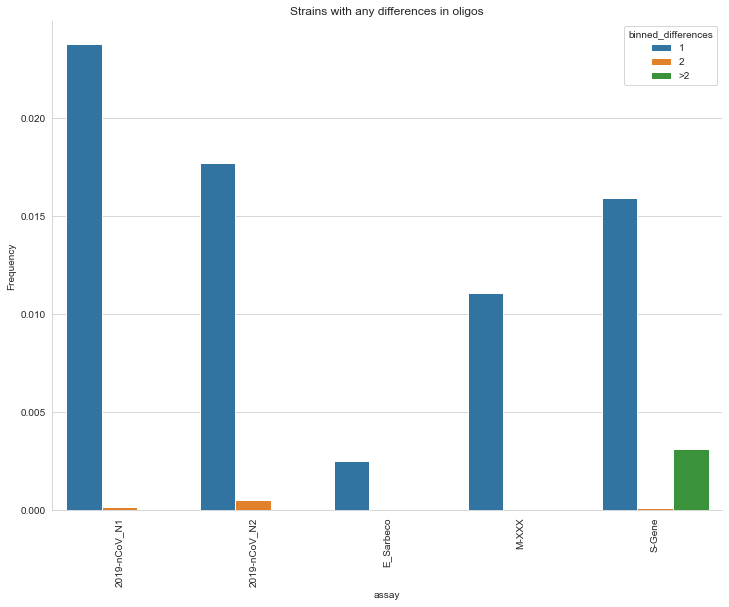

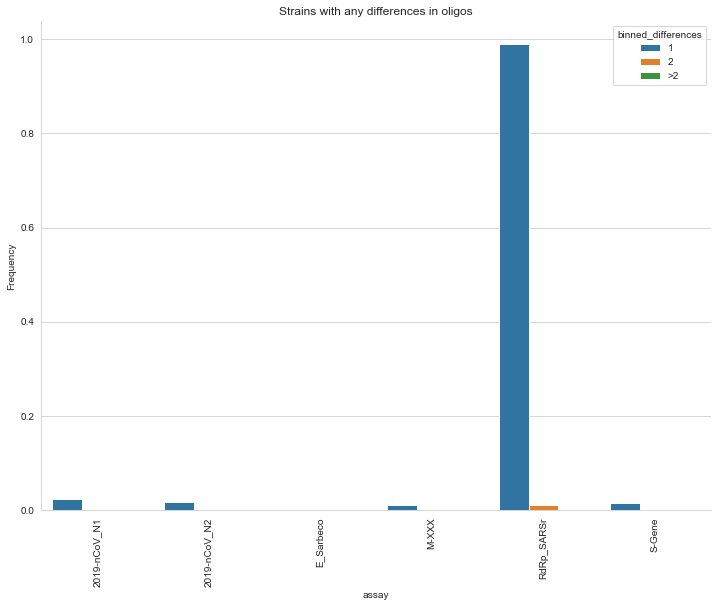

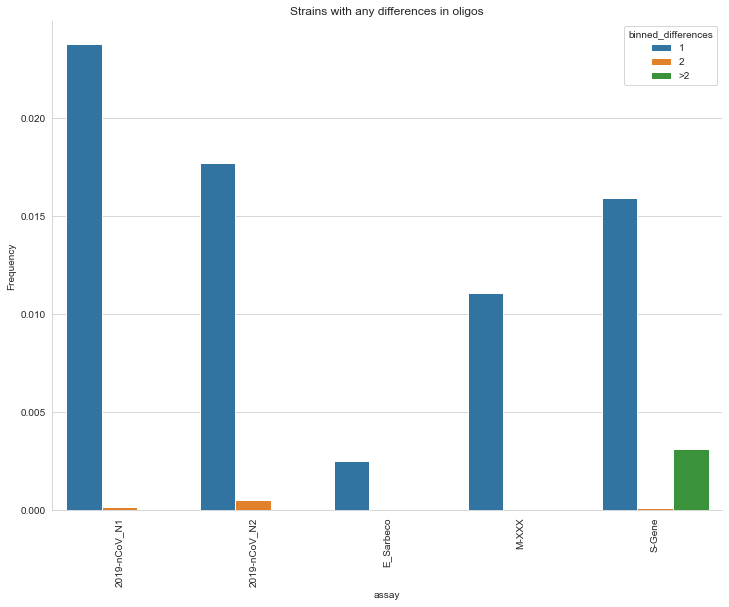

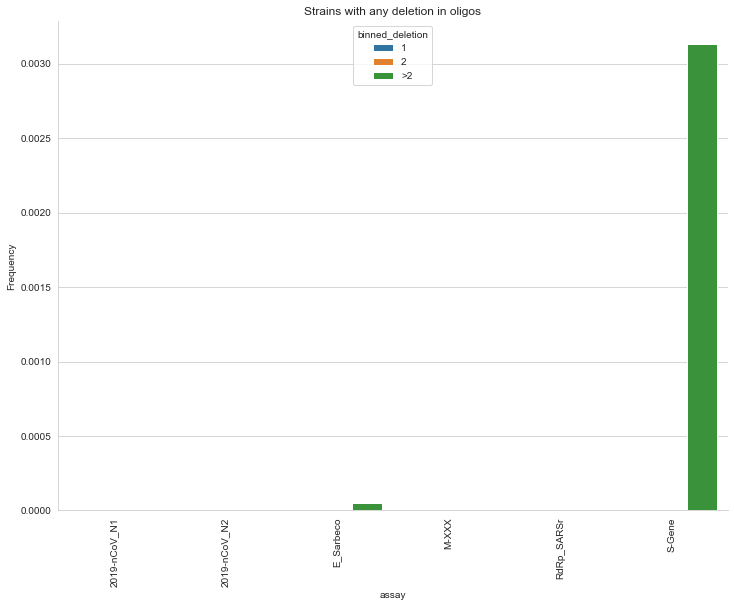

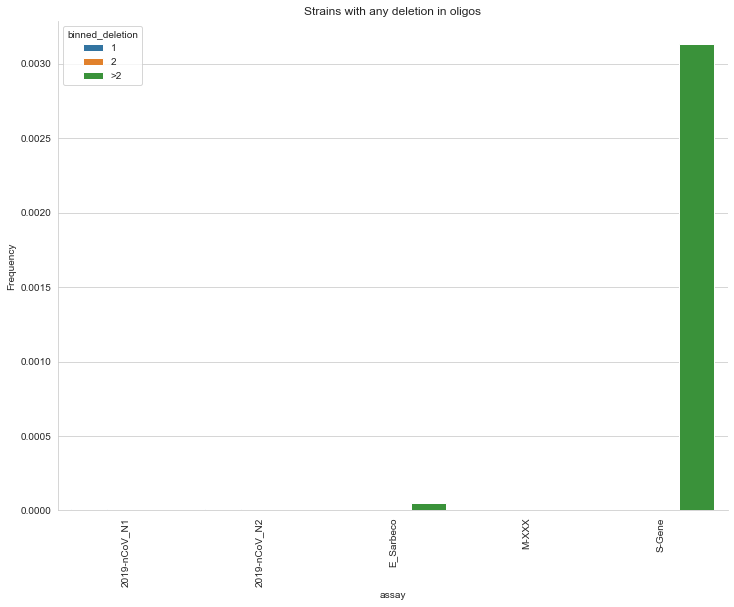

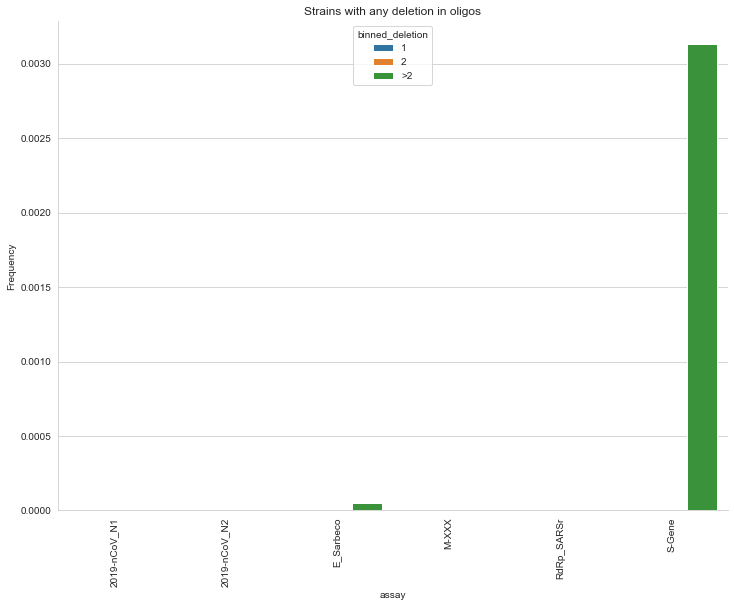

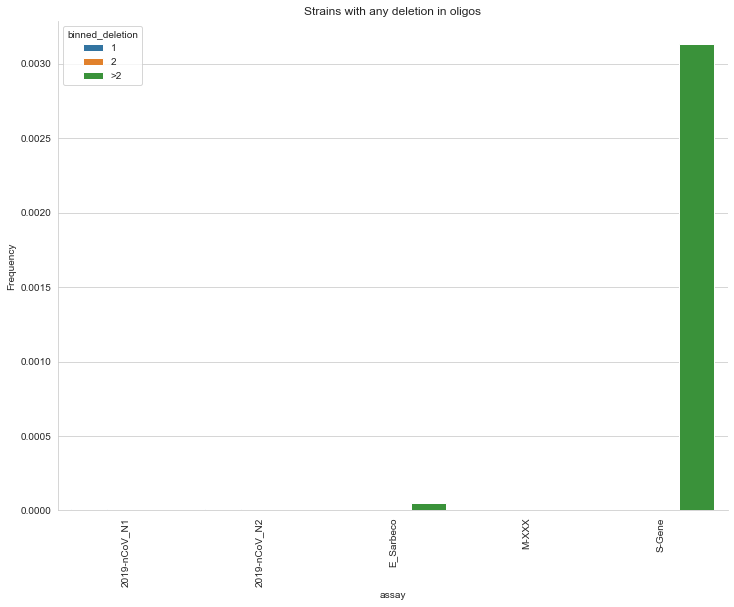

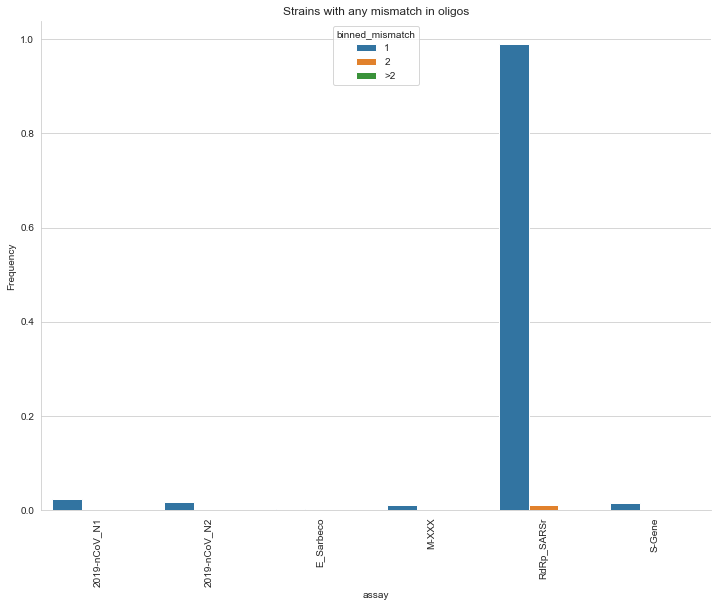

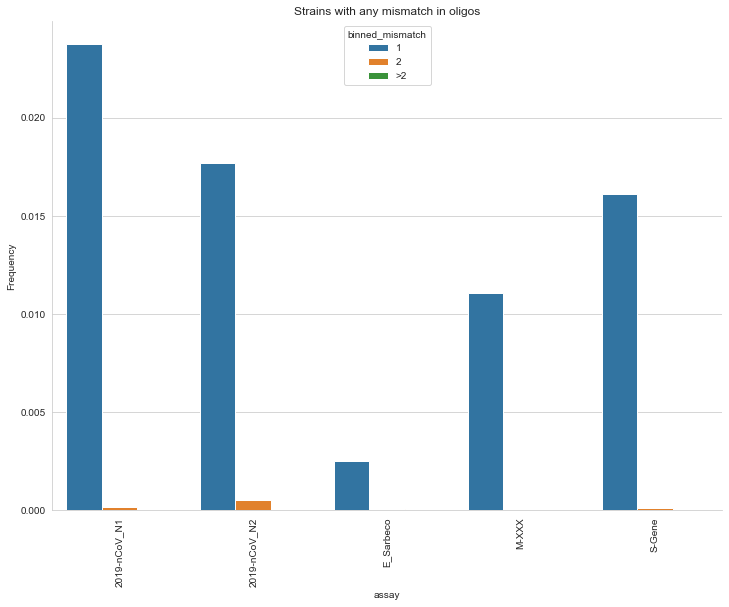

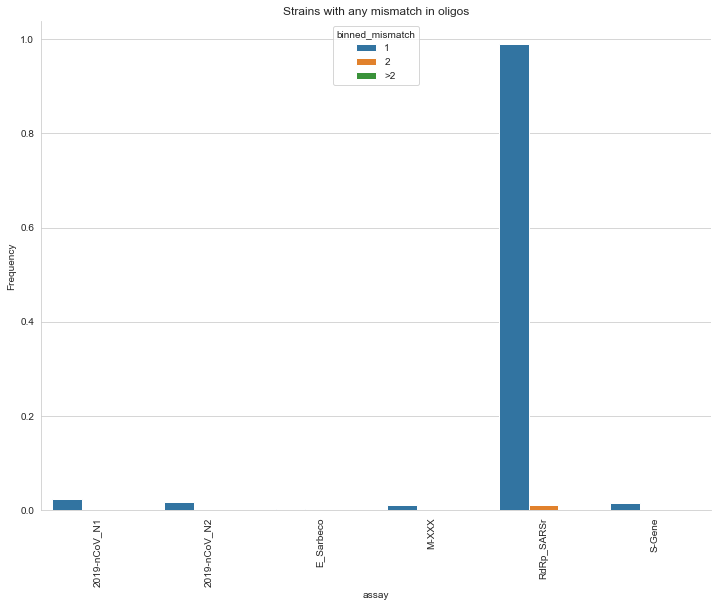

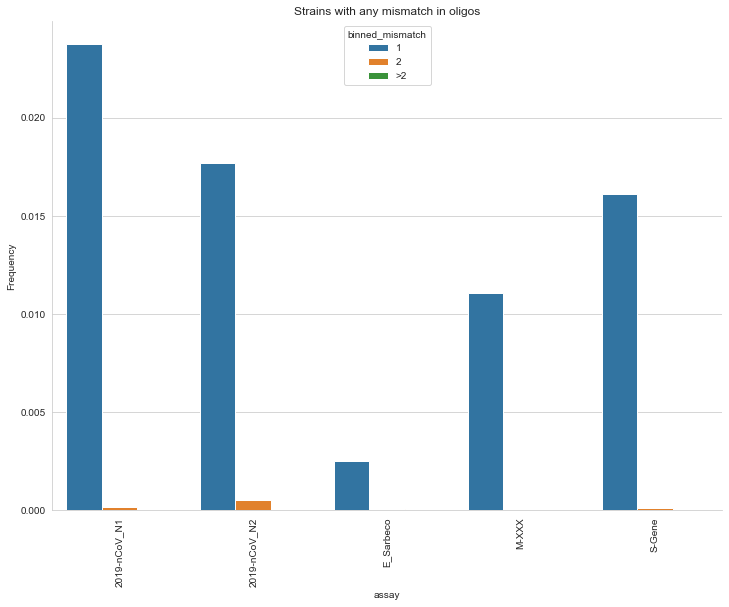

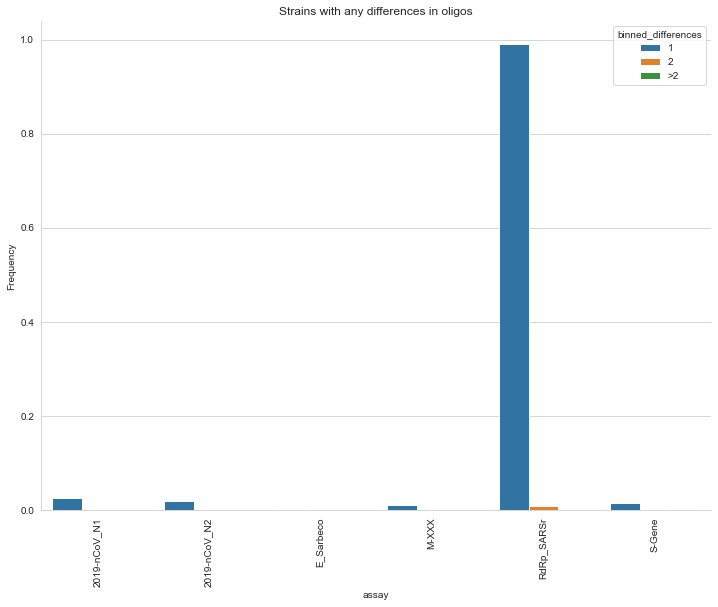

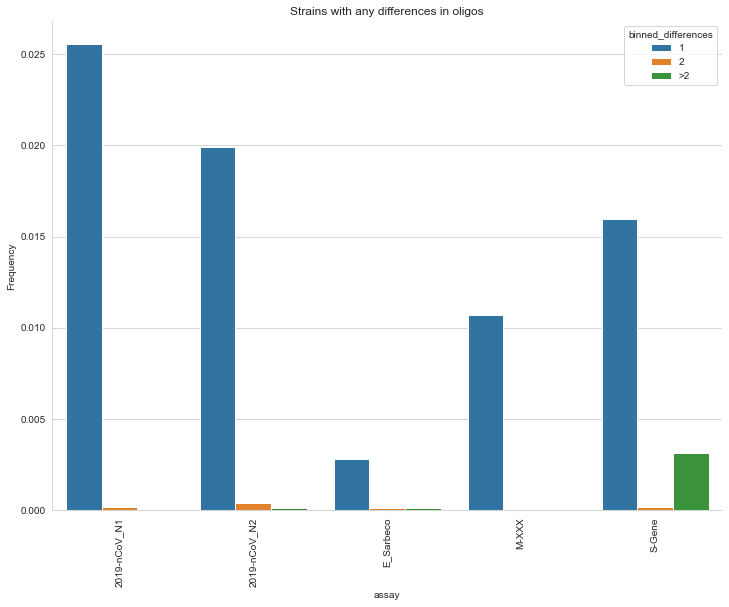

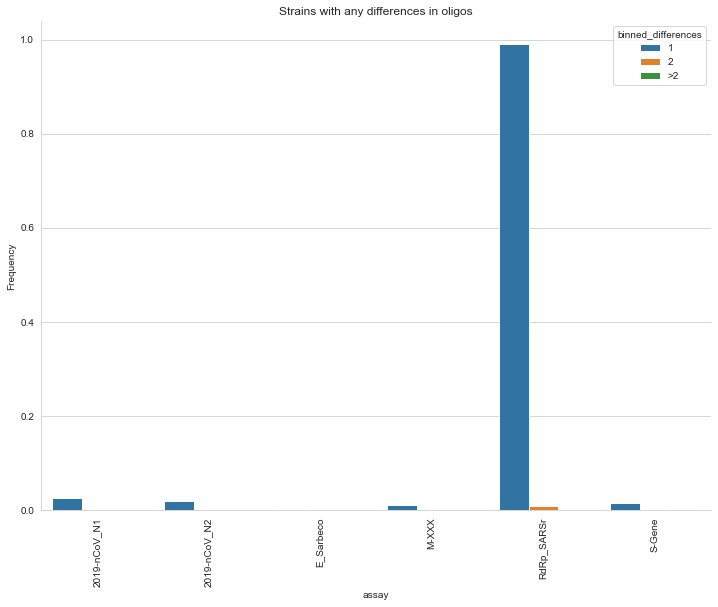

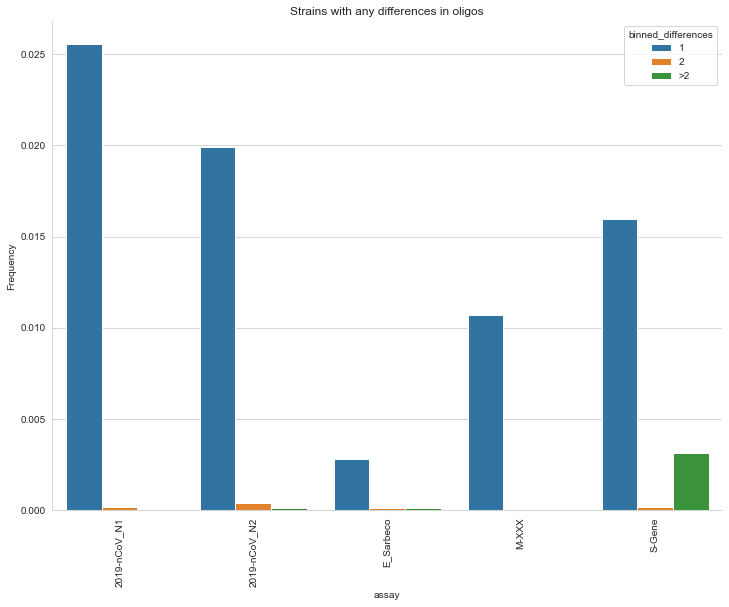

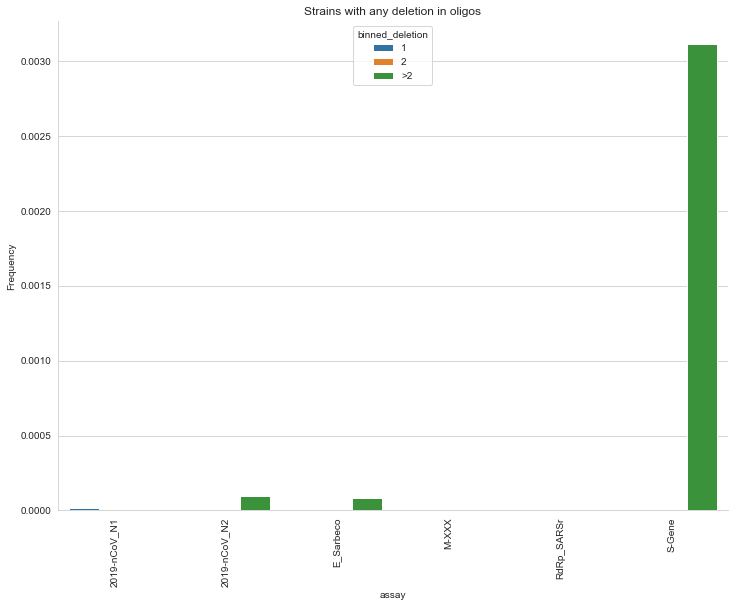

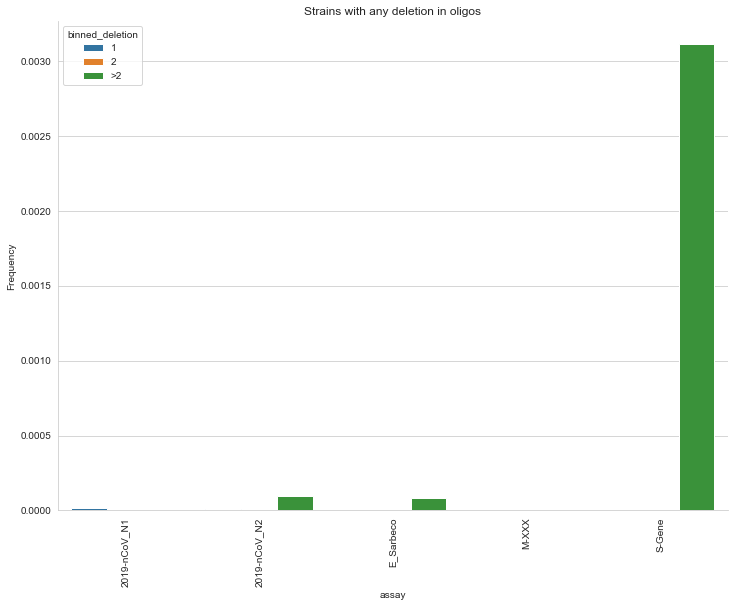

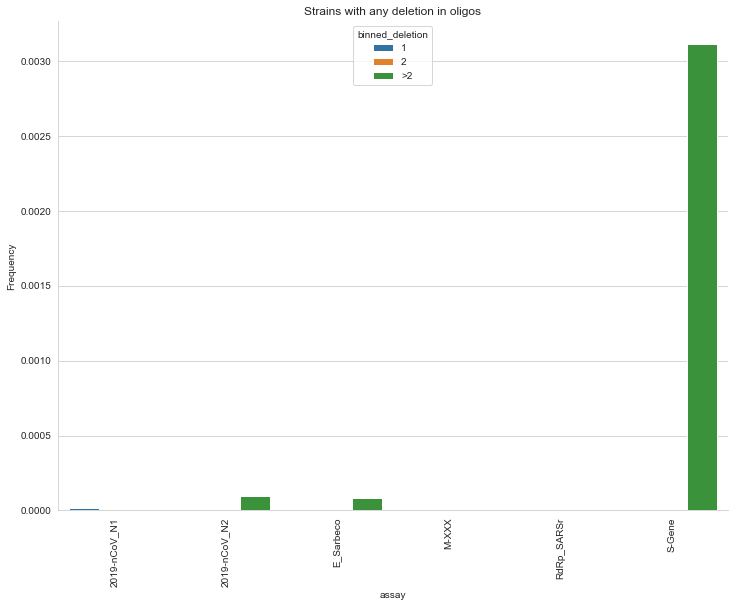

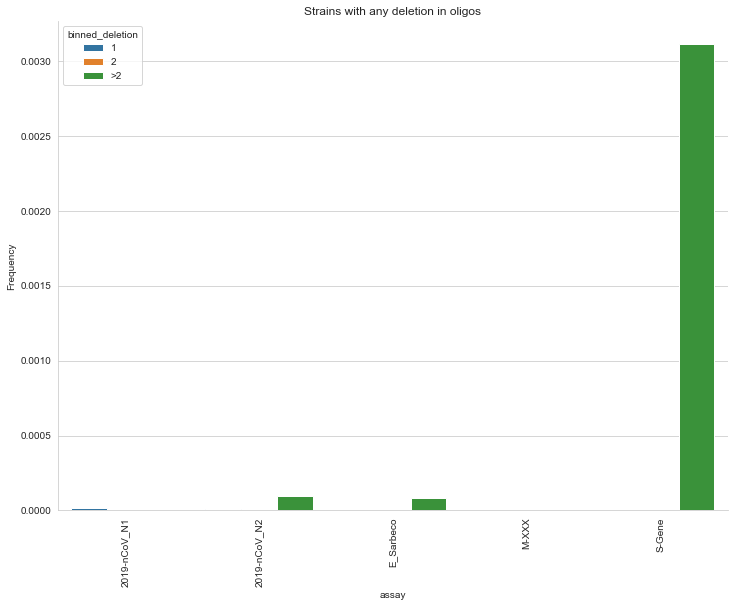

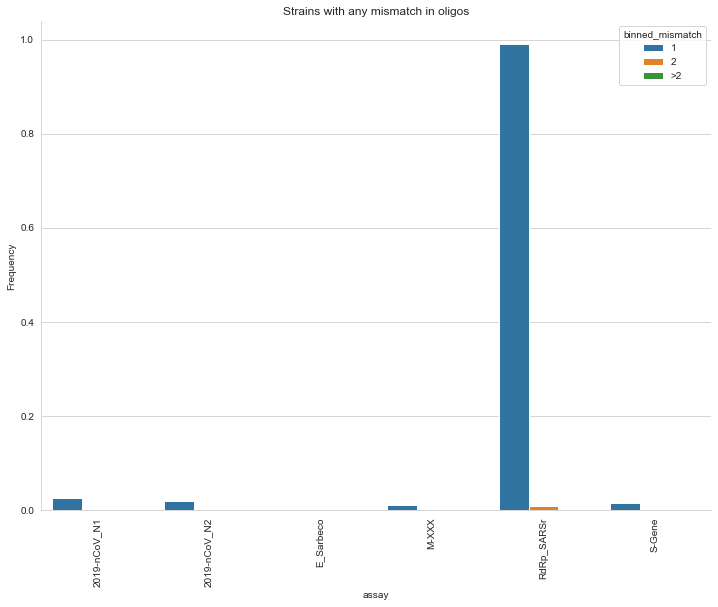

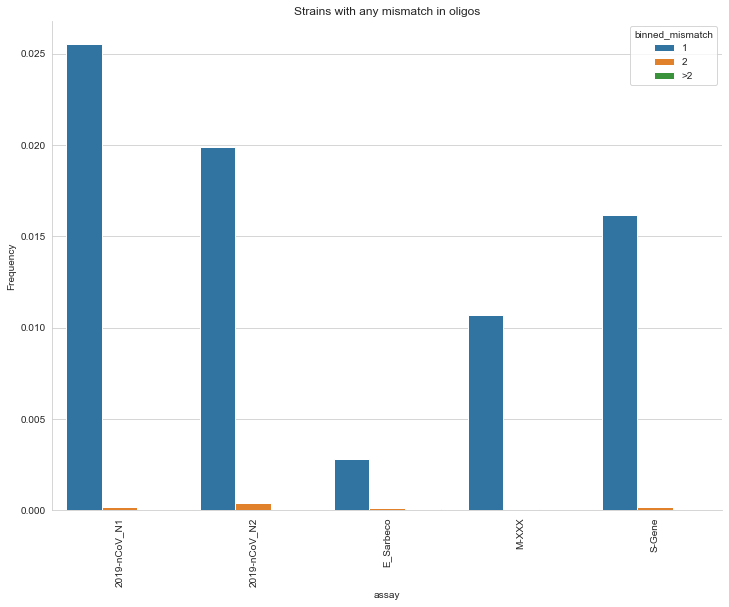

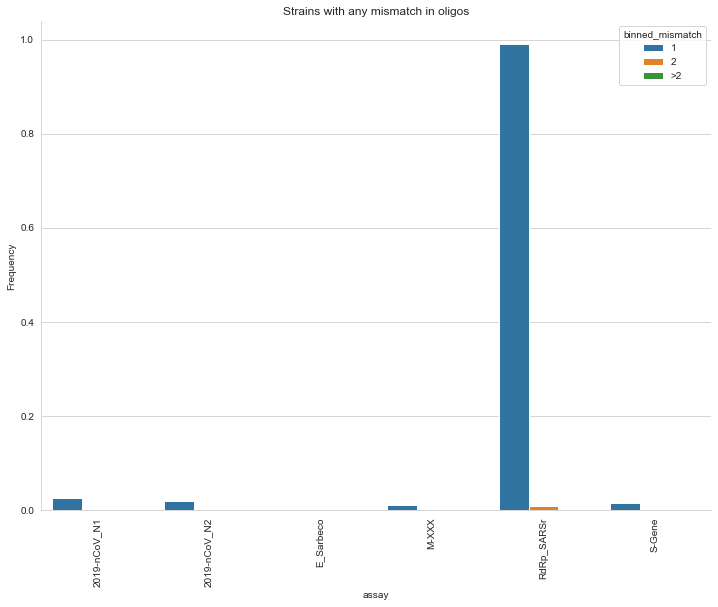

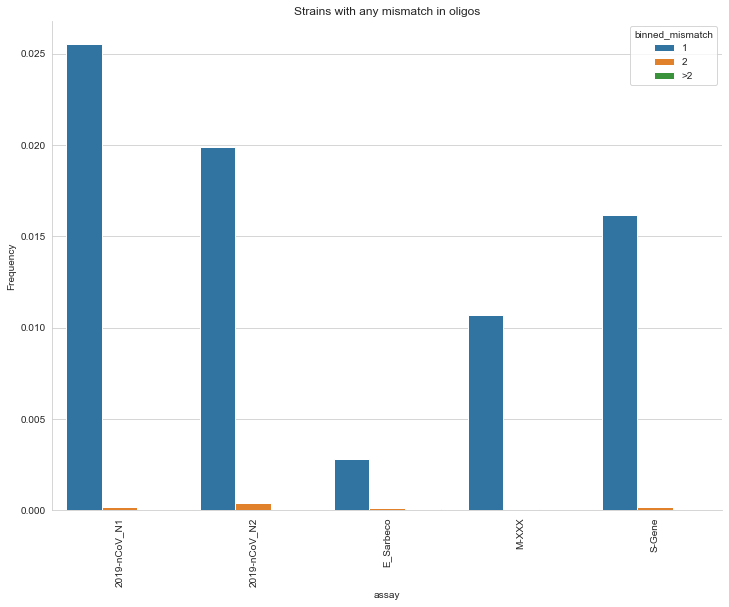

In [30]:
assay_order = sorted(list(hq_probe_diffs.assay.unique()))
hq_assay_diffs = assay_diffs[assay_diffs.strain.isin(whitelisted_strains)]
for df, pdir in zip([hq_assay_diffs, assay_diffs], ['high_qual', 'all_strains']):
    for category in ['differences', 'deletion', 'mismatch']:
        csvdir = "output/per_assay/binned/{}".format(pdir)
        prefix = '{}_binned'.format(category)
        tmp_df = probe_diffs_to_binned_csv(df,
                                           category=category,
                                           level='assay',
                                           csv="{}/{}_summary.csv".format(csvdir, prefix))
        tmp_df.reset_index(inplace=True)
        for col in ['Count', 'Frequency']:
            plt.figure(figsize=(12,9))
            sns.barplot(data=tmp_df[(tmp_df["binned_{}".format(category)] != '0')],
                        y='Frequency',
                        hue='binned_{}'.format(category),
                        order=assay_order,
                        hue_order=['1', '2', '>2'],
                        x='assay')
            plt.title("Strains with any {} in oligos".format(category))
            plt.xticks(rotation=90)
            sns.despine()
            plt.savefig(csvdir + '/plots/{}_{}.pdf'.format(prefix, col))
            plt.figure(figsize=(12,9))
            sns.barplot(data=tmp_df[(tmp_df["binned_{}".format(category)] != '0') & 
                                    (tmp_df.assay != 'RdRp_SARSr-R1')],
                        y='Frequency',
                        hue='binned_{}'.format(category),
                        order=[x for x in assay_order if x != 'RdRp_SARSr'],
                        hue_order=['1', '2', '>2'],
                        x='assay')
            plt.title("Strains with any {} in oligos".format(category))
            plt.xticks(rotation=90)
            sns.despine()
            plt.savefig(csvdir + '/plots/{}_{}_no_RdRp_SARSr.pdf'.format(prefix, col))
            
# for category in ['differences', 'deletion', 'mismatch']:
#     probe_diffs_to_binned_csv(hq_assay_diffs,
#                               category=category,
#                               level='assay',
#                               csv="output/per_assay/binned/high_qual/{}_binned_summary.csv".format(category))
#     probe_diffs_to_binned_csv(assay_diffs,
#                               category=category,
#                               level='assay',
#                               csv="output/per_assay/binned/all_strains/{}_binned_summary.csv".format(category))

Write binary (0 variants vs >0 variants) summaries for all strains and whitelisted strains and create plots

We create plots with and without 'RdRp_SARSr-R1' as this oligo has a mismatch in ~all strains and skews the Y-axis

C:\Users\david\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\david\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\david\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

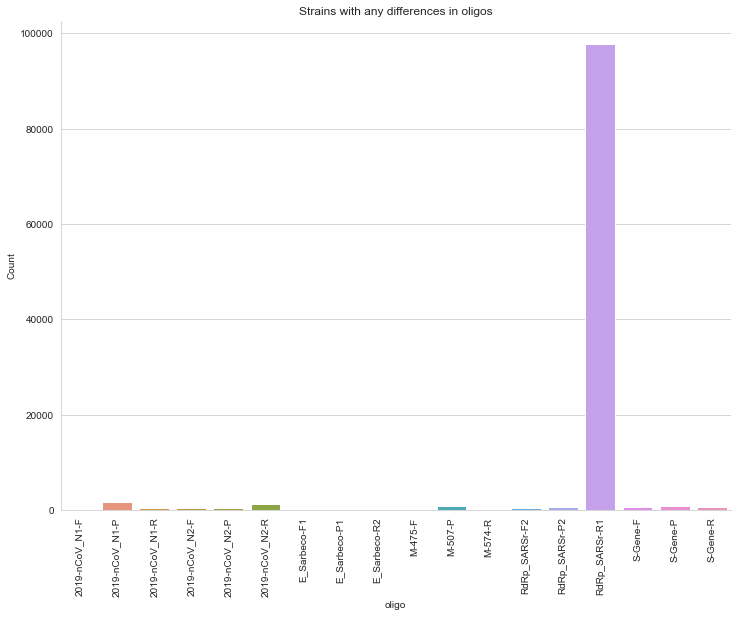

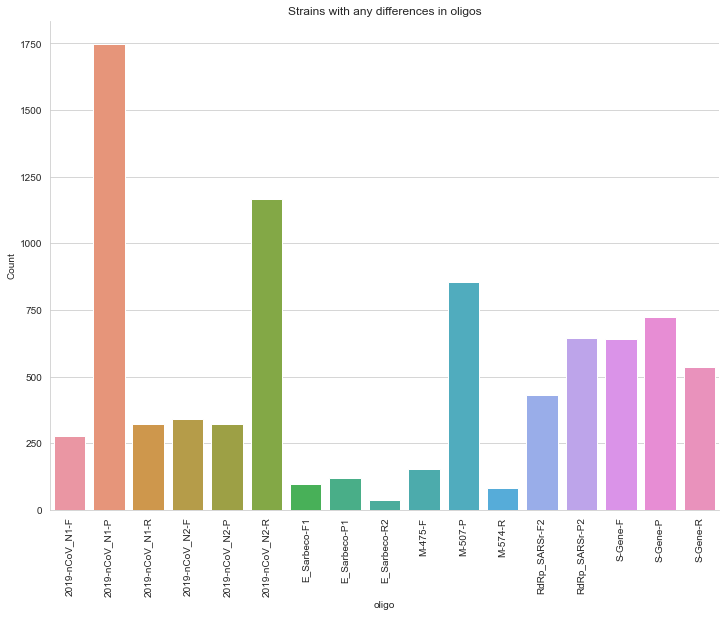

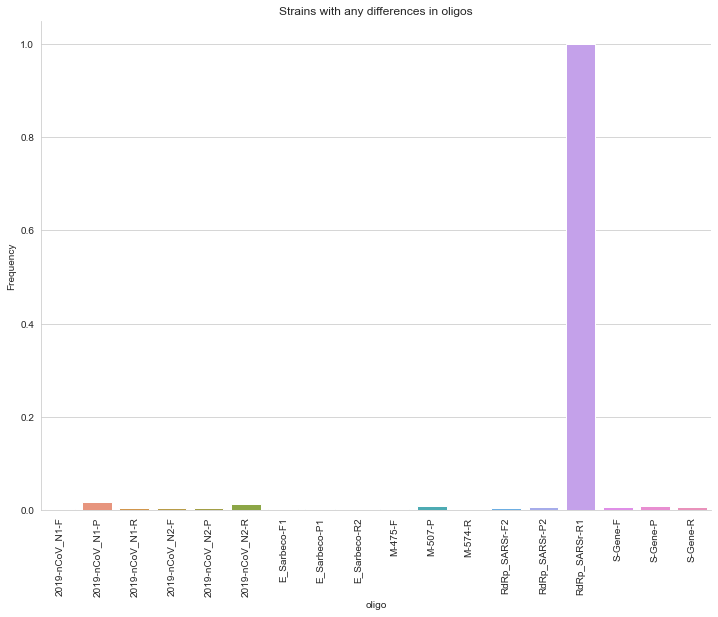

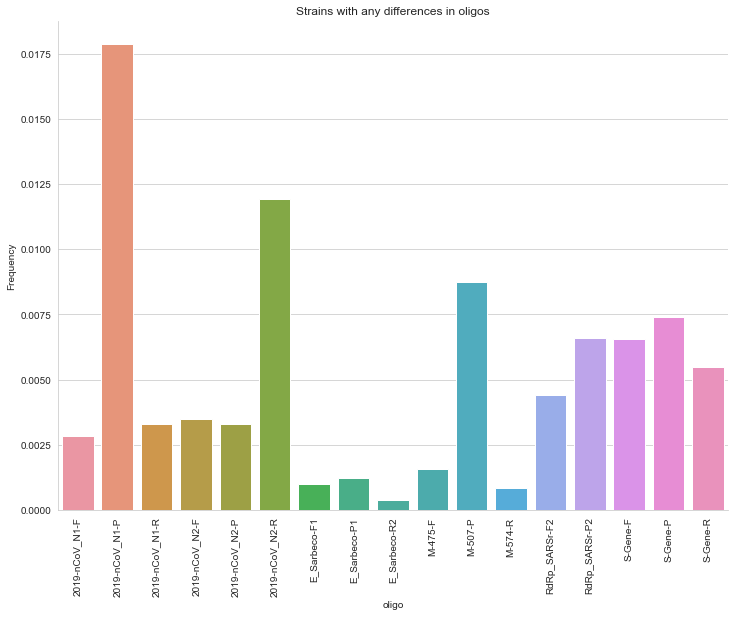

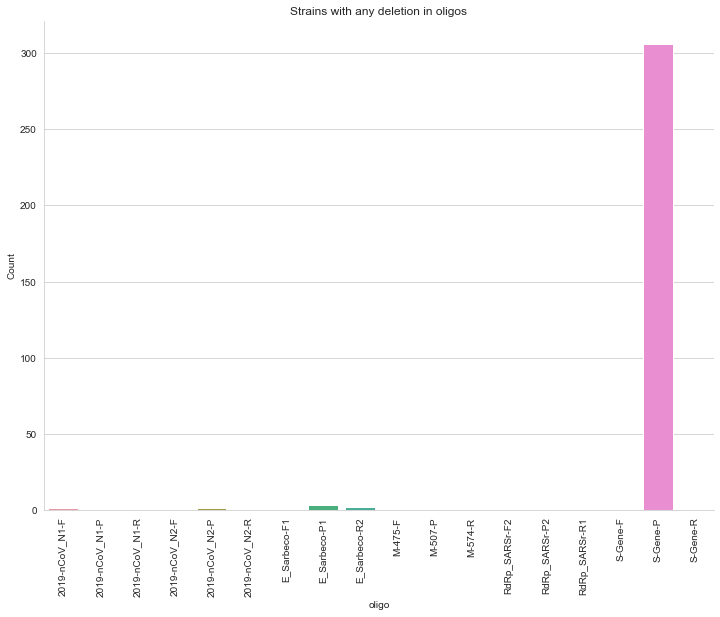

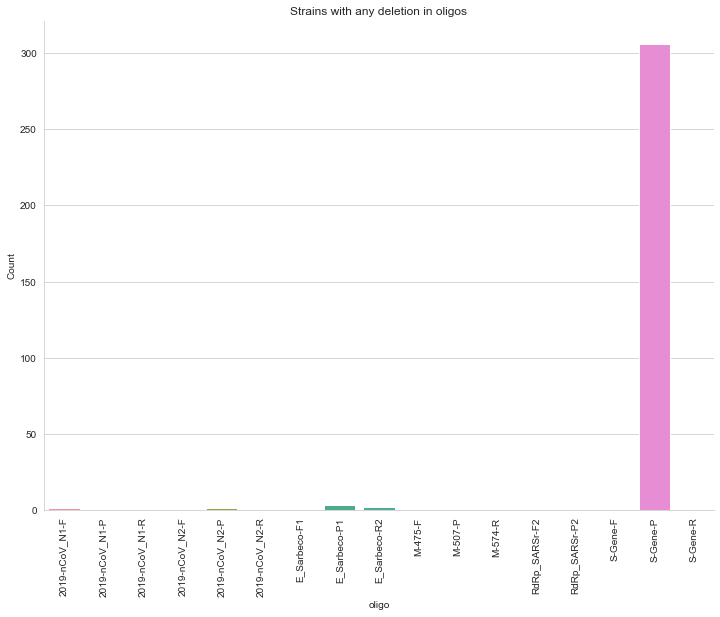

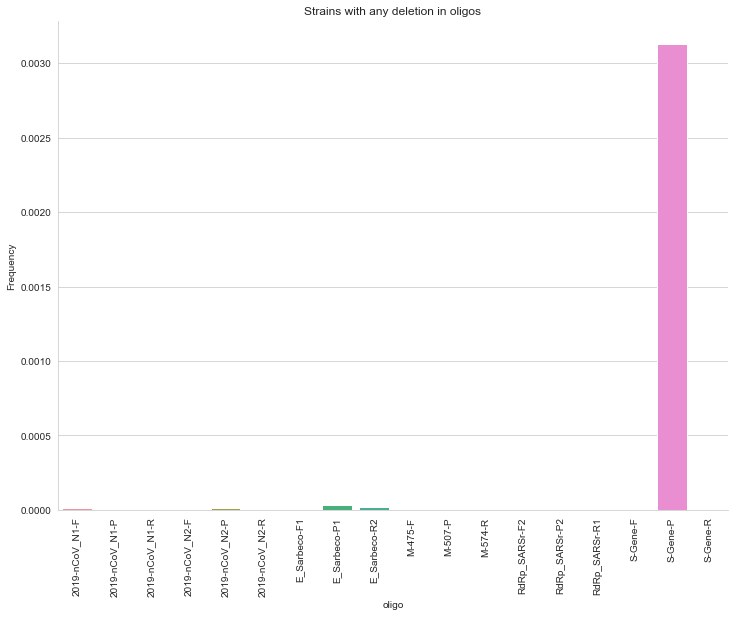

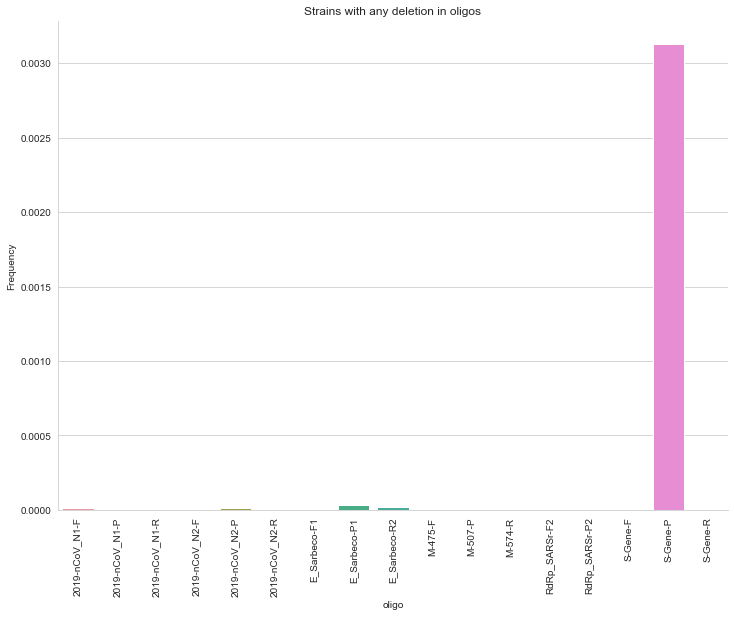

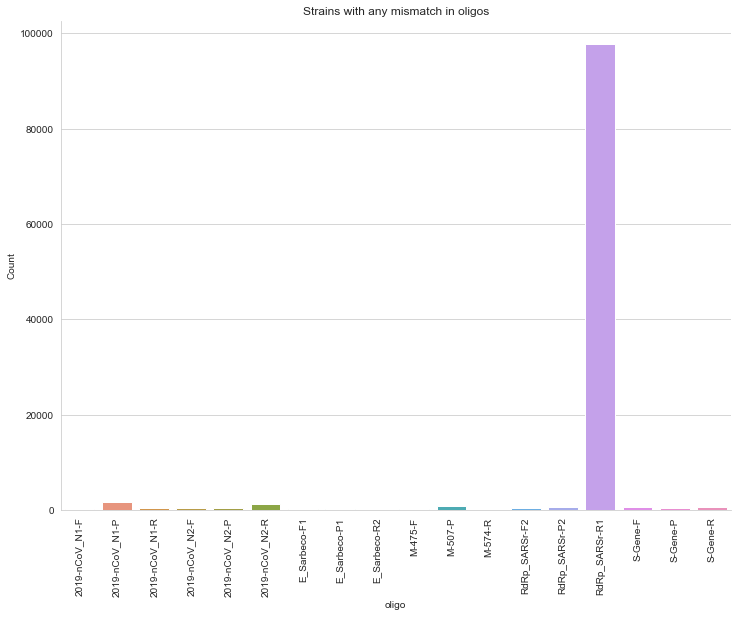

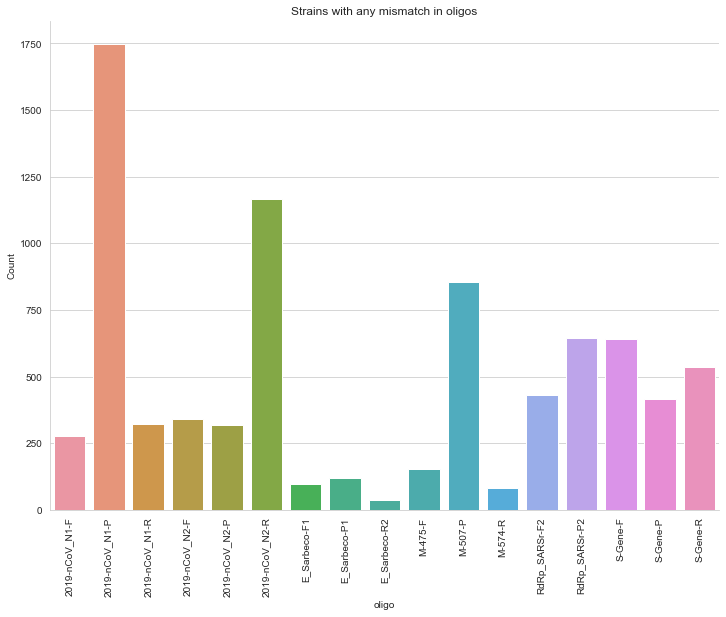

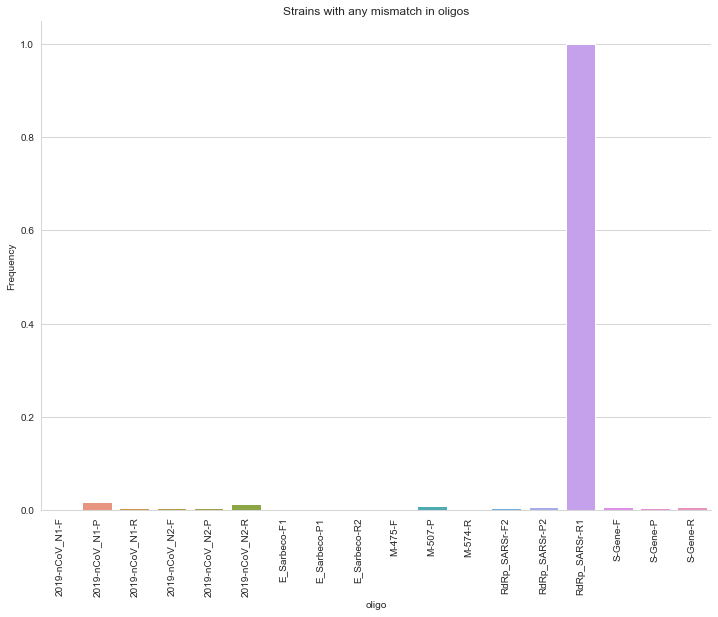

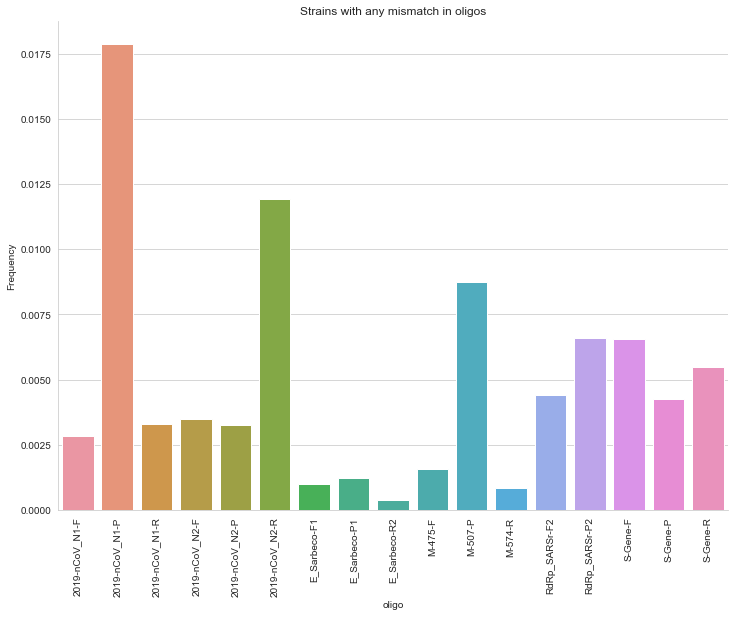

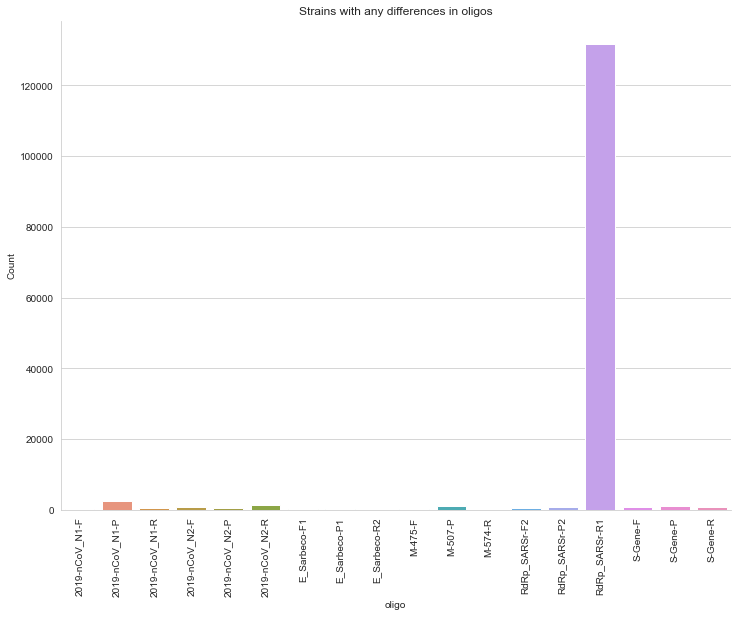

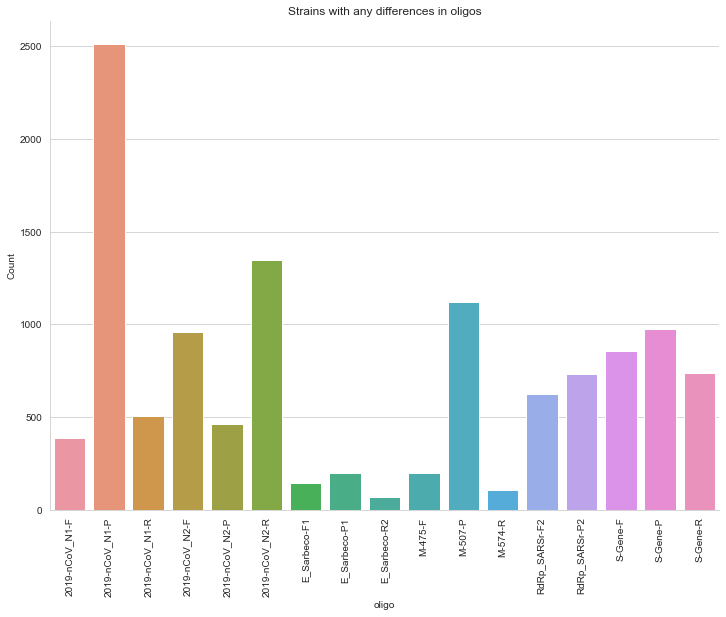

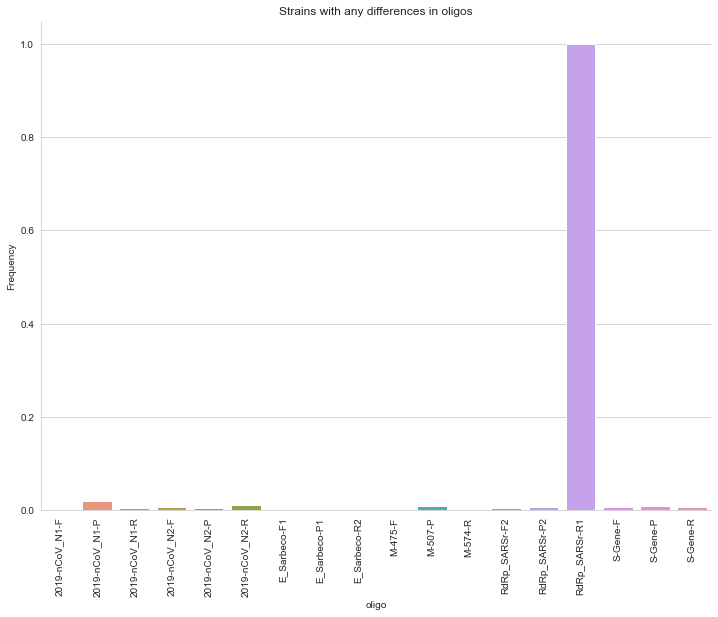

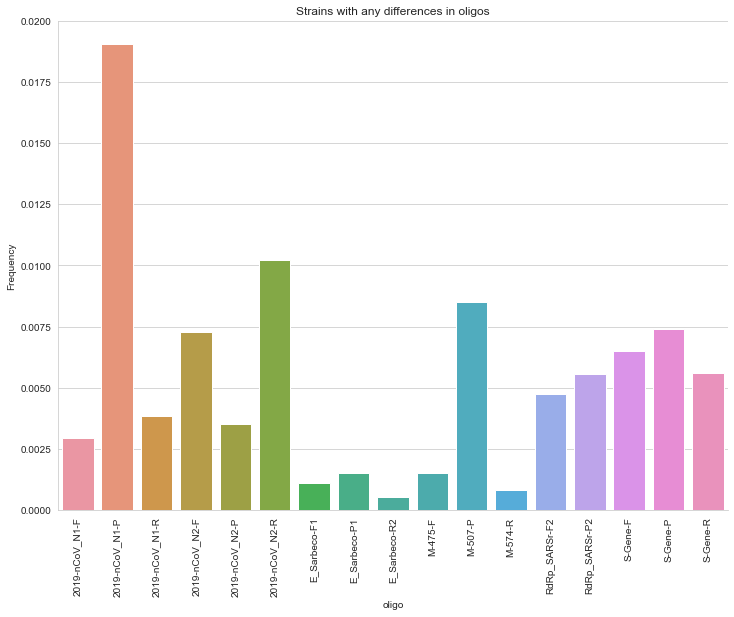

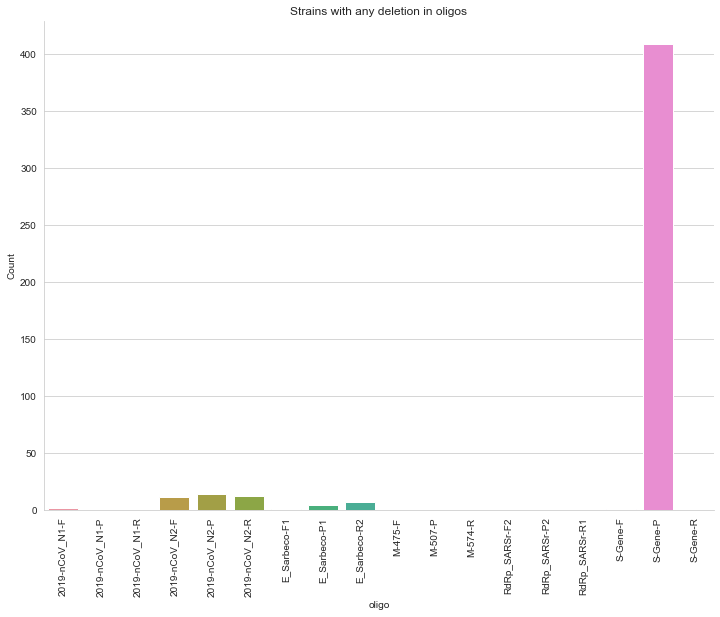

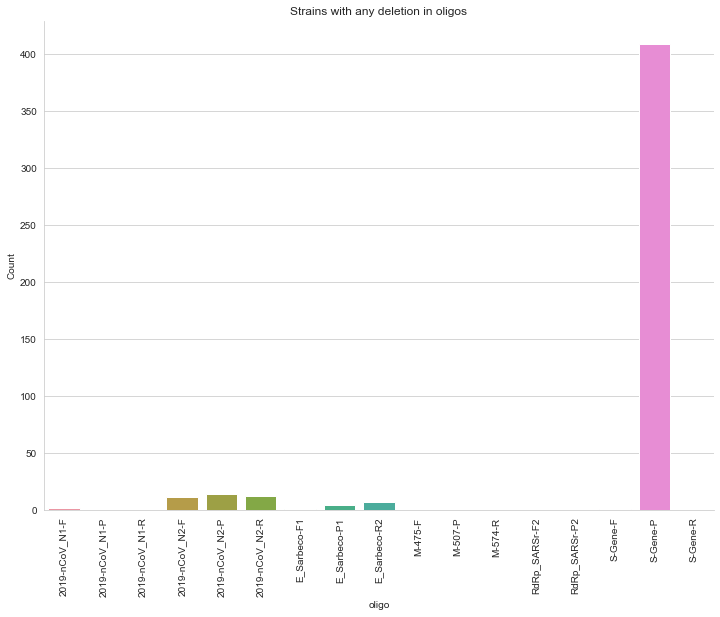

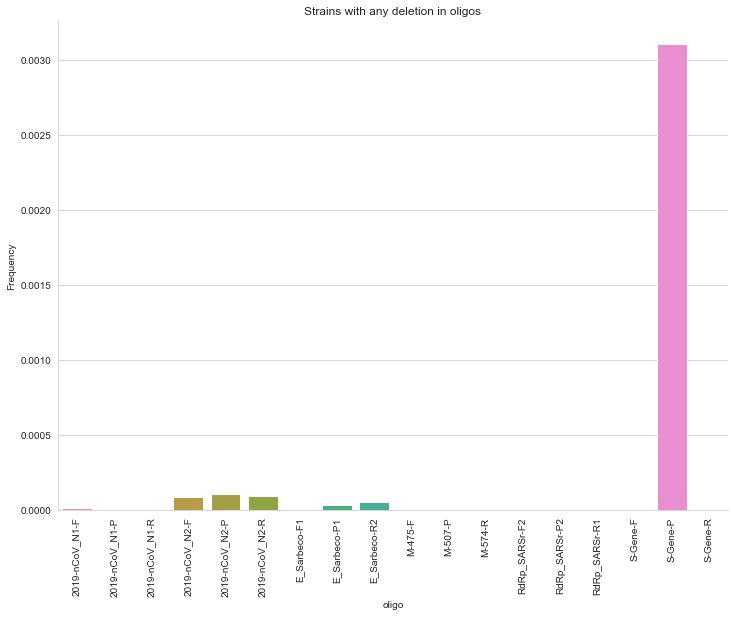

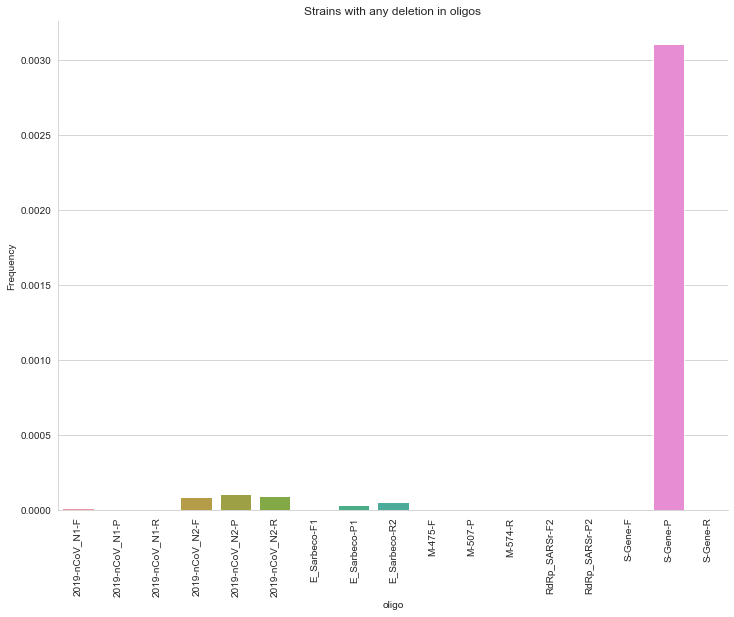

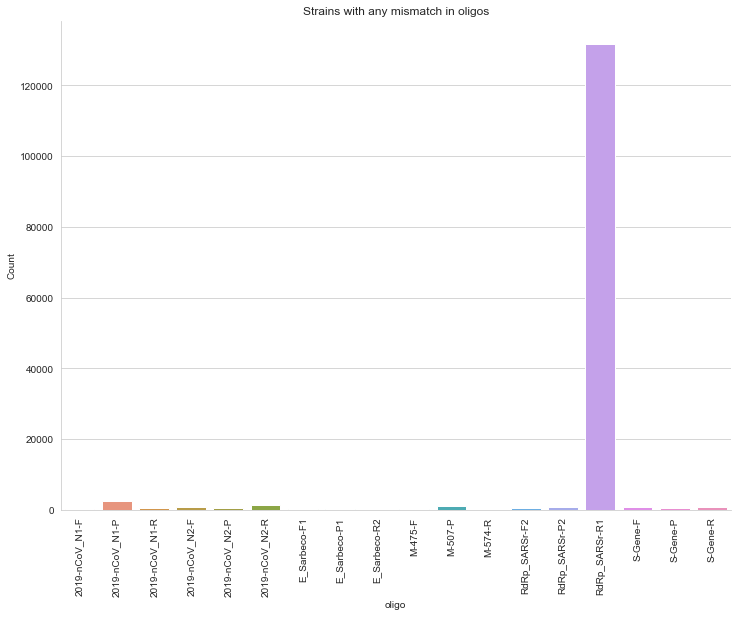

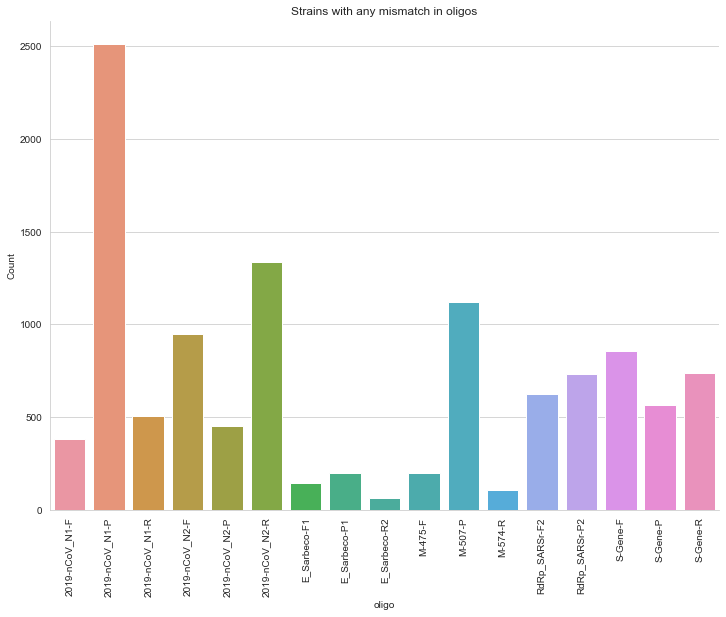

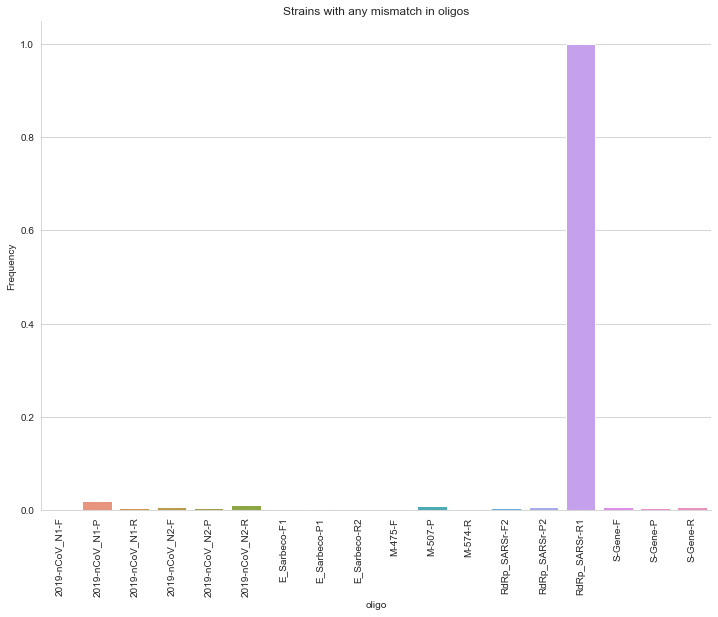

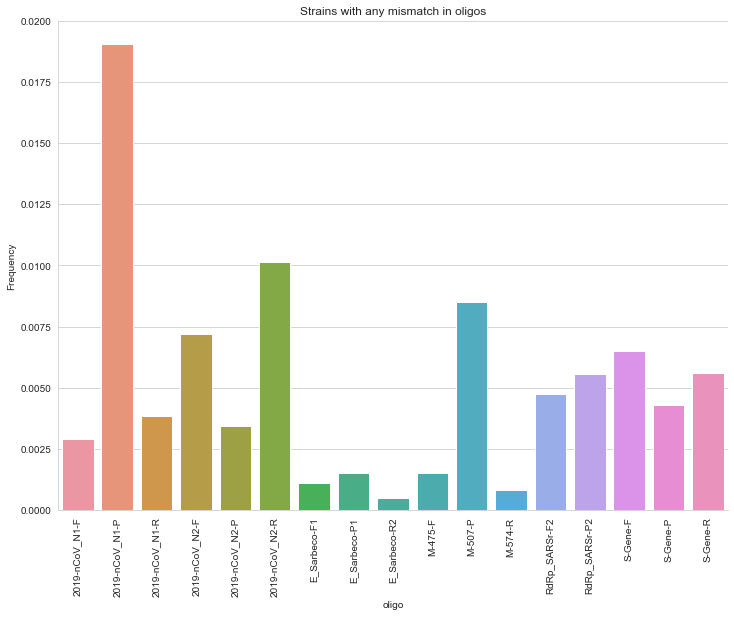

In [31]:
for df, pdir in zip([hq_probe_diffs, probe_diffs], ['high_qual', 'all_strains']):
    for category in ['differences', 'deletion', 'mismatch']:
        csvdir = "output/per_oligo/binary/{}".format(pdir)
        prefix = '{}_binary'.format(category)
        tmp_df = probe_diffs_to_binary_diff_csv(df,
                                                category=category,
                                                csv="{}/{}_summary.csv".format(csvdir, prefix))
        tmp_df.reset_index(inplace=True)
        for col in ['Count', 'Frequency']:
            plt.figure(figsize=(12,9))
            sns.barplot(data=tmp_df[(tmp_df['any_{}'.format(category)] == True)],
                        y=col,
                        order=oligo_order,
                        x='oligo')
            plt.title("Strains with any {} in oligos".format(category))
            plt.xticks(rotation=90)
            sns.despine()
            plt.savefig(csvdir + '/plots/{}_{}.pdf'.format(prefix, col))
            plt.figure(figsize=(12,9))
            sns.barplot(data=tmp_df[(tmp_df['any_{}'.format(category)] == True) &
                                    (tmp_df.oligo != 'RdRp_SARSr-R1')],
                        y=col,
                        order=[x for x in oligo_order if x != 'RdRp_SARSr-R1'],
                        x='oligo')
            plt.title("Strains with any {} in oligos".format(category))
            plt.xticks(rotation=90)
            sns.despine()
            plt.savefig(csvdir + '/plots/{}_{}_no_RdRp_SARSr-R1.pdf'.format(prefix, col))

As above but per-assay rather than per oligo

C:\Users\david\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\david\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\david\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

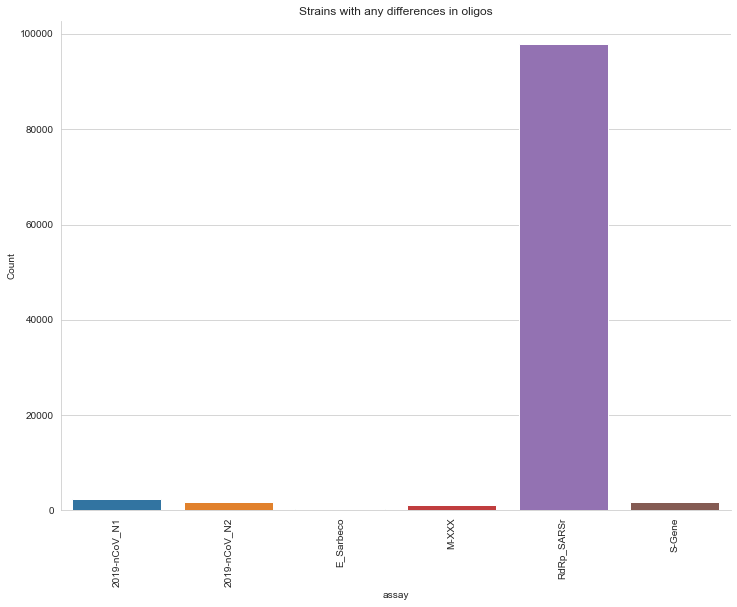

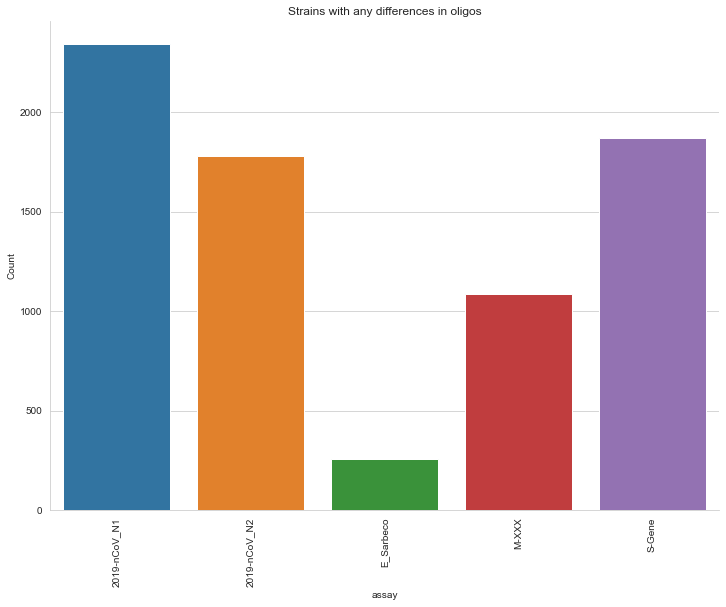

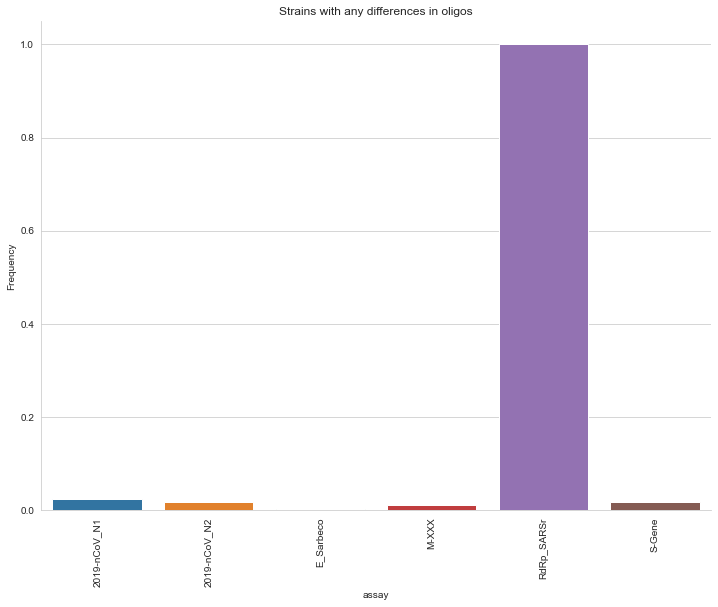

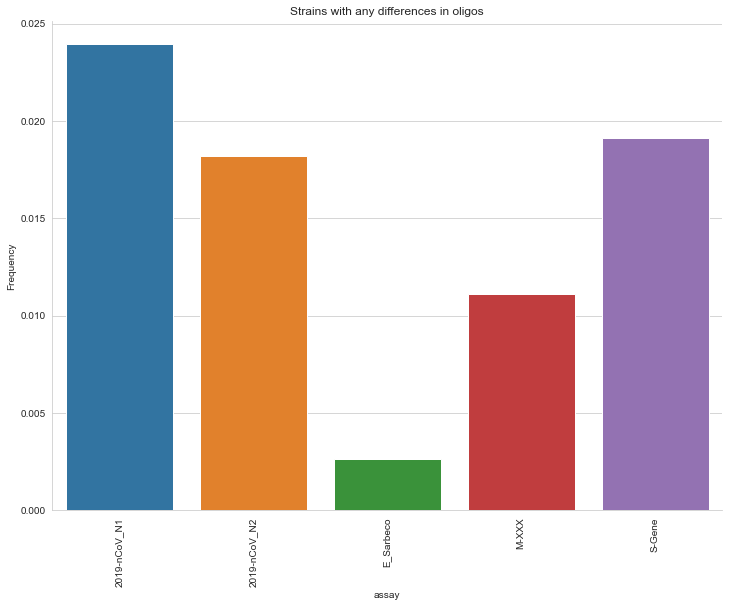

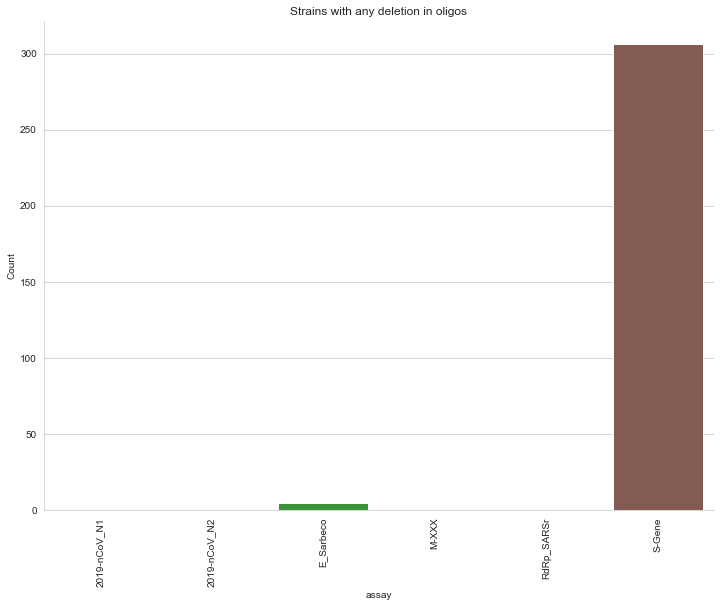

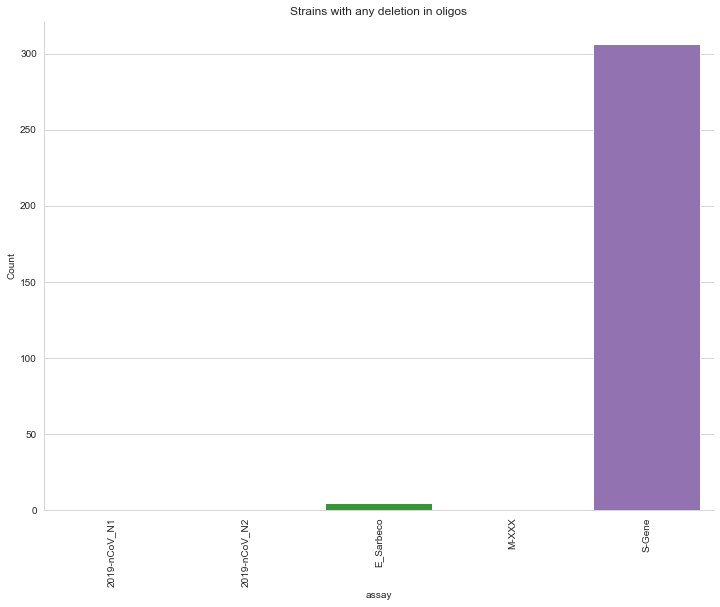

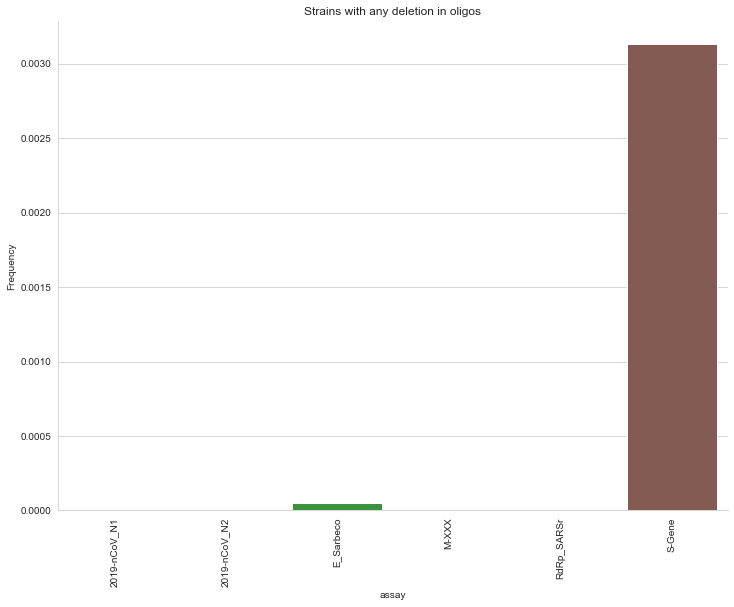

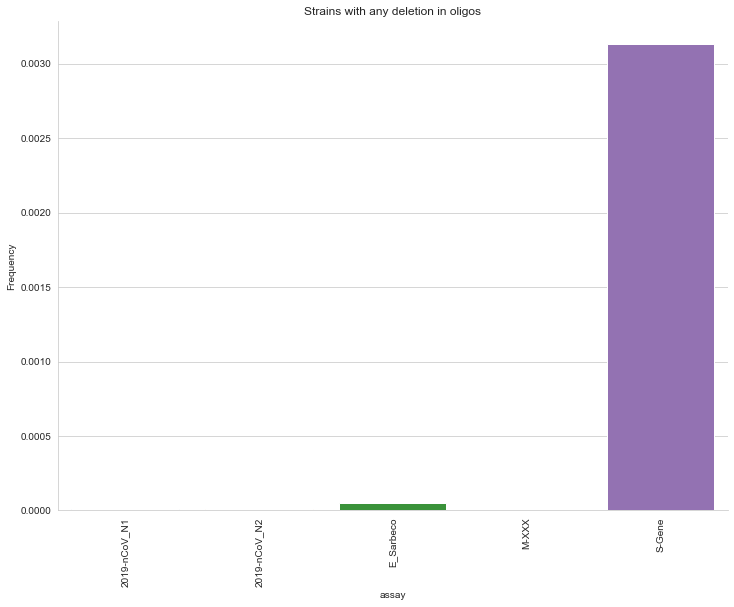

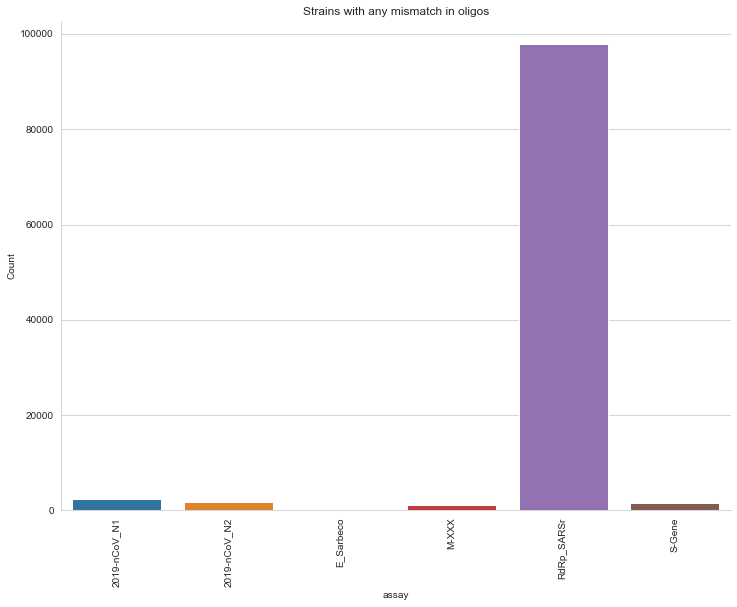

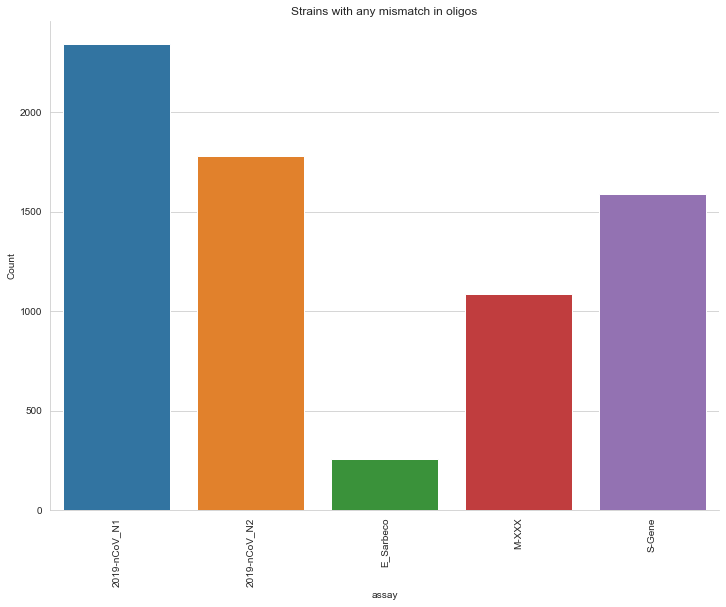

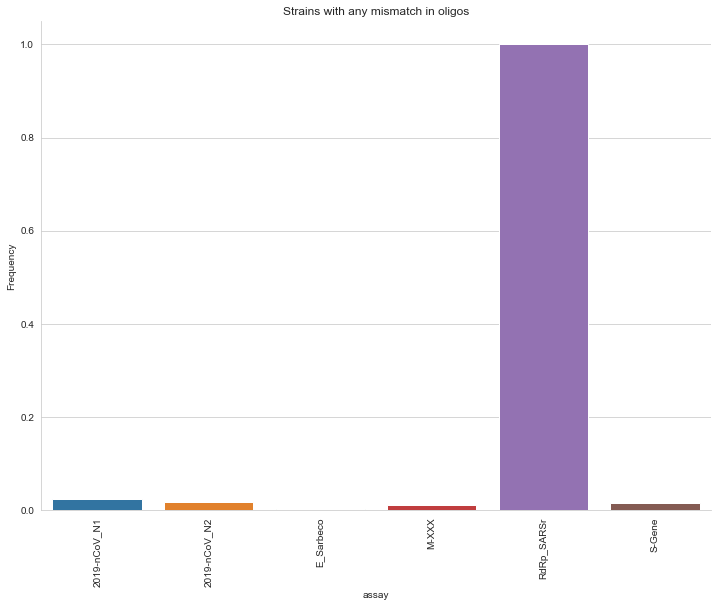

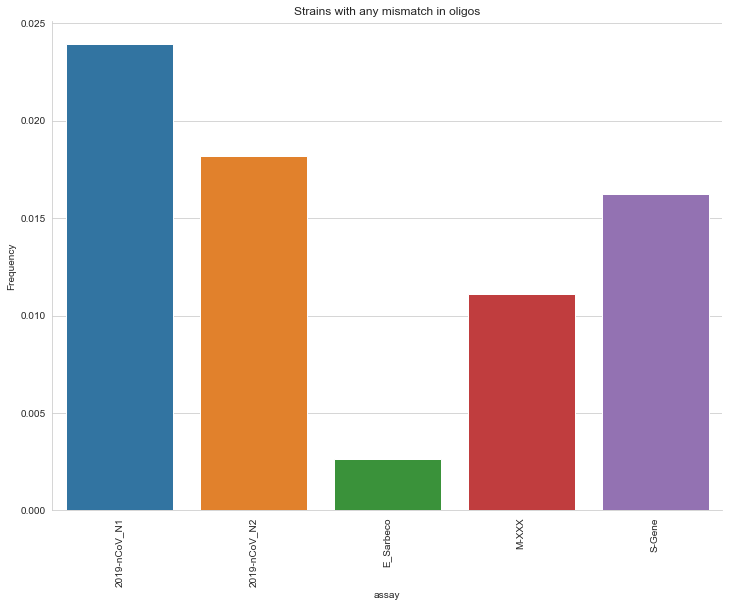

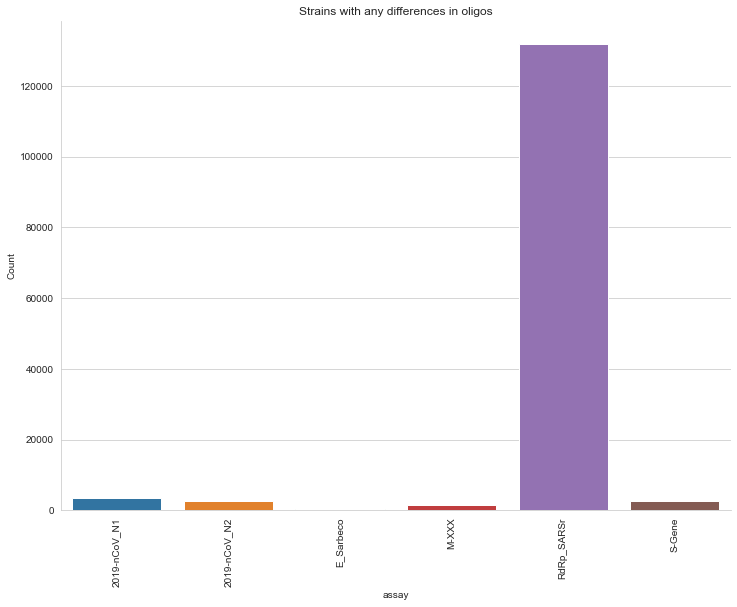

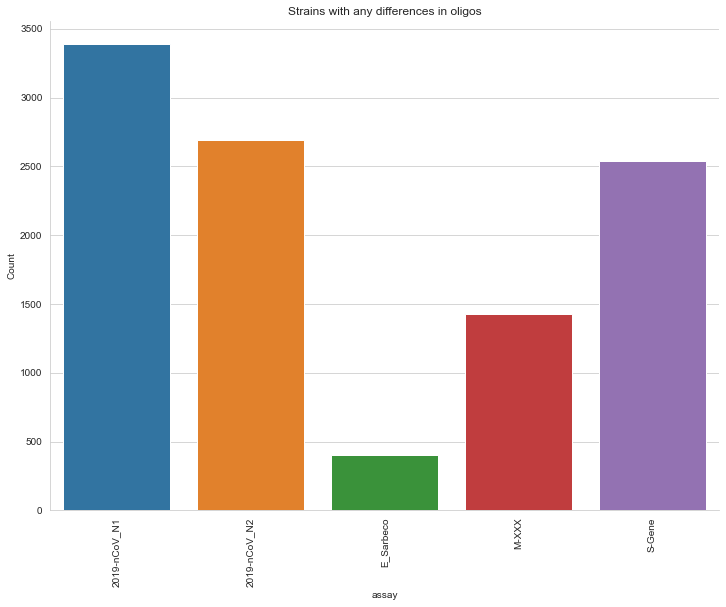

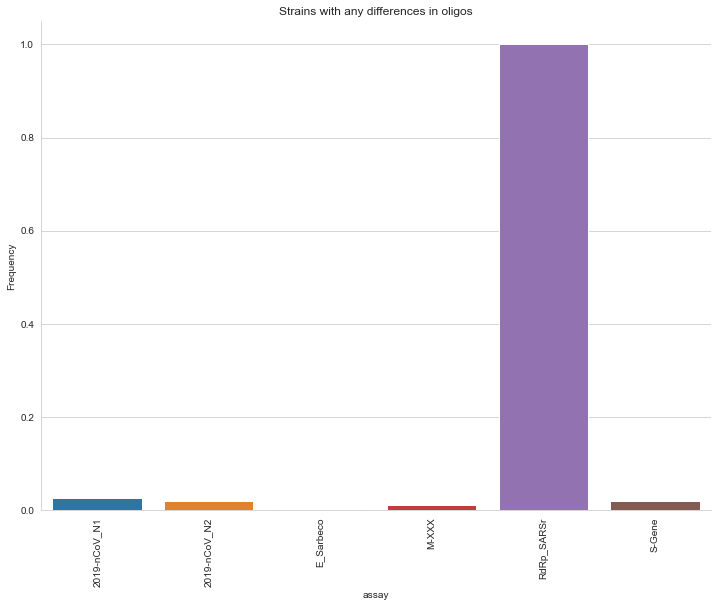

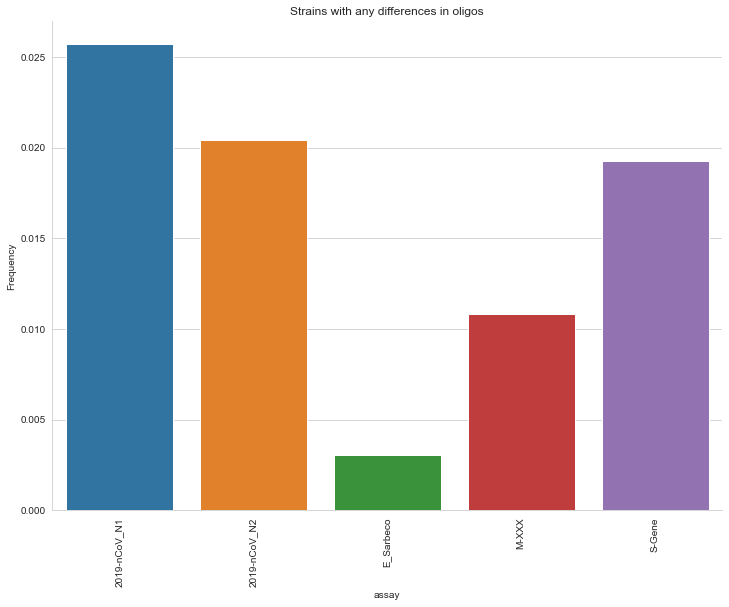

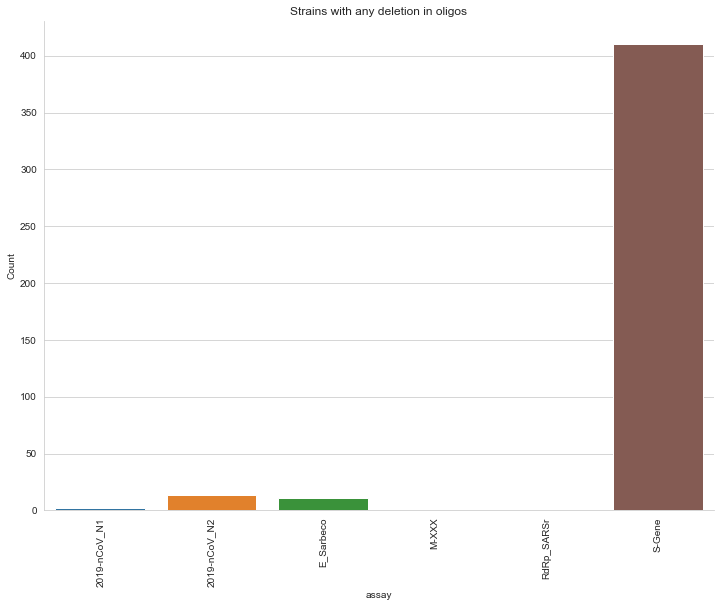

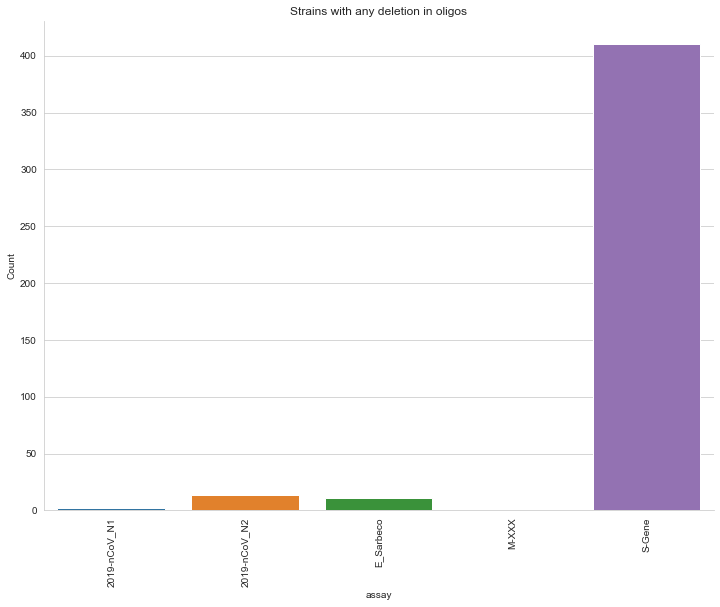

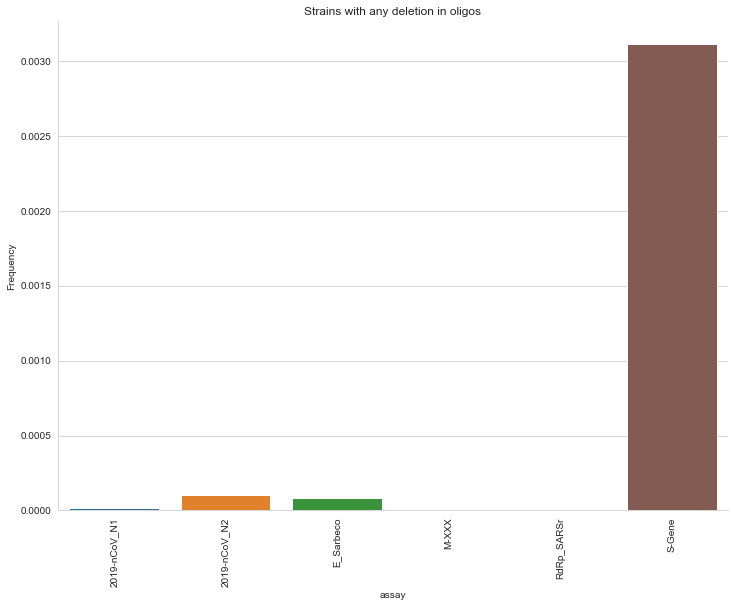

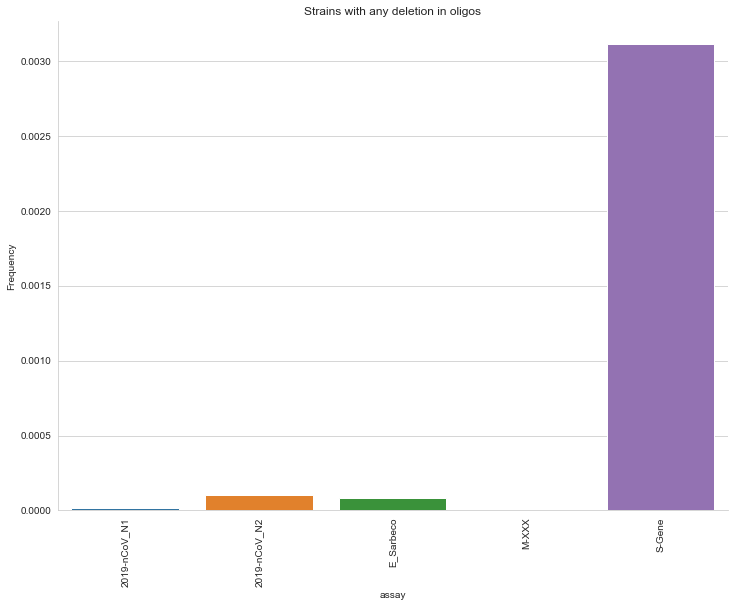

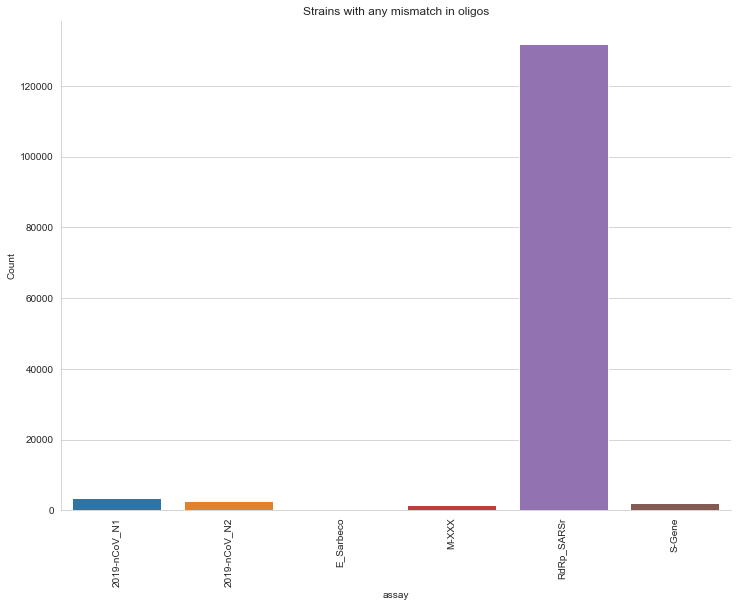

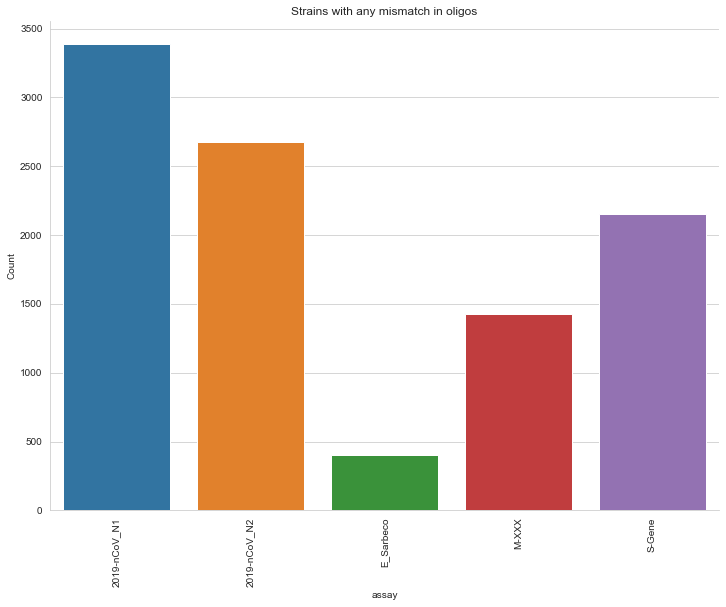

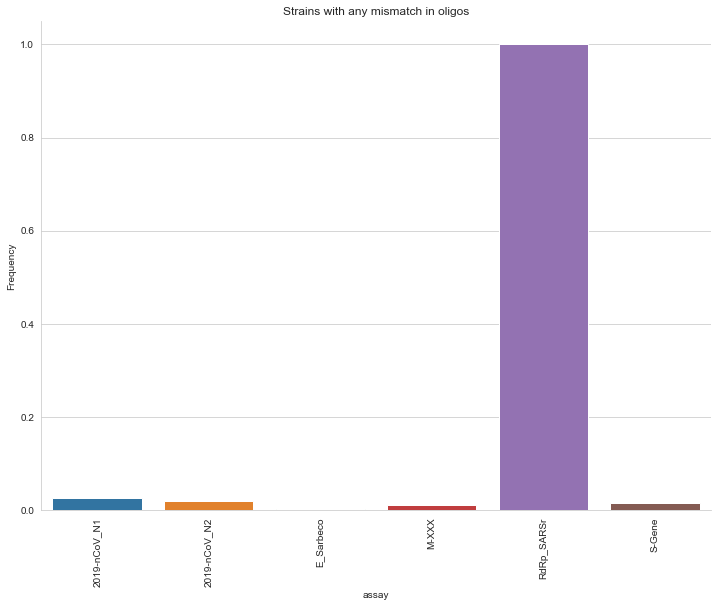

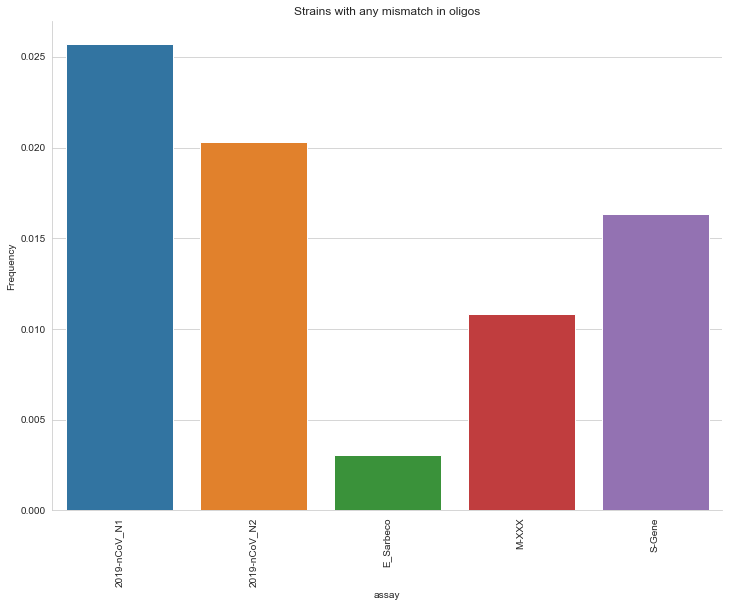

In [32]:
for df, pdir in zip([hq_assay_diffs, assay_diffs], ['high_qual', 'all_strains']):
    for category in ['differences', 'deletion', 'mismatch']:
        csvdir = "output/per_assay/binary/{}".format(pdir)
        prefix = '{}_binary'.format(category)
        tmp_df = probe_diffs_to_binary_diff_csv(df,
                                                category=category,
                                                level='assay',
                                                csv="{}/{}_summary.csv".format(csvdir, prefix))
        tmp_df.reset_index(inplace=True)
        for col in ['Count', 'Frequency']:
            plt.figure(figsize=(12,9))
            sns.barplot(data=tmp_df[(tmp_df['any_{}'.format(category)] == True)],
                        y=col,
                        order=assay_order,
                        x='assay')
            plt.title("Strains with any {} in oligos".format(category))
            plt.xticks(rotation=90)
            sns.despine()
            plt.savefig(csvdir + '/plots/{}_{}.pdf'.format(prefix, col))
            plt.figure(figsize=(12,9))
            sns.barplot(data=tmp_df[(tmp_df['any_{}'.format(category)] == True) &
                                    (tmp_df.assay != 'RdRp_SARSr-R1')],
                        y=col,
                        order=[x for x in assay_order if x != 'RdRp_SARSr'],
                        x='assay')
            plt.title("Strains with any {} in oligos".format(category))
            plt.xticks(rotation=90)
            sns.despine()
            plt.savefig(csvdir + '/plots/{}_{}_no_RdRp_SARSr.pdf'.format(prefix, col))

In [33]:
probe_diffs.to_csv("output/probe_diffs.csv.gz", compression='gzip', index=False)
hq_probe_diffs.to_csv("output/high_qual_probe_diffs.csv.gz", compression='gzip', index=False)

## Get match counts for 3' five nts of each F/R oligo

This analysis for high quality/whitelisted strains only

In [34]:
n = 0
gap_window = 15
max_surround_gap = 15
strain2probe_3prime_match = defaultdict(dict)
with open(msa_fasta, 'rt') as fh:
    for ref_record in SeqIO.parse(fh, 'fasta'):
        if ref_record.id not in whitelisted_strains:
            continue
        for k, v in primer_msa_pos.items():
            p = primer_to_probe_type(k)
            if p == 'R' or k == 'S-Gene-P': # reverse complemented sequences
                query_start = 0
                query_end = 4
            else:
                query_start = -5
                query_end = -1
            pw = pairwise_matches(probes[k].seq,
                                  ref_record.seq,
                                  v,
                                  query_start=query_start,
                                  query_end=query_end)
            strain2probe_3prime_match[ref_record.id][k] = pw
        n += 1
        if n % 10000 == 0:
            print("Processed {:,} sequences".format(n))
print("Finished processing {:,} sequence".format(n))

Processed 10,000 sequences
Processed 20,000 sequences
Processed 30,000 sequences
Processed 40,000 sequences
Processed 50,000 sequences
Processed 60,000 sequences
Processed 70,000 sequences
Processed 80,000 sequences
Processed 90,000 sequences
Finished processing 97,782 sequence


In [35]:
three_prime_probe_diffs = defaultdict(list)
for strain, probe_dict in strain2probe_3prime_match.items():
    for probe, match_dict in probe_dict.items():
        three_prime_probe_diffs['strain'].append(strain)
        three_prime_probe_diffs['oligo'].append(probe)
        three_prime_probe_diffs['assay'].append(primer_to_assay(probe))
        three_prime_probe_diffs['primer'].append(primer_to_probe_type(probe))
        for k, v in match_dict.items():
            three_prime_probe_diffs[k].append(v)
three_prime_probe_diffs = pd.DataFrame.from_dict(three_prime_probe_diffs)           
three_prime_probe_diffs.head()

,strain,oligo,assay,primer,match,mismatch,deletion,insertion
0,Wuhan/WIV04/2019,E_Sarbeco-F1,E_Sarbeco,F,5,0,0,0
1,Wuhan/WIV04/2019,E_Sarbeco-R2,E_Sarbeco,R,5,0,0,0
2,Wuhan/WIV04/2019,E_Sarbeco-P1,E_Sarbeco,P,5,0,0,0
3,Wuhan/WIV04/2019,RdRp_SARSr-F2,RdRp_SARSr,F,5,0,0,0
4,Wuhan/WIV04/2019,RdRp_SARSr-R1,RdRp_SARSr,R,5,0,0,0


In [36]:
three_prime_probe_diffs['differences'] = 5 - three_prime_probe_diffs.match
three_prime_probe_diffs.head()

,strain,oligo,assay,primer,match,mismatch,deletion,insertion,differences
0,Wuhan/WIV04/2019,E_Sarbeco-F1,E_Sarbeco,F,5,0,0,0,0
1,Wuhan/WIV04/2019,E_Sarbeco-R2,E_Sarbeco,R,5,0,0,0,0
2,Wuhan/WIV04/2019,E_Sarbeco-P1,E_Sarbeco,P,5,0,0,0,0
3,Wuhan/WIV04/2019,RdRp_SARSr-F2,RdRp_SARSr,F,5,0,0,0,0
4,Wuhan/WIV04/2019,RdRp_SARSr-R1,RdRp_SARSr,R,5,0,0,0,0


In [37]:
three_prime_probe_diffs.to_csv("output/three_prime_high_qual_probe_diffs.csv.gz",
                               compression='gzip',
                               index=False)

In [38]:
three_prime_assay_diffs = three_prime_probe_diffs[three_prime_probe_diffs.primer != 'P'].groupby(
    ['strain', 'assay']).agg(
    {'match': np.sum,
     'mismatch': np.sum,
     'deletion': np.sum,
     'insertion': np.sum,
     'differences': np.sum}).reset_index()
three_prime_assay_diffs.head()

,strain,assay,match,mismatch,deletion,insertion,differences
0,Algeria/G0638_2264/2020,2019-nCoV_N1,10,0,0,0,0
1,Algeria/G0638_2264/2020,2019-nCoV_N2,10,0,0,0,0
2,Algeria/G0638_2264/2020,E_Sarbeco,10,0,0,0,0
3,Algeria/G0638_2264/2020,M-XXX,10,0,0,0,0
4,Algeria/G0638_2264/2020,RdRp_SARSr,10,0,0,0,0


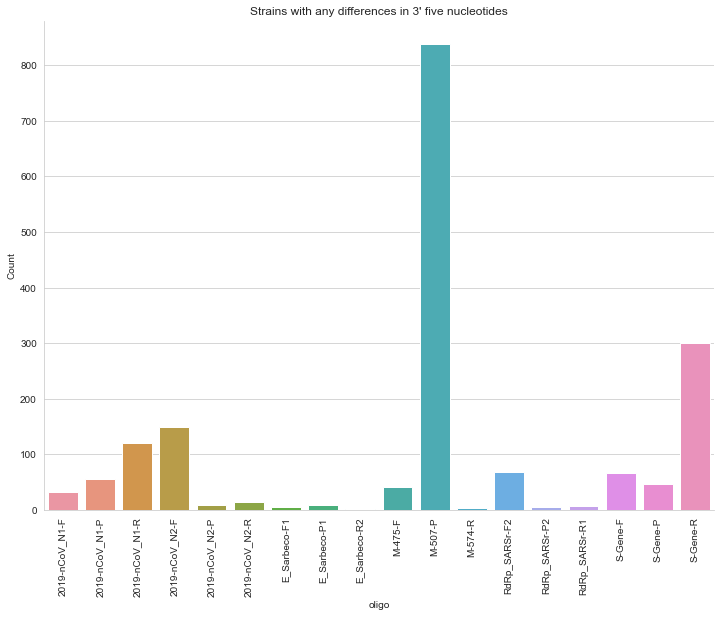

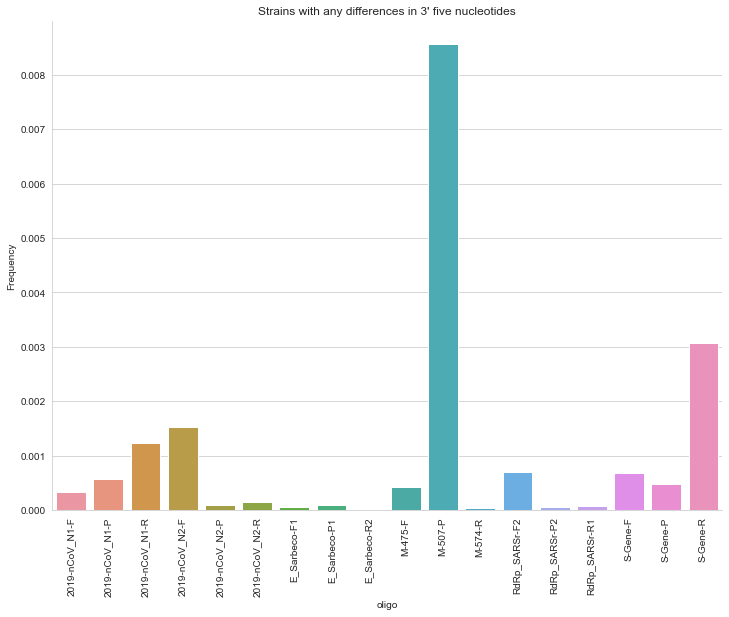

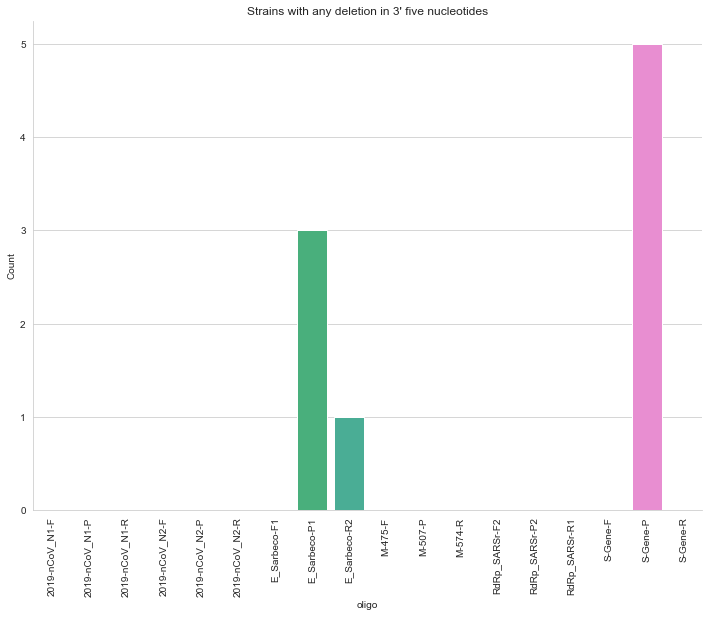

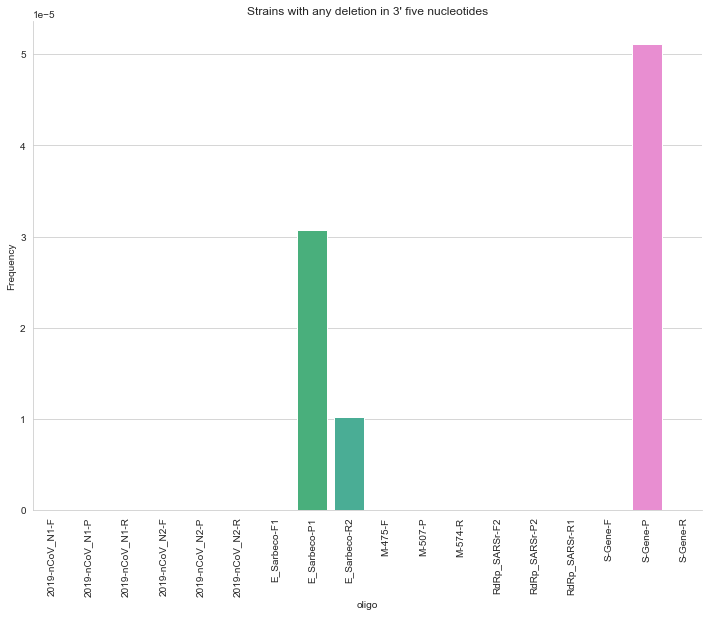

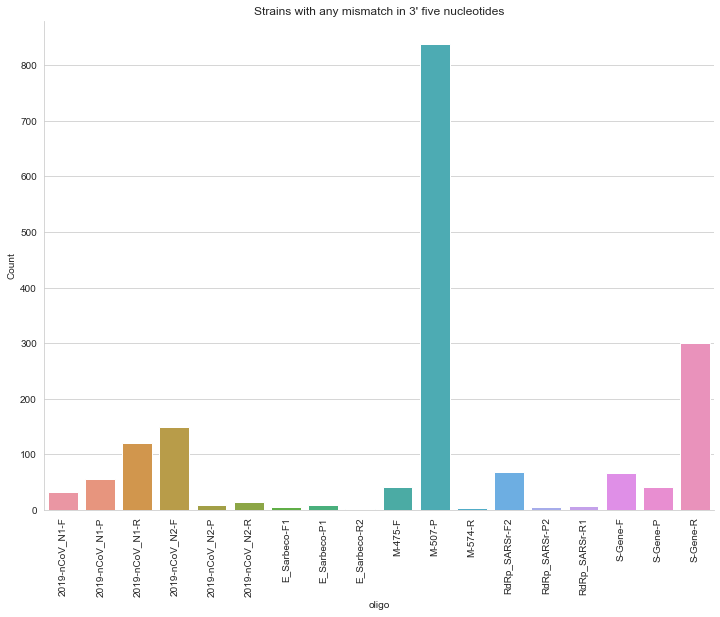

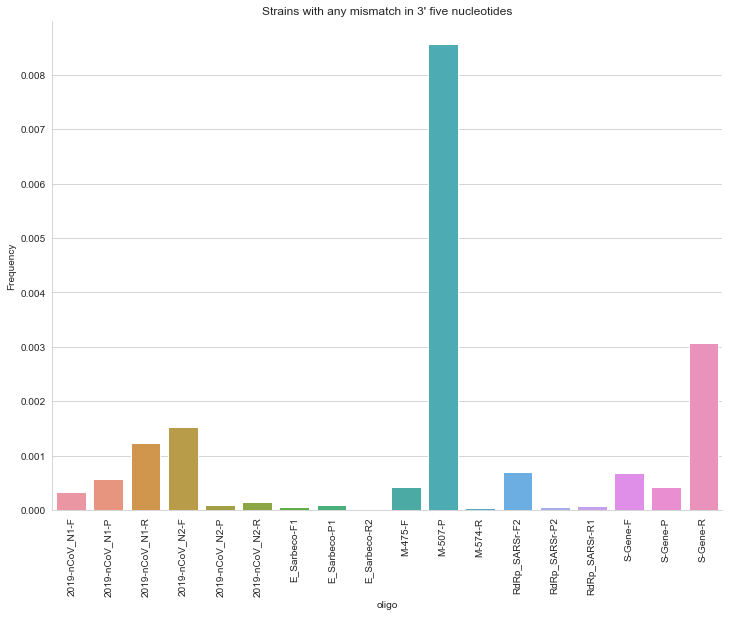

In [39]:
csvdir = 'output/per_oligo/binary/high_qual'
for category in ['differences', 'deletion', 'mismatch']:
    prefix = 'three_prime_5_{}_binary'.format(category)
    tmp_df = probe_diffs_to_binary_diff_csv(three_prime_probe_diffs,
                                            level='oligo',
                                            category=category,
                                            csv="{}/{}_summary.csv".format(csvdir, prefix))
    tmp_df.reset_index(inplace=True)
    for col in ['Count', 'Frequency']:
        plt.figure(figsize=(12,9))
        sns.barplot(data=tmp_df[(tmp_df['any_{}'.format(category)] == True)],
                    y=col,
                    order=oligo_order,
                    x='oligo')
        plt.title("Strains with any {} in 3' five nucleotides".format(category))
        plt.xticks(rotation=90)
        sns.despine()
        plt.savefig(csvdir + '/plots/{}_{}.pdf'.format(prefix, col))

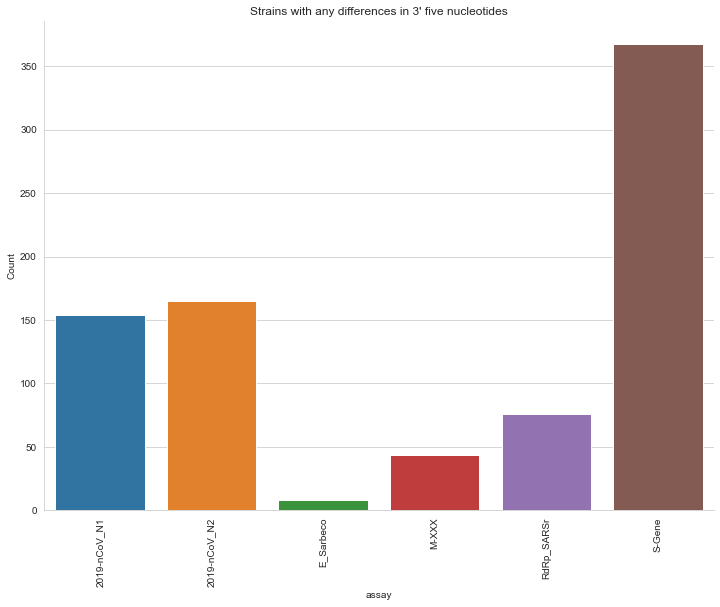

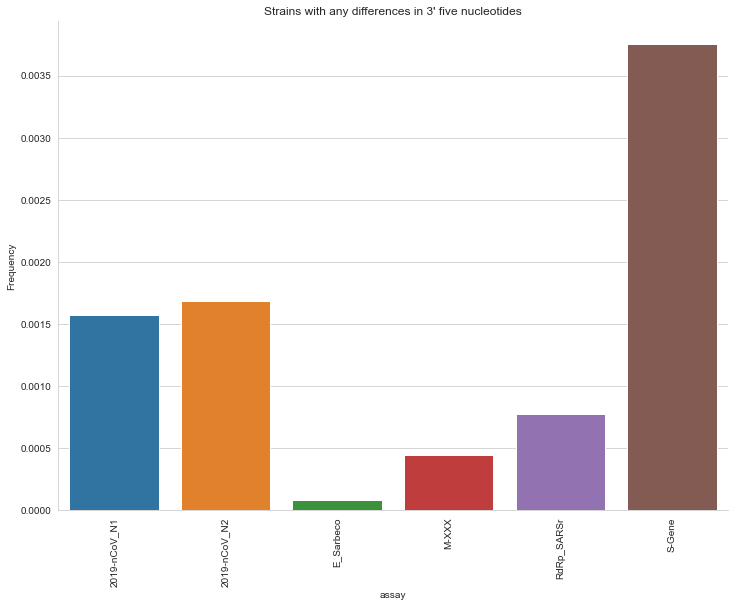

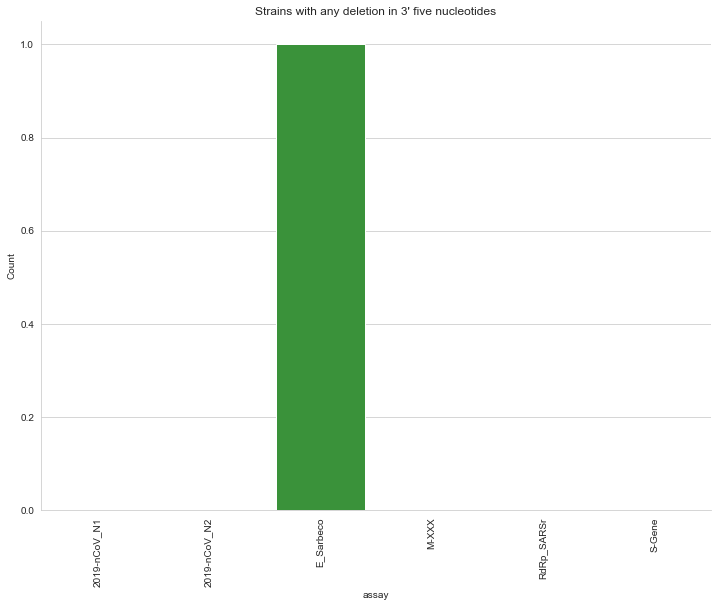

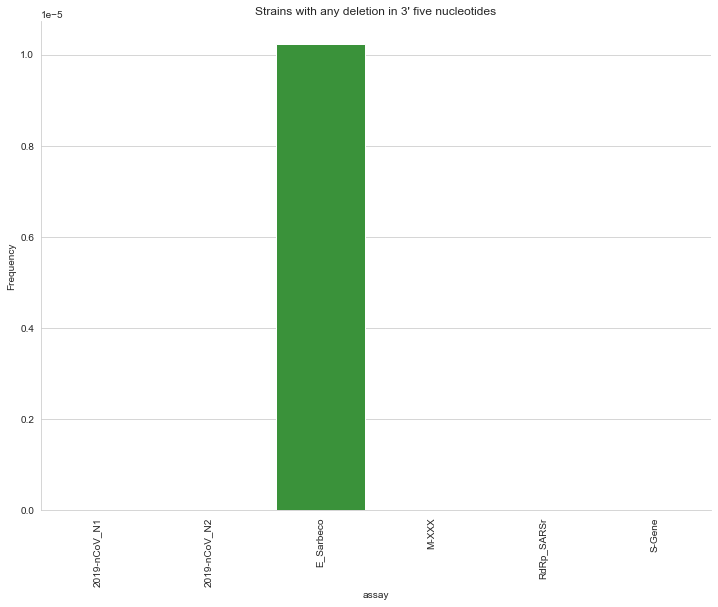

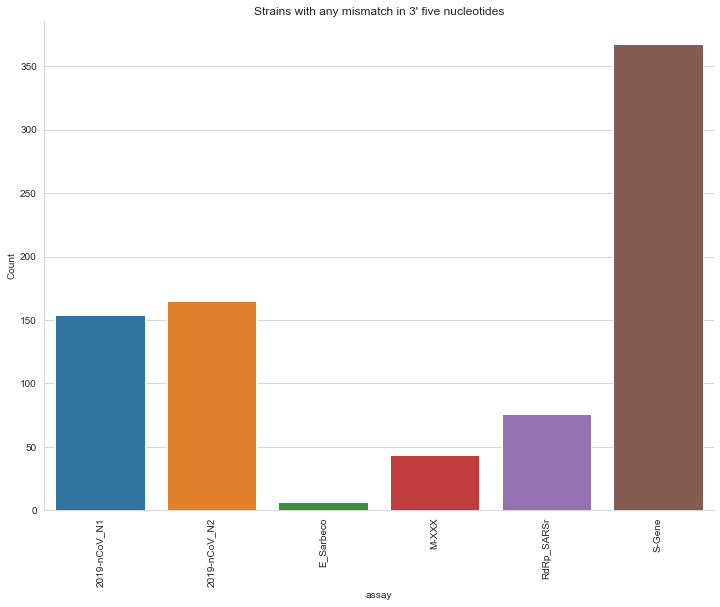

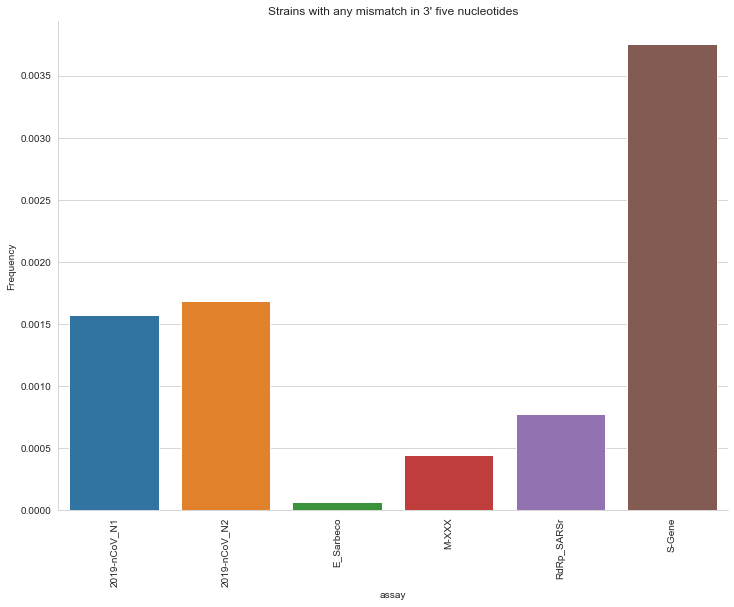

In [40]:
csvdir = 'output/per_assay/binary/high_qual'
for category in ['differences', 'deletion', 'mismatch']:
    prefix = 'three_prime_5_{}_binary'.format(category)
    tmp_df = probe_diffs_to_binary_diff_csv(three_prime_assay_diffs,
                                            level='assay',
                                            category=category,
                                            csv="{}/{}_summary.csv".format(csvdir, prefix))
    tmp_df.reset_index(inplace=True)
    for col in ['Count', 'Frequency']:
        plt.figure(figsize=(12,9))
        sns.barplot(data=tmp_df[(tmp_df['any_{}'.format(category)] == True)],
                    y=col,
                    order=assay_order,
                    x='assay')
        plt.title("Strains with any {} in 3' five nucleotides".format(category))
        plt.xticks(rotation=90)
        sns.despine()
        plt.savefig(csvdir + '/plots/{}_{}.pdf'.format(prefix, col))

## Analyze variants at each position in the primer

In [41]:
def pairwise_pos_diffs(primer, ref, align_indices, check_flanks=20):
    # go through each alignment index from min to max to allow for gaps
    q = 0
    indel = False
    matching_nts = []
    for i in range(align_indices[0], align_indices[-1] + 1):
        if i in align_indices:
            if ref[i] == '-':
                indel = True
                matching_nts.append('-')
            elif primer[q] == ref[i] or set(
                    ambiguous_dna_values[ref[i]]).intersection(
                    set(ambiguous_dna_values[primer[q]])
            ):
                matching_nts.append(primer[q])
            else:
                matching_nts.append(ref[i])
            q += 1
        else:
            if ref[i] != '-':
                matching_nts[-1] += ref[i] # insertion
                indel = True
            # otherwise is gap in both sequences
    if indel:
        # attempt pairwise alignment of flanking sequences to see
        # if there really is an exact match to primer - e.g.
        # primer: ACGTACG-T
        # ref:    ACGTACGTT
        # msa:    ACGTACG-T
        start = max((align_indices[0] - check_flanks, 0))
        end = align_indices[-1] + check_flanks
        max_score = None
        for a in pairwise2.align.localms(primer, ref[start:end], 2, -1, -5, -1):
            if a[0][a.start:a.end] == a[1][a.start:a.end]: # exact match
                return list(primer) # exact match
            elif max_score is None or max_score < a.score:
                max_score = a.score
                realign_primer = a[0]
                realign_ref = a[1]
        if not max_score:
            return matching_nts
        matching_nts = []
        #print("Testing realigned primer vs ref:\n{}\n{}".format(realign_primer, realign_ref))
        for i in range(len(realign_primer)):
            if realign_primer[i] != '-':
                if realign_ref[i] == '-':
                    matching_nts.append('-')  # deletion
                elif realign_primer[i] == realign_ref[i] or set(
                        ambiguous_dna_values[realign_ref[i]]).intersection(
                        set(ambiguous_dna_values[realign_primer[i]])
                ):
                    matching_nts.append(realign_primer[i])  # match
                else:
                    matching_nts.append(realign_ref[i])  # mismatch
            else:
                if realign_ref[i] != '-':
                    if matching_nts:  # only interested in insertions once we're in the primer sequence already
                        if matching_nts[-1] == '-':
                            matching_nts[-1] = ''
                        matching_nts[-1] += realign_ref[i]  # insertion
                # otherwise is gap in both sequences
            if len(matching_nts) == len(primer) and matching_nts[-1] != '-':
                break  # don't carry on adding from end of alignment
    return matching_nts

In [42]:
variants_per_probe_per_pos = dict()
for k in probes:
    variants_per_probe_per_pos[k] = [dict() for x in range(len(probes[k].seq))]
n = 0
s = 0
with open(msa_fasta, 'rt') as fh:
    for ref_record in SeqIO.parse(fh, 'fasta'):
        if ref_record.id not in whitelisted_strains:
            s += 1
            continue
        n += 1
        for k, v in primer_msa_pos.items():
            nt_list = pairwise_pos_diffs(probes[k].seq,
                                         ref_record.seq,
                                         v)
            for i, nt in enumerate(nt_list):
                nt = nt.replace('U', 'T')
                if nt in variants_per_probe_per_pos[k][i]:
                    variants_per_probe_per_pos[k][i][nt] += 1
                else:
                    variants_per_probe_per_pos[k][i][nt] = 1
        if n % 10000 == 0:
            print("Processed {:,} records, skipped {:,}".format(n, s))
print("Finished processing {:,} records, skipped {:,}".format(n, s))

Processed 10,000 records, skipped 3,418
Processed 20,000 records, skipped 6,971
Processed 30,000 records, skipped 10,571
Processed 40,000 records, skipped 14,024
Processed 50,000 records, skipped 17,426
Processed 60,000 records, skipped 20,891
Processed 70,000 records, skipped 24,402
Processed 80,000 records, skipped 27,886
Processed 90,000 records, skipped 31,285
Finished processing 97,782 records, skipped 33,968


In [43]:
from Bio.Seq import Seq
def reverse_complement_variant_pos(vp):
    vp = reversed(vp)
    reverse_complemented = []
    for d in vp:
        rc = dict()
        for k, v in d.items():
            rc[str(Seq(k).reverse_complement())] = v
        reverse_complemented.append(rc)
    return reverse_complemented

In [44]:
variants_per_probe_per_pos['S-Gene-P']

[{'A': 97777, '-': 5},
 {'T': 97775, '-': 5, 'C': 2},
 {'G': 97759, 'T': 15, '-': 5, 'A': 3},
 {'C': 97756, 'T': 21, '-': 5},
 {'T': 97781, 'G': 1},
 {'A': 97777, 'T': 5},
 {'T': 97471, '-': 301, 'C': 8, 'A': 1, 'G': 1},
 {'A': 97475, '-': 301, 'C': 5, 'G': 1},
 {'C': 97444, '-': 301, 'A': 5, 'T': 30, 'G': 2},
 {'A': 97477, '-': 301, 'G': 3, 'T': 1},
 {'T': 97479, '-': 301, 'C': 2},
 {'G': 97425, '-': 301, 'T': 52, 'A': 4},
 {'T': 97781, 'C': 1},
 {'C': 97663, 'T': 119},
 {'T': 97750, 'A': 5, 'C': 27},
 {'C': 97762, 'T': 19, 'A': 1},
 {'T': 97756, 'C': 17, 'TT': 4, 'G': 5},
 {'G': 97772, 'A': 5, 'T': 5},
 {'G': 97776, 'A': 4, 'T': 2},
 {'G': 97737, 'A': 38, 'T': 7},
 {'A': 97777, 'T': 5},
 {'C': 97758, 'T': 22, '-': 1, 'A': 1},
 {'C': 97770, 'T': 11, '-': 1},
 {'A': 97782}]

In [45]:
reverse_complement_variant_pos(variants_per_probe_per_pos['S-Gene-P'])

[{'T': 97782},
 {'G': 97770, 'A': 11, '-': 1},
 {'G': 97758, 'A': 22, '-': 1, 'T': 1},
 {'T': 97777, 'A': 5},
 {'C': 97737, 'T': 38, 'A': 7},
 {'C': 97776, 'T': 4, 'A': 2},
 {'C': 97772, 'T': 5, 'A': 5},
 {'A': 97756, 'G': 17, 'AA': 4, 'C': 5},
 {'G': 97762, 'A': 19, 'T': 1},
 {'A': 97750, 'T': 5, 'G': 27},
 {'G': 97663, 'A': 119},
 {'A': 97781, 'G': 1},
 {'C': 97425, '-': 301, 'A': 52, 'T': 4},
 {'A': 97479, '-': 301, 'G': 2},
 {'T': 97477, '-': 301, 'C': 3, 'A': 1},
 {'G': 97444, '-': 301, 'T': 5, 'A': 30, 'C': 2},
 {'T': 97475, '-': 301, 'G': 5, 'C': 1},
 {'A': 97471, '-': 301, 'G': 8, 'T': 1, 'C': 1},
 {'T': 97777, 'A': 5},
 {'A': 97781, 'C': 1},
 {'G': 97756, 'A': 21, '-': 5},
 {'C': 97759, 'A': 15, '-': 5, 'T': 3},
 {'A': 97775, '-': 5, 'G': 2},
 {'T': 97777, '-': 5}]

In [46]:
for k in variants_per_probe_per_pos:
    if rev_re.search(k) or k == 'S-Gene-P':
        variants_per_probe_per_pos[k] = reverse_complement_variant_pos(variants_per_probe_per_pos[k])

In [47]:
def variant_type(ref, alt):
    ref = ref.replace('-', '')
    alt = alt.replace('-', '')
    if len(ref) == len(alt):
        if ref == alt:
            return 'Ref'
        else:
            if len(ref) == 1:
                if ambiguous_match(ref, alt):
                    return 'Ref'
                return 'SNV'
            return 'MNV'
    elif len(alt) > len(ref):
        return 'insertion'
    elif len(alt) < len(ref):
        return 'deletion'
    return 'gap' # both are 0-length after removing '-'

In [48]:
variants_pos_df = defaultdict(list)
for k in variants_per_probe_per_pos:
    if rev_re.search(k) or k == 'S-Gene-P':
        pseq = probes[k].seq.reverse_complement()
    else:
        pseq = probes[k].seq
    for i, counts in enumerate(variants_per_probe_per_pos[k]):
        total = sum(counts.values())
        for nt, v in counts.items():
            variants_pos_df['Oligo'].append(k)
            variants_pos_df['Pos'].append(i + 1)
            variants_pos_df['3prime_dist'].append(len(pseq) - i)
            variants_pos_df['Ref'].append(pseq[i])
            variants_pos_df['Observed'].append(nt)
            variants_pos_df['Type'].append(variant_type(str(pseq[i]), nt))
            variants_pos_df['Count'].append(v)
            variants_pos_df['Freq'].append(v/total)
variants_pos_df = pd.DataFrame.from_dict(variants_pos_df)
variants_pos_df.head(50)

,Oligo,Pos,3prime_dist,Ref,Observed,Type,Count,Freq
0,E_Sarbeco-F1,1,26,A,A,Ref,97781,0.999990
1,E_Sarbeco-F1,1,26,A,G,SNV,1,0.000010
2,E_Sarbeco-F1,2,25,C,C,Ref,97707,0.999233
3,E_Sarbeco-F1,2,25,C,T,SNV,75,0.000767
4,E_Sarbeco-F1,3,24,A,A,Ref,97781,0.999990
5,E_Sarbeco-F1,3,24,A,T,SNV,1,0.000010
6,E_Sarbeco-F1,4,23,G,G,Ref,97780,0.999980
7,E_Sarbeco-F1,4,23,G,T,SNV,2,0.000020
8,E_Sarbeco-F1,5,22,G,G,Ref,97780,0.999980
9,E_Sarbeco-F1,5,22,G,T,SNV,2,0.000020


In [49]:
variants_pos_df['Assay'] = variants_pos_df.Oligo.apply(
    lambda x: primer_to_assay(x))
variants_pos_df['Primer'] = variants_pos_df.Oligo.apply(
    lambda x: primer_to_probe_type(x))
variants_pos_df

,Oligo,Pos,3prime_dist,Ref,Observed,Type,Count,Freq,Assay,Primer
0,E_Sarbeco-F1,1,26,A,A,Ref,97781,0.999990,E_Sarbeco,F
1,E_Sarbeco-F1,1,26,A,G,SNV,1,0.000010,E_Sarbeco,F
2,E_Sarbeco-F1,2,25,C,C,Ref,97707,0.999233,E_Sarbeco,F
3,E_Sarbeco-F1,2,25,C,T,SNV,75,0.000767,E_Sarbeco,F
4,E_Sarbeco-F1,3,24,A,A,Ref,97781,0.999990,E_Sarbeco,F
...,...,...,...,...,...,...,...,...,...,...
799,S-Gene-P,23,2,A,A,Ref,97775,0.999928,S-Gene,P
800,S-Gene-P,23,2,A,-,deletion,5,0.000051,S-Gene,P
801,S-Gene-P,23,2,A,G,SNV,2,0.000020,S-Gene,P
802,S-Gene-P,24,1,T,T,Ref,97777,0.999949,S-Gene,P


In [50]:
variants_pos_df.to_csv("output/variants_per_oligo_position.csv", index=False)
#variants_pos_df = pd.read_csv("output/variants_per_oligo_position.csv")

In [51]:
variants_pos_df[variants_pos_df.Type != 'Ref'].to_csv("output/variants_per_oligo_position_no_refs.csv", index=False)

In [52]:
variants_pos_df[(variants_pos_df.Freq >= 0.001) & (variants_pos_df.Type != 'Ref')]

,Oligo,Pos,3prime_dist,Ref,Observed,Type,Count,Freq,Assay,Primer
179,RdRp_SARSr-F2,8,15,G,T,SNV,301,0.003078,RdRp_SARSr,F
220,RdRp_SARSr-R1,12,15,S,A,SNV,97778,0.999959,RdRp_SARSr,R
248,RdRp_SARSr-P2,8,18,A,T,SNV,232,0.002373,RdRp_SARSr,P
253,RdRp_SARSr-P2,11,15,C,T,SNV,395,0.004040,RdRp_SARSr,P
375,2019-nCoV_N1-R,21,4,T,C,SNV,100,0.001023,2019-nCoV_N1,R
388,2019-nCoV_N1-P,3,22,C,T,SNV,1356,0.013868,2019-nCoV_N1,P
439,2019-nCoV_N2-F,4,17,C,T,SNV,132,0.001350,2019-nCoV_N2,F
459,2019-nCoV_N2-F,16,5,G,T,SNV,140,0.001432,2019-nCoV_N2,F
474,2019-nCoV_N2-R,4,15,C,A,SNV,1017,0.010401,2019-nCoV_N2,R
521,2019-nCoV_N2-P,13,11,C,T,SNV,125,0.001278,2019-nCoV_N2,P


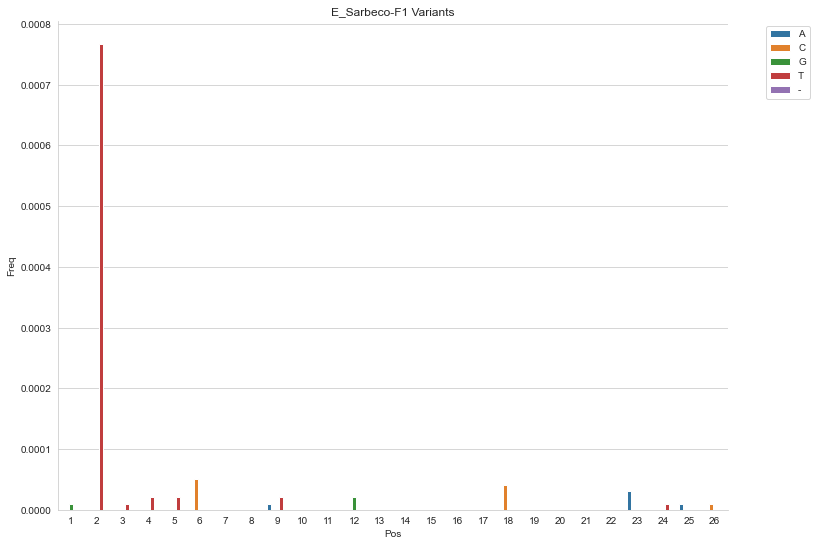

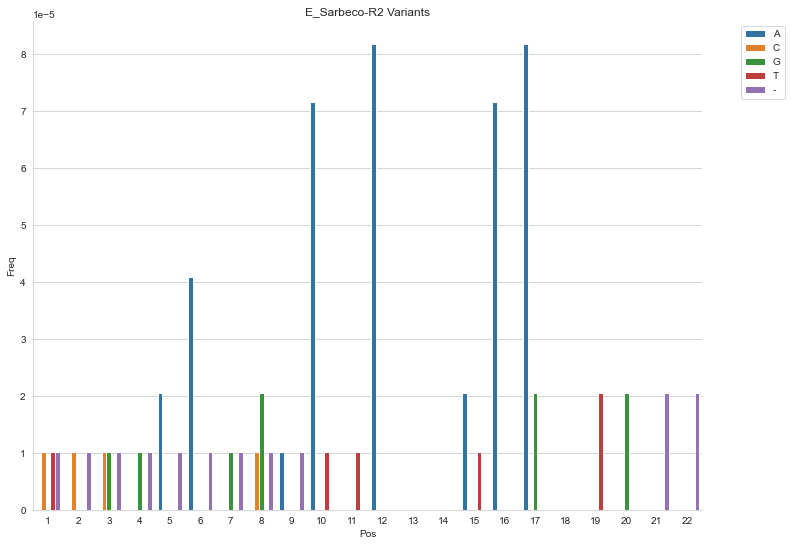

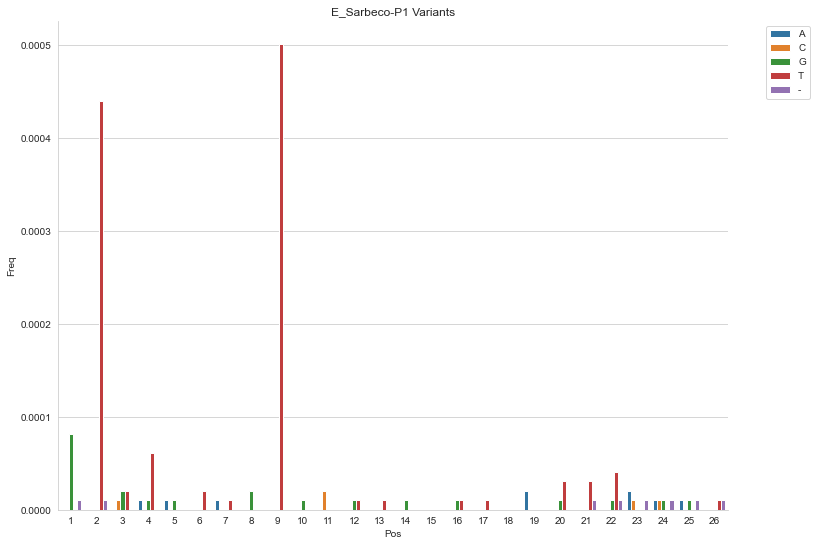

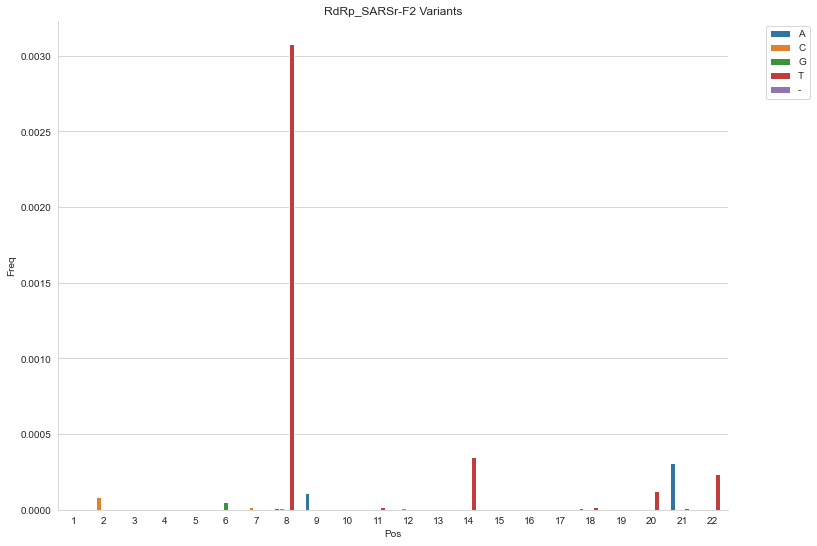

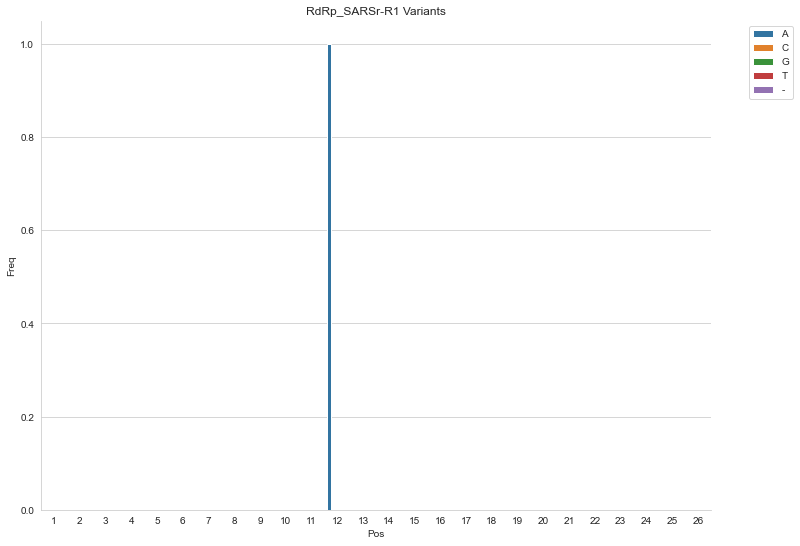

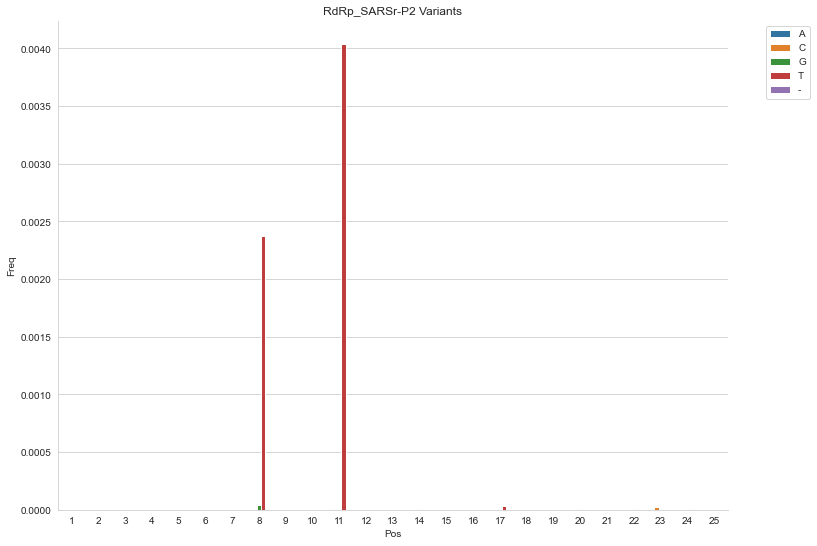

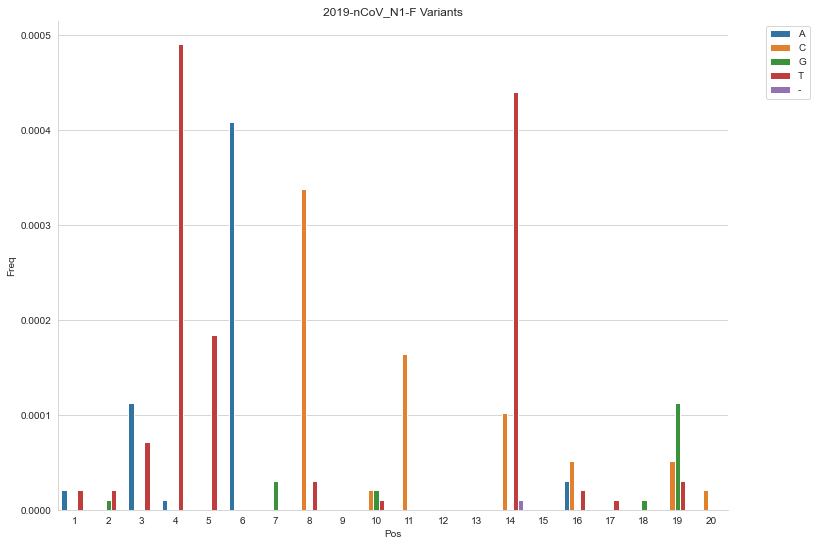

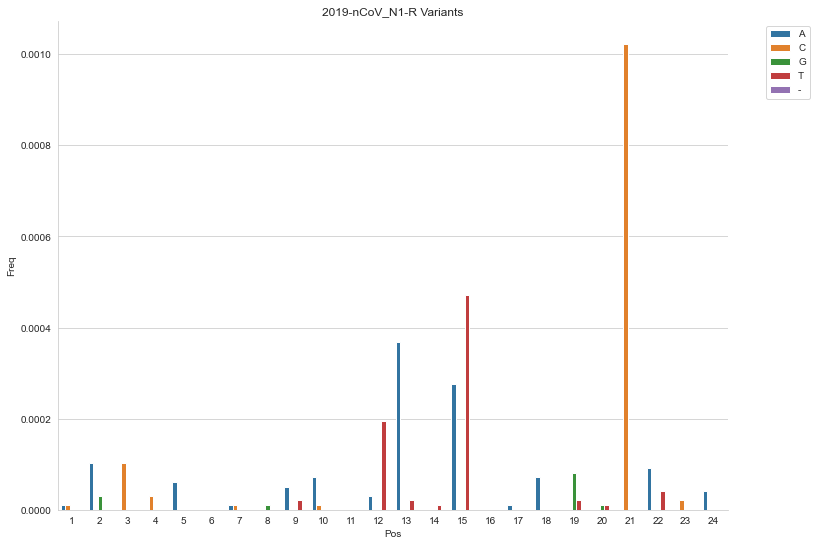

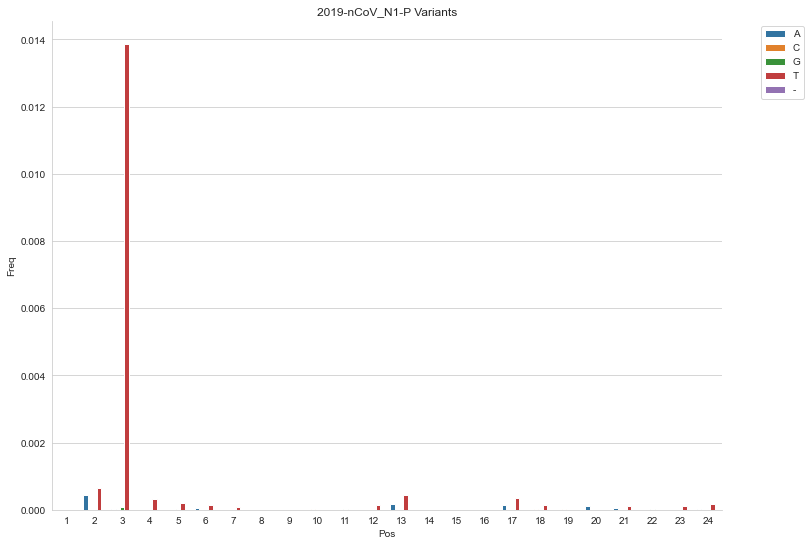

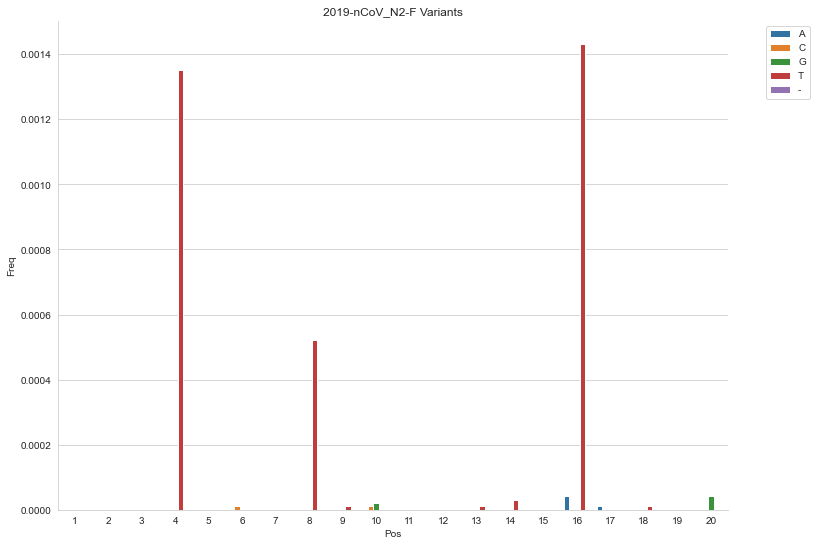

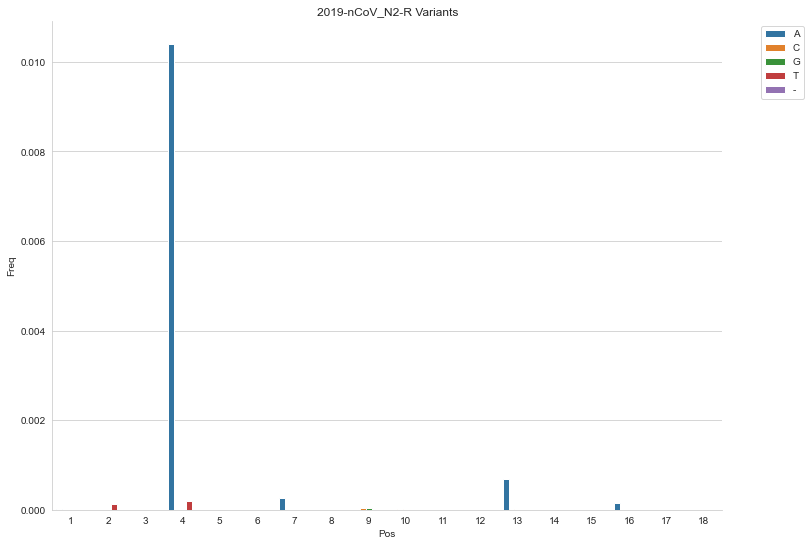

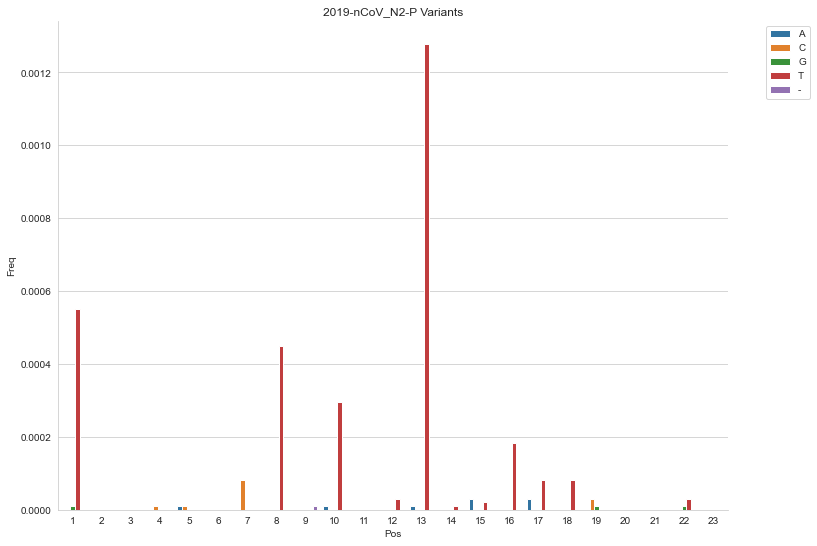

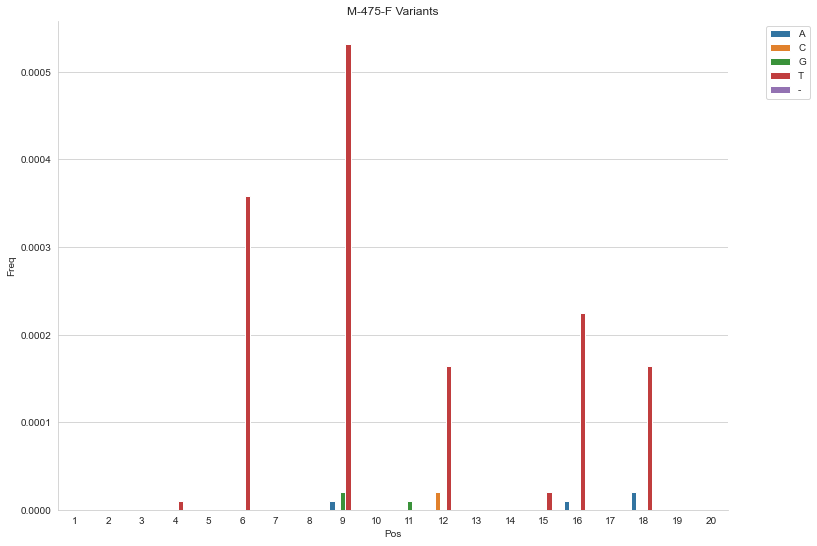

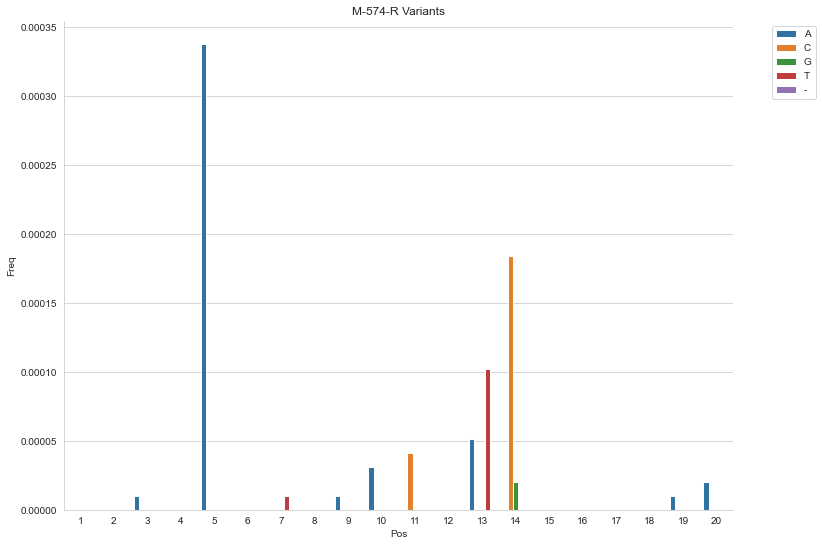

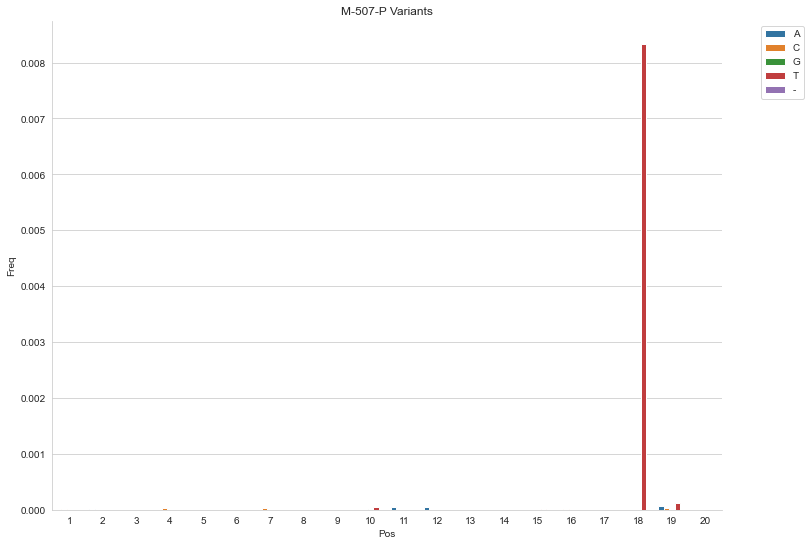

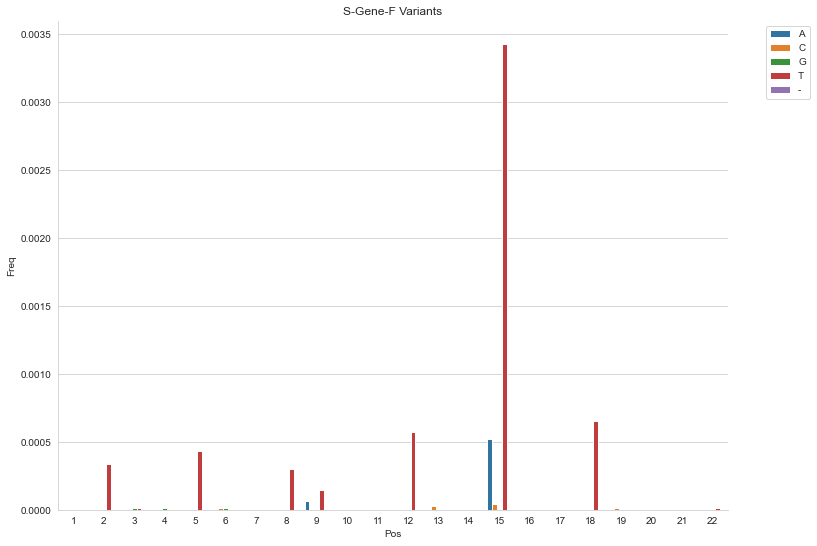

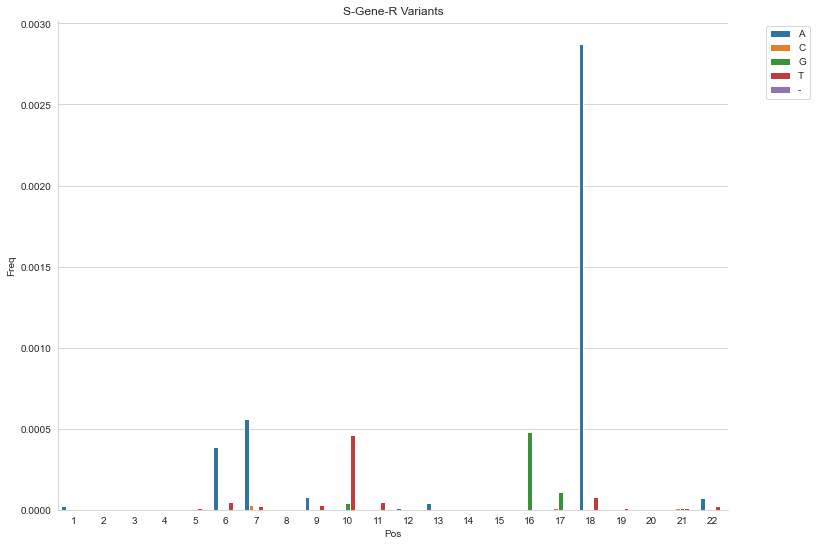

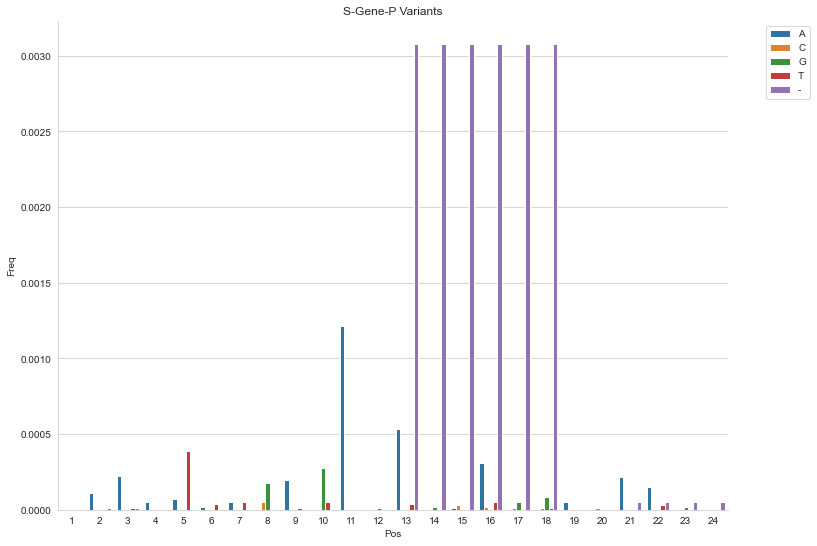

In [53]:
pos_plot_dir = "output/oligo_per_position_plots/high_qual"
if not os.path.exists(pos_plot_dir):
    os.mkdir(pos_plot_dir)
for oligo in probes:
    plt.figure(figsize=(12,9))
    sns.barplot(data=variants_pos_df[(variants_pos_df.Oligo == oligo)
                                     & (variants_pos_df.Type != 'Ref')],
                x='Pos', y='Freq',
                hue='Observed', hue_order=['A', 'C', 'G', 'T', '-'],
                order=range(1, len(probes[oligo].seq) + 1))
    plt.legend(bbox_to_anchor=(1.05, 1.0))
    plt.title("{} Variants".format(oligo))
    sns.despine()
    plt.savefig(os.path.join(pos_plot_dir, "{}_variant_positions.pdf".format(oligo)))

### Below is a convenience method for viewing probe vs strain sequences

aligned seq of probes overlapping an insertion will contain '-' characters at these sites. Sequences of probes that only overlap mismatches or deletions will be identical to unaligned probe sequence.

In [54]:
aligned_probe_seqs = dict()
for k, v in primer_msa_pos.items():
    seq = list(probes[k].seq)
    prev_pos = v[0] - 1
    aligned_seq = ''
    for i in v:
        if i > prev_pos + 1:
            gap = i - prev_pos - 1
            aligned_seq += '-' * gap
        aligned_seq += seq.pop(0)
        prev_pos = i
    aligned_probe_seqs[k] = aligned_seq
aligned_probe_seqs

def probe_vs_strain(probe, strain):
    print("{} vs {}\n{}\n{}".format(probe,
                                    strain,
                                    aligned_probe_seqs[probe],
                                    strain2probe_seq[strain][probe]))

In [55]:
n = 0
for strain in strain2probe_seq:
    if strain in whitelisted_strains:
        if '----' in strain2probe_seq[strain]['S-Gene-P']:
            n += 1
            probe_vs_strain('S-Gene-P', strain)
n

S-Gene-P vs England/CAMB-1B5FB1/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A
S-Gene-P vs England/MILK-970C68/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A
S-Gene-P vs England/MILK-9744D5/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A
S-Gene-P vs England/QEUH-9BA39A/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A
S-Gene-P vs England/ALDP-9B5DEC/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A
S-Gene-P vs England/CAMB-1B55CE/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A
S-Gene-P vs England/MILK-974912/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A
S-Gene-P vs England/MILK-99DF11/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A
S-Gene-P vs Wales/PHWC-16C4D8/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A
S-Gene-P vs England/MILK-971283/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A
S-Gene-P vs England/MILK-9AA500/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A
S-Gene-P vs Thailand/NI

ATGCTA------TCTCTGGGACC-A
S-Gene-P vs England/MILK-99CD54/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A
S-Gene-P vs England/MILK-975717/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A
S-Gene-P vs Turkey/Pen07/2020
ATGCTATACATGTCTCTGGGACC-A
ATG----------------------
S-Gene-P vs England/MILK-9AAD44/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A
S-Gene-P vs England/MILK-974E6E/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A
S-Gene-P vs Scotland/QEUH-9B44F7/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A
S-Gene-P vs England/MILK-9A9EBB/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A
S-Gene-P vs England/CAMC-9B22C2/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A
S-Gene-P vs England/MILK-995113/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A
S-Gene-P vs Scotland/QEUH-9B86EE/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A
S-Gene-P vs England/QEUH-9C8C9E/2020
ATGCTATACATGTCTCTGGGACC-A
ATGCTA------TCTCTGGGACC-A


306

In [56]:
for strain in hq_probe_diffs[(hq_probe_diffs.oligo == oligo) & (hq_probe_diffs.mismatch > 0)].strain.values:
    if strain2probe_seq[strain][oligo][3] == 'G':
        print(probe_vs_strain(oligo, strain))